## Import Stuff

In [1]:
import sqlite3
import pandas as pd
from pathlib import Path

DB_PATH = 'chembl_36/chembl_36_sqlite/chembl_36.db'

print(f"  Size: {Path(DB_PATH).stat().st_size / (1024**3):.1f} GB")

conn = sqlite3.connect(DB_PATH)

  Size: 27.7 GB


In [2]:
query = """

SELECT DISTINCT
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    cs.canonical_smiles as smile
FROM molecule_dictionary md
JOIN compound_structures cs ON md.molregno = cs.molregno
WHERE md.max_phase = 4
  AND md.molecule_type = 'Small molecule'
  AND cs.canonical_smiles IS NOT NULL
ORDER BY md.chembl_id;

"""

approved_drugs = pd.read_sql(query, conn)
print(f"Found {len(approved_drugs)} approved small molecule drugs")
print(approved_drugs.head().to_string(index=False))

Found 3127 approved small molecule drugs
 drug_internal_id      drug_id             drug_name                                          smile
           111185   CHEMBL1000            CETIRIZINE    O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
           165474 CHEMBL100116           PENTAZOCINE             CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C
           111482   CHEMBL1002        LEVOSALBUTAMOL              CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1
           111491   CHEMBL1003 CLAVULANATE POTASSIUM O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]
           111498   CHEMBL1004            DOXYLAMINE                 CN(C)CCOC(C)(c1ccccc1)c1ccccn1


In [61]:
second_query = """ -- Drug-Protein interactions with binding strength (NO action_type)
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    td.tid as protein_internal_id,
    td.chembl_id as protein_id,
    td.pref_name as protein_name,
    
    -- Binding strength (aggregated from multiple measurements)
    MAX(act.pchembl_value) as pchembl_max,
    ROUND(AVG(act.pchembl_value), 2) as pchembl_avg,
    MIN(act.standard_value) as best_value,
    COUNT(DISTINCT act.activity_id) as num_measurements,
    
    -- Quality
    MAX(ass.confidence_score) as confidence

FROM activities act
JOIN assays ass ON act.assay_id = ass.assay_id
JOIN target_dictionary td ON ass.tid = td.tid
JOIN molecule_dictionary md ON act.molregno = md.molregno

WHERE md.max_phase = 4
  AND td.target_type = 'SINGLE PROTEIN'
  AND td.organism = 'Homo sapiens'
 AND act.pchembl_value >= 5.5
 AND ass.confidence_score >= 8
  
GROUP BY 
    md.molregno, md.chembl_id, md.pref_name,
    td.tid, td.chembl_id, td.pref_name

ORDER BY md.chembl_id, pchembl_max DESC;

"""

drugs_interactions = pd.read_sql(second_query, conn)
print(f"Found {len(drugs_interactions)} drug-protein interactions")
drugs_interactions

Found 11703 drug-protein interactions


drug_internal_id       drug_id        drug_name  protein_internal_id  \
0                111185    CHEMBL1000       CETIRIZINE                  127   
1                111185    CHEMBL1000       CETIRIZINE                  102   
2                111185    CHEMBL1000       CETIRIZINE                  107   
3                165474  CHEMBL100116      PENTAZOCINE                  137   
4                165474  CHEMBL100116      PENTAZOCINE                  129   
...                 ...           ...              ...                  ...   
11698            110803     CHEMBL998       LORATADINE                11912   
11699            110803     CHEMBL998       LORATADINE                11180   
11700            164035   CHEMBL99946  LEVOMILNACIPRAN                  100   
11701            164035   CHEMBL99946  LEVOMILNACIPRAN                  121   
11702            164035   CHEMBL99946  LEVOMILNACIPRAN                  155   

       protein_id                                   protein_name  pchembl_max  \
0       CHEMBL231                          Histamine H1 receptor         8.23   
1      CHEMBL1941                          Histamine H2 receptor         5.73   
2       CHEMBL224                5-hydroxytryptamine receptor 2A         5.67   
3       CHEMBL237                     Kappa-type opioid receptor         8.66   
4       CHEMBL233                        Mu-type opioid receptor         8.57   
...           ...                                            ...          ...   
11698  CHEMBL3401  Nuclear receptor subfamily 1 group I member 2         5.52   
11699  CHEMBL2047                             Bile acid receptor         5.51   
11700   CHEMBL222     Sodium-dependent noradrenaline transporter         7.98   
11701   CHEMBL228         Sodium-dependent serotonin transporter         6.50   
11702   CHEMBL238          Sodium-dependent dopamine transporter         5.50   

       pchembl_avg  best_value  num_measurements  confidence  
0             7.50        5.89                12           9  
1             5.73     1851.40                 1           8  
2             5.67     2117.80                 1           8  
3             8.06        2.20                 3           9  
4             7.65        2.70                12           9  
...            ...         ...               ...         ...  
11698         5.52     3000.00                 1           9  
11699         5.51     3070.00                 1           9  
11700         7.59       10.50                 3           9  
11701         6.50      320.00                 2           9  
11702         5.50     3200.00                 3           9  

[11703 rows x 11 columns]

In [40]:
unique_proteins = drugs_interactions['protein_id'].nunique()
print(f"Number of unique protein_id in drugs_interactions: {unique_proteins}")

Number of unique protein_id in drugs_interactions: 1156


In [10]:
# drug effect

drug_effects = pd.read_sql("""
-- Drug-Clinical Effect relationships
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    di.mesh_id as effect_id,
    di.mesh_heading as effect_name,
    di.efo_id as efo_id,
    di.efo_term as efo_term,
    
    di.max_phase_for_ind as indication_phase,
    
    COUNT(*) as num_references

FROM drug_indication di
JOIN molecule_dictionary md ON di.molregno = md.molregno

WHERE md.max_phase = 4
  AND di.mesh_id IS NOT NULL
    AND di.max_phase_for_ind >= 4.0 

GROUP BY 
    md.molregno, md.chembl_id, md.pref_name,
    di.mesh_id, di.mesh_heading,
    di.efo_id, di.efo_term,
    di.max_phase_for_ind

ORDER BY md.chembl_id, di.max_phase_for_ind DESC;
""", conn)
print(f"Found {len(drug_effects)} drug-clinical effect relationships")


Found 8312 drug-clinical effect relationships


In [3]:
drug_effects

drug_internal_id       drug_id              drug_name effect_id  \
0               111185    CHEMBL1000             CETIRIZINE   D005132   
1               111185    CHEMBL1000             CETIRIZINE   D006967   
2               165474  CHEMBL100116            PENTAZOCINE   D010146   
3               111491    CHEMBL1003  CLAVULANATE POTASSIUM   D007239   
4               111491    CHEMBL1003  CLAVULANATE POTASSIUM   D010033   
...                ...           ...                    ...       ...   
8307            110803     CHEMBL998             LORATADINE   D006967   
8308            110803     CHEMBL998             LORATADINE   D011537   
8309            110803     CHEMBL998             LORATADINE   D012221   
8310            110803     CHEMBL998             LORATADINE   D014581   
8311            164035   CHEMBL99946        LEVOMILNACIPRAN   D003866   

                        effect_name         efo_id  \
0                Eye Manifestations    EFO:0005751   
1                  Hypersensitivity  MONDO:0005271   
2                              Pain    EFO:0003843   
3                        Infections    EFO:0000544   
4                      Otitis Media    EFO:0004992   
...                             ...            ...   
8307               Hypersensitivity  MONDO:0005271   
8308                       Pruritus     HP:0000989   
8309  Rhinitis, Allergic, Perennial    EFO:1001417   
8310                      Urticaria    EFO:0005531   
8311            Depressive Disorder  MONDO:0002009   

                           efo_term  indication_phase  num_references  
0                       eye allergy                 4               1  
1                  allergic disease                 4               1  
2                              pain                 4               1  
3                         infection                 4               1  
4                      Otitis media                 4               1  
...                             ...               ...             ...  
8307               allergic disease                 4               1  
8308                       Pruritus                 4               1  
8309  Rhinitis, Allergic, Perennial                 4               1  
8310                      urticaria                 4               1  
8311      major depressive disorder                 4               1  

[8312 rows x 9 columns]

In [12]:
drug_warnings = pd.read_sql(""" 
-- Drug warnings and adverse effects
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    dw.warning_type,
    dw.warning_class,
    dw.warning_description,
    dw.efo_id,
    dw.efo_term,
    dw.warning_year,
    dw.warning_country
    
FROM drug_warning dw
JOIN molecule_dictionary md ON dw.molregno = md.molregno

WHERE md.max_phase = 4

ORDER BY md.chembl_id;
""", conn)

print(f"Found {len(drug_warnings)} drug warnings and adverse effects")


Found 2294 drug warnings and adverse effects


In [17]:
drug_warnings.head(10)

drug_internal_id     drug_id              drug_name       warning_type  \
0             12417   CHEMBL101         PHENYLBUTAZONE          Withdrawn   
1             12417   CHEMBL101         PHENYLBUTAZONE          Withdrawn   
2             12417   CHEMBL101         PHENYLBUTAZONE          Withdrawn   
3             12417   CHEMBL101         PHENYLBUTAZONE          Withdrawn   
4             12417   CHEMBL101         PHENYLBUTAZONE          Withdrawn   
5             12417   CHEMBL101         PHENYLBUTAZONE          Withdrawn   
6            116349  CHEMBL1014  CANDESARTAN CILEXETIL  Black Box Warning   
7            116349  CHEMBL1014  CANDESARTAN CILEXETIL  Black Box Warning   
8            116949  CHEMBL1017            TELMISARTAN  Black Box Warning   
9            116949  CHEMBL1017            TELMISARTAN  Black Box Warning   

            warning_class                    warning_description  \
0                    None               severe adverse reactions   
1             drug misuse  Off-Label Abuse; Hematologic Toxicity   
2  hematological toxicity   aplastic anaemia and agranulocytosis   
3  hematological toxicity  Off-Label Abuse; Hematologic Toxicity   
4  hematological toxicity   aplastic anaemia and agranulocytosis   
5                    None                               toxicity   
6          teratogenicity                                   None   
7          cardiotoxicity                                   None   
8          teratogenicity                                   None   
9          cardiotoxicity                                   None   

          efo_id                efo_term  warning_year  \
0    EFO:0009658          adverse effect        1984.0   
1  MONDO:0002491         substance abuse        1984.0   
2     HP:0012234         Agranulocytosis        1984.0   
3    EFO:0011051  hematological toxicity        1984.0   
4     HP:0001915         Aplastic anemia        1984.0   
5           None                    None        1984.0   
6           None                    None           NaN   
7           None                    None           NaN   
8           None                    None           NaN   
9           None                    None           NaN   

                                     warning_country  
0  Malaysia; United Arab Emirates; Ethiopia; Jord...  
1  Malaysia; United Arab Emirates; Ethiopia; Jord...  
2  Malaysia; United Arab Emirates; Ethiopia; Jord...  
3  Malaysia; United Arab Emirates; Ethiopia; Jord...  
4  Malaysia; United Arab Emirates; Ethiopia; Jord...  
5  Malaysia; United Arab Emirates; Ethiopia; Jord...  
6                                      United States  
7                                      United States  
8                                      United States  
9                                      United States

In [18]:
drug_mechanism = pd.read_sql(""" -- Drug mechanism of action
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    dm.mec_id as mechanism_id,
    
    -- Mechanism details
    dm.mechanism_of_action,
    dm.action_type,
    
    -- Target info
    td.tid as target_internal_id,
    td.chembl_id as target_id,
    td.pref_name as target_name,
    
    -- Additional mechanism info
    dm.direct_interaction,
    dm.molecular_mechanism,
    dm.disease_efficacy,
    dm.mechanism_comment,
    dm.selectivity_comment

FROM drug_mechanism dm
JOIN molecule_dictionary md ON dm.molregno = md.molregno
LEFT JOIN target_dictionary td ON dm.tid = td.tid

WHERE md.max_phase = 4

ORDER BY md.chembl_id, dm.mec_id;
""", conn)
print(f"Found {len(drug_mechanism)} drug mechanisms of action")
drug_mechanism

Found 3715 drug mechanisms of action


drug_internal_id     drug_id               drug_name  mechanism_id  \
0               111491  CHEMBL1003   CLAVULANATE POTASSIUM          1667   
1               112480  CHEMBL1006              AMIFOSTINE          2167   
2               112655  CHEMBL1009                LEVODOPA           246   
3                12417   CHEMBL101          PHENYLBUTAZONE          1205   
4               112665  CHEMBL1010       CEFOTAXIME SODIUM          1722   
...                ...         ...                     ...           ...   
3710            101924   CHEMBL984     MIVACURIUM CHLORIDE          1536   
3711            105252   CHEMBL989  FLUOCINOLONE ACETONIDE           810   
3712            107119   CHEMBL991               STAVUDINE           831   
3713            109797   CHEMBL995      LOSARTAN POTASSIUM           220   
3714            110803   CHEMBL998              LORATADINE           147   

                                    mechanism_of_action action_type  \
0                Bacterial beta-lactamase TEM inhibitor   INHIBITOR   
1                  Reactive metabolite scavenging agent        None   
2                          Dopamine D3 receptor agonist     AGONIST   
3                              Cyclooxygenase inhibitor   INHIBITOR   
4        Bacterial penicillin-binding protein inhibitor   INHIBITOR   
...                                                 ...         ...   
3710  Muscle-type nicotinic acetylcholine receptor a...  ANTAGONIST   
3711                    Glucocorticoid receptor agonist     AGONIST   
3712  Human immunodeficiency virus type 1 reverse tr...   INHIBITOR   
3713          Type-1 angiotensin II receptor antagonist  ANTAGONIST   
3714                   Histamine H1 receptor antagonist  ANTAGONIST   

      target_internal_id      target_id  \
0               106170.0  CHEMBL2364670   
1                    NaN           None   
2                  130.0      CHEMBL234   
3               104725.0  CHEMBL2094253   
4               105683.0  CHEMBL2354204   
...                  ...            ...   
3710            105709.0  CHEMBL2362997   
3711                25.0     CHEMBL2034   
3712               228.0      CHEMBL247   
3713               115.0      CHEMBL227   
3714               127.0      CHEMBL231   

                                            target_name  direct_interaction  \
0                                    Beta-lactamase TEM                   1   
1                                                  None                   1   
2                                D(3) dopamine receptor                   1   
3                                        Cyclooxygenase                   1   
4                  Bacterial penicillin-binding protein                   1   
...                                                 ...                 ...   
3710       Muscle-type nicotinic acetylcholine receptor                   1   
3711                            Glucocorticoid receptor                   1   
3712  Human immunodeficiency virus type 1 reverse tr...                   1   
3713                     Type-1 angiotensin II receptor                   1   
3714                              Histamine H1 receptor                   1   

      molecular_mechanism  disease_efficacy  \
0                       1                 1   
1                       1                 1   
2                       1                 1   
3                       1                 1   
4                       1                 1   
...                   ...               ...   
3710                    1                 1   
3711                    1                 1   
3712                    1                 1   
3713                    1                 1   
3714                    1                 1   

                                      mechanism_comment selectivity_comment  
0                                                  None      Broad spectrum  
1     Prodrug. Scavenge of reactive oxygen species a.

In [25]:
# Remove rows with Unknown mechanism
drug_mechanism_filtered = drug_mechanism[drug_mechanism['mechanism_of_action'] != 'Unknown']
drug_mechanism_filtered = drug_mechanism_filtered[drug_mechanism_filtered['mechanism_of_action'] != 'Diagnostic agent']

# Get statistics for mechanism_of_action unique count and repetition analysis (excluding Unknown)
moa_unique = drug_mechanism_filtered['mechanism_of_action'].nunique()
moa_counts = drug_mechanism_filtered['mechanism_of_action'].value_counts()

print(f"Total unique mechanisms of action (excluding Unknown): {moa_unique}")
print(f"Min repetitions: {moa_counts.min()}")
print(f"Max repetitions: {moa_counts.max()}")
print(f"Average repetitions: {moa_counts.mean():.2f}")
print(f"\nTop 10 most common mechanisms of action:")
print(moa_counts.head(10))


Total unique mechanisms of action (excluding Unknown): 998
Min repetitions: 1
Max repetitions: 76
Average repetitions: 3.48

Top 10 most common mechanisms of action:
mechanism_of_action
DNA inhibitor                                                   76
Bacterial penicillin-binding protein inhibitor                  65
Glucocorticoid receptor agonist                                 63
Histamine H1 receptor antagonist                                57
Sodium channel alpha subunit blocker                            50
Bacterial 70S ribosome inhibitor                                49
Cyclooxygenase inhibitor                                        48
GABA-A receptor; anion channel positive allosteric modulator    45
Serotonin 2a (5-HT2a) receptor antagonist                       42
Dopamine D2 receptor antagonist                                 37
Name: count, dtype: int64


In [26]:
drug_mechanism_filtered

drug_internal_id     drug_id               drug_name  mechanism_id  \
0               111491  CHEMBL1003   CLAVULANATE POTASSIUM          1667   
1               112480  CHEMBL1006              AMIFOSTINE          2167   
2               112655  CHEMBL1009                LEVODOPA           246   
3                12417   CHEMBL101          PHENYLBUTAZONE          1205   
4               112665  CHEMBL1010       CEFOTAXIME SODIUM          1722   
...                ...         ...                     ...           ...   
3710            101924   CHEMBL984     MIVACURIUM CHLORIDE          1536   
3711            105252   CHEMBL989  FLUOCINOLONE ACETONIDE           810   
3712            107119   CHEMBL991               STAVUDINE           831   
3713            109797   CHEMBL995      LOSARTAN POTASSIUM           220   
3714            110803   CHEMBL998              LORATADINE           147   

                                    mechanism_of_action action_type  \
0                Bacterial beta-lactamase TEM inhibitor   INHIBITOR   
1                  Reactive metabolite scavenging agent        None   
2                          Dopamine D3 receptor agonist     AGONIST   
3                              Cyclooxygenase inhibitor   INHIBITOR   
4        Bacterial penicillin-binding protein inhibitor   INHIBITOR   
...                                                 ...         ...   
3710  Muscle-type nicotinic acetylcholine receptor a...  ANTAGONIST   
3711                    Glucocorticoid receptor agonist     AGONIST   
3712  Human immunodeficiency virus type 1 reverse tr...   INHIBITOR   
3713          Type-1 angiotensin II receptor antagonist  ANTAGONIST   
3714                   Histamine H1 receptor antagonist  ANTAGONIST   

      target_internal_id      target_id  \
0               106170.0  CHEMBL2364670   
1                    NaN           None   
2                  130.0      CHEMBL234   
3               104725.0  CHEMBL2094253   
4               105683.0  CHEMBL2354204   
...                  ...            ...   
3710            105709.0  CHEMBL2362997   
3711                25.0     CHEMBL2034   
3712               228.0      CHEMBL247   
3713               115.0      CHEMBL227   
3714               127.0      CHEMBL231   

                                            target_name  direct_interaction  \
0                                    Beta-lactamase TEM                   1   
1                                                  None                   1   
2                                D(3) dopamine receptor                   1   
3                                        Cyclooxygenase                   1   
4                  Bacterial penicillin-binding protein                   1   
...                                                 ...                 ...   
3710       Muscle-type nicotinic acetylcholine receptor                   1   
3711                            Glucocorticoid receptor                   1   
3712  Human immunodeficiency virus type 1 reverse tr...                   1   
3713                     Type-1 angiotensin II receptor                   1   
3714                              Histamine H1 receptor                   1   

      molecular_mechanism  disease_efficacy  \
0                       1                 1   
1                       1                 1   
2                       1                 1   
3                       1                 1   
4                       1                 1   
...                   ...               ...   
3710                    1                 1   
3711                    1                 1   
3712                    1                 1   
3713                    1                 1   
3714                    1                 1   

                                      mechanism_comment selectivity_comment  
0                                                  None      Broad spectrum  
1     Prodrug. Scavenge of reactive oxygen species a.

In [31]:
therapeutic_classes = pd.read_sql(""" 
-- Get ATC codes for drugs
SELECT 
    md.molregno as drug_internal_id,
    md.chembl_id as drug_id,
    md.pref_name as drug_name,
    
    atc.level5 as atc_code,
    atc.level1,
    atc.level1_description,
    atc.level2,
    atc.level2_description,
    atc.level3,
    atc.level3_description,
    atc.level4_description

FROM molecule_atc_classification mac
JOIN atc_classification atc ON mac.level5 = atc.level5
JOIN molecule_dictionary md ON mac.molregno = md.molregno

WHERE md.max_phase = 4

ORDER BY md.chembl_id;
""", conn)
print(f"Found {len(therapeutic_classes)} drug therapeutic classes")

Found 2949 drug therapeutic classes


In [39]:
print(f"Number of unique values in level3_description: {therapeutic_classes['level4_description'].nunique()}")

# Print all unique level3_description values
print("\nAll unique level3_description values:")
for desc in sorted(therapeutic_classes['level3_description'].unique()):
    print(f"- {desc}")

Number of unique values in level3_description: 599

All unique level3_description values:
- ACE INHIBITORS, PLAIN
- ADRENERGICS FOR SYSTEMIC USE
- ADRENERGICS, INHALANTS
- AGENTS AGAINST AMOEBIASIS AND OTHER PROTOZOAL DISEASES
- AGENTS AGAINST LEISHMANIASIS AND TRYPANOSOMIASIS
- AGENTS FOR TREATMENT OF HEMORRHOIDS AND ANAL FISSURES FOR TOPICAL USE
- ALDOSTERONE ANTAGONISTS AND OTHER POTASSIUM-SPARING AGENTS
- ALKYLATING AGENTS
- ALL OTHER THERAPEUTIC PRODUCTS
- AMINOGLYCOSIDE ANTIBACTERIALS
- AMPHENICOLS
- ANABOLIC STEROIDS
- ANDROGENS
- ANDROGENS AND FEMALE SEX HORMONES IN COMBINATION
- ANESTHETICS, GENERAL
- ANESTHETICS, LOCAL
- ANGIOTENSIN II RECEPTOR BLOCKERS (ARBs), PLAIN
- ANTACIDS
- ANTERIOR PITUITARY LOBE HORMONES AND ANALOGUES
- ANTI-ACNE PREPARATIONS FOR SYSTEMIC USE
- ANTI-ACNE PREPARATIONS FOR TOPICAL USE
- ANTI-DEMENTIA DRUGS
- ANTI-PARATHYROID AGENTS
- ANTIADRENAL PREPARATIONS
- ANTIADRENERGIC AGENTS, CENTRALLY ACTING
- ANTIADRENERGIC AGENTS, GANGLION-BLOCKING
- ANTIADREN

##  Computing the ESM2 embedings 

In [41]:


# Get unique protein IDs from your interactions table
unique_proteins = drugs_interactions[['protein_internal_id', 'protein_id', 'protein_name']].drop_duplicates()
print(f"Found {len(unique_proteins)} unique proteins")

# Extract sequences for these proteins
protein_ids_str = ','.join(map(str, unique_proteins['protein_internal_id'].tolist()))

sequence_query = f"""
SELECT DISTINCT
    td.tid as protein_internal_id,
    td.chembl_id as protein_id,
    td.pref_name as protein_name,
    cs.accession as uniprot_id,
    cs.sequence as amino_acid_sequence,
    LENGTH(cs.sequence) as sequence_length

FROM target_dictionary td
JOIN target_components tc ON td.tid = tc.tid
JOIN component_sequences cs ON tc.component_id = cs.component_id

WHERE td.tid IN ({protein_ids_str})
  AND cs.sequence IS NOT NULL
  AND cs.db_source = 'SWISS-PROT'
  AND td.organism = 'Homo sapiens'

ORDER BY td.tid;
"""

proteins_with_sequences = pd.read_sql(sequence_query, conn)


print(f"✓ Got sequences for {len(proteins_with_sequences)} proteins")
print(f"  Missing sequences: {len(unique_proteins) - len(proteins_with_sequences)}")

# Show sequence length stats
print(f"\nSequence length statistics:")
print(f"  Min: {proteins_with_sequences['sequence_length'].min()}")
print(f"  Max: {proteins_with_sequences['sequence_length'].max()}")
print(f"  Mean: {proteins_with_sequences['sequence_length'].mean():.0f}")
print(f"  Median: {proteins_with_sequences['sequence_length'].median():.0f}")

# Save for reference
proteins_with_sequences.to_csv('proteins_for_embedding.csv', index=False)
print(f"\n✓ Saved to proteins_for_embedding.csv")

Found 1156 unique proteins
✓ Got sequences for 1156 proteins
  Missing sequences: 0

Sequence length statistics:
  Min: 92
  Max: 4128
  Mean: 650
  Median: 509

✓ Saved to proteins_for_embedding.csv


In [3]:
import pandas as pd
protein_nodes = pd.read_csv('protein_nodes_with_embeddings.csv')

In [4]:
protein_nodes

protein_internal_id     protein_id  \
0                       1     CHEMBL2074   
1                       3     CHEMBL1827   
2                       4     CHEMBL1859   
3                       6      CHEMBL202   
4                       8     CHEMBL1862   
...                   ...            ...   
1151               120172  CHEMBL4739707   
1152               120188  CHEMBL4739852   
1153               120720  CHEMBL5169181   
1154               120920  CHEMBL5291553   
1155               122129  CHEMBL6066240   

                                           protein_name uniprot_id  \
0                                  Maltase-glucoamylase     O43451   
1          cGMP-specific 3',5'-cyclic phosphodiesterase     O76074   
2     Voltage-dependent T-type calcium channel subun...     O95180   
3                               Dihydrofolate reductase     P00374   
4                          Tyrosine-protein kinase ABL1     P00519   
...                                                 ...        ...   
1151                         Zinc finger protein Aiolos     Q9UKT9   
1152                            Forkhead box protein M1     Q08050   
1153                            Cysteine protease ATG4A     Q8WYN0   
1154                                Ceramide synthase 2     Q96G23   
1155                  Tissue factor pathway inhibitor 2     P48307   

                                    amino_acid_sequence  sequence_length  \
0     MARKKLKKFTTLEIVLSVLLLVLFIISIVLIVLLAKESLKSTAPDP...             2753   
1     MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...              875   
2     MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...             2353   
3     MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...              187   
4     MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...             1130   
...                                                 ...              ...   
1151  MEDIQTNAELKSTQEQSVPAESAAVLNDYSLTKSHEMENVDSGEGP...              509   
1152  MKTSPRRPLILKRRRLPLPVQNAPSETSEEEPKRSPAQQESNQAEA...              763   
1153  MESVLSKYEDQITIFTDYLEEYPDTDELVWILGKQHLLKTEKSKLL...              398   
1154  MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...              380   
1155  MDPARPLGLSILLLFLTEAALGDAAQEPTGNNAEICLLPLDYGPCR...              235   

                                         esm2_embedding  
0     [ 0.04742809  0.05068395 -0.00521158 ...  0.01...  
1     [ 0.01600313 -0.03483257  0.02725765 ...  0.03...  
2     [ 0.06919791 -0.01337756 -0.02448801 ...  0.02...  
3     [-0.03865064  0.01976737  0.03507854 ...  0.16...  
4     [ 0.00487325 -0.03196116 -0.05082441 ...  0.02...  
...                                                 ...  
1151  [-0.02622237  0.03076161  0.03676185 ...  0.04...  
1152  [-0.02174063  0.01220898  0.05810045 ...  0.04...  
1153  [-0.13791342  0.06027076  0.00379627 ...  0.10...  
1154  [-0.04562213  0.01851538 -0.02616956 ...  0.05...  
1155  [-1.1650940e-04  5.2879781e-02 -6.2201377e-02 ...  

[1156 rows x 7 columns]

In [1]:
import torch
from transformers import AutoTokenizer, EsmModel

/home/joe/miniconda3/envs/bw-py311/lib/python3.11/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [ ]:
import numpy as np
from tqdm import tqdm
import gc

print("\n" + "="*80)
print("esm2_t48_15B_UR50D")
print("="*80)

# Configuration
ESM_MODEL = "facebook/esm2_t36_3B_UR50D"  # 3B params, 1280-dim
MAX_LENGTH = 1024  # ESM-2 max sequence length
BATCH_SIZE = 4  # Process 4 proteins at once
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"\nDevice: {DEVICE}")
print(f"Model: {ESM_MODEL}")
print(f"Batch size: {BATCH_SIZE}")

# Load model
print("\nLoading ESM-2 model...")
tokenizer = AutoTokenizer.from_pretrained(ESM_MODEL)
model = EsmModel.from_pretrained(ESM_MODEL)
model.to(DEVICE)
model.eval()
print("✓ Model loaded")

# Function to compute embeddings in batches
def compute_esm2_embeddings_batch(sequences, batch_size=4):
    """Compute ESM-2 embeddings for multiple sequences."""
    
    all_embeddings = []
    num_batches = (len(sequences) + batch_size - 1) // batch_size
    
    print(f"\nComputing embeddings in {num_batches} batches...")
    
    for i in tqdm(range(0, len(sequences), batch_size)):
        batch = sequences[i:i+batch_size]
        
        # Tokenize batch
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=MAX_LENGTH,
            padding=True
        )
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        
        # Get embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Mean pooling over sequence length
        embeddings = outputs.last_hidden_state.mean(dim=1)  # (batch_size, 1280)
        embeddings = embeddings.cpu().numpy()
        
        all_embeddings.append(embeddings)
        
        # Clear GPU memory
        del inputs, outputs, embeddings
        if DEVICE == "cuda":
            torch.cuda.empty_cache()
    
    return np.vstack(all_embeddings)

# Compute embeddings
sequences = protein_nodes['amino_acid_sequence'].tolist()

print(f"\nProcessing {len(sequences)} protein sequences...")
print(f"Estimated time: {len(sequences) * 2 / 60:.1f} minutes (CPU) or {len(sequences) * 0.5 / 60:.1f} minutes (GPU)")

embeddings = compute_esm2_embeddings_batch(sequences, batch_size=BATCH_SIZE)

print(f"\n✓ Computed {len(embeddings)} embeddings")
print(f"  Embedding shape: {embeddings.shape}")
print(f"  Memory usage: {embeddings.nbytes / (1024**2):.1f} MB")



esm2_t48_15B_UR50D

Device: cuda
Model: facebook/esm2_t36_3B_UR50D
Batch size: 4

Loading ESM-2 model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✓ Model loaded

Processing 1156 protein sequences...
Estimated time: 38.5 minutes (CPU) or 9.6 minutes (GPU)

Computing embeddings in 289 batches...


100%|██████████| 289/289 [25:48<00:00,  5.36s/it] 


✓ Computed 1156 embeddings
  Embedding shape: (1156, 2560)
  Memory usage: 11.3 MB


NameError: name 'proteins_with_sequences' is not defined

In [8]:
proteins_with_sequences = protein_nodes.copy()
# Add embeddings to dataframe
proteins_with_sequences['esm2_embedding'] = list(embeddings)

# Save
print("\nSaving results...")
proteins_with_sequences.to_pickle('protein_nodes_with_embeddings.pkl')
print("✓ Saved to protein_nodes_with_embeddings.pkl")

# Quality checks
print("\n" + "="*80)
print("QUALITY CHECKS")
print("="*80)

# Check for zero embeddings (errors)
non_zero = (embeddings.sum(axis=1) != 0).sum()
print(f"Non-zero embeddings: {non_zero}/{len(embeddings)}")

# Check embedding norms
norms = np.linalg.norm(embeddings, axis=1)
print(f"Embedding norm stats:")
print(f"  Mean: {norms.mean():.2f}")
print(f"  Std: {norms.std():.2f}")
print(f"  Min: {norms.min():.2f}")
print(f"  Max: {norms.max():.2f}")

# Test similarity between related proteins (if we have opioid receptors)
print("\nTesting protein family similarity...")
opioid_proteins = proteins_with_sequences[
    proteins_with_sequences['protein_name'].str.contains('opioid', case=False, na=False)
]

if len(opioid_proteins) >= 2:
    from sklearn.metrics.pairwise import cosine_similarity
    
    opioid_indices = opioid_proteins.index.tolist()
    opioid_embeddings = embeddings[opioid_indices]
    
    sim_matrix = cosine_similarity(opioid_embeddings)
    
    print(f"\nOpioid receptor family ({len(opioid_proteins)} proteins):")
    for i, row in opioid_proteins.iterrows():
        print(f"  {row['protein_name']}")
    
    # Get off-diagonal similarities
    off_diag = sim_matrix[np.triu_indices_from(sim_matrix, k=1)]
    if len(off_diag) > 0:
        print(f"\nSimilarity within family:")
        print(f"  Mean: {off_diag.mean():.3f}")
        print(f"  Min: {off_diag.min():.3f}")
        print(f"  Max: {off_diag.max():.3f}")
        print(f"  (Should be high, e.g., >0.7 for protein families)")

print("\n" + "="*80)
print("COMPLETE!")
print("="*80)

# Clean up
del model, tokenizer
gc.collect()
if DEVICE == "cuda":
    torch.cuda.empty_cache()


Saving results...
✓ Saved to protein_nodes_with_embeddings.pkl

QUALITY CHECKS
Non-zero embeddings: 1156/1156
Embedding norm stats:
  Mean: 12.06
  Std: 1.09
  Min: 7.70
  Max: 14.78

Testing protein family similarity...

Opioid receptor family (4 proteins):
  Mu-type opioid receptor
  Delta-type opioid receptor
  Kappa-type opioid receptor
  Sigma non-opioid intracellular receptor 1

Similarity within family:
  Mean: 0.971
  Min: 0.944
  Max: 0.994
  (Should be high, e.g., >0.7 for protein families)

COMPLETE!


In [16]:
proteins_with_sequences.loc[0, 'esm2_embedding'][0:50]

array([ 0.04742812,  0.05068392, -0.00521164, -0.07658282, -0.02220379,
       -0.09370419, -0.03626163,  0.09330738,  0.04638663, -0.02819531,
       -0.00983069,  0.02345282,  0.05614319,  0.03976704, -0.04997655,
       -0.09005289, -0.02194233,  0.0562034 , -0.01379073,  0.04971637,
        0.0264782 , -0.11337636, -0.03301386, -0.02439141,  0.02422917,
       -0.02401767,  0.11082777, -0.11084066, -0.15101442,  0.00491269,
        0.11837548,  0.04537129, -0.06079851,  0.0004247 , -0.01956876,
        0.03862645,  0.01456377, -0.01362921, -0.02631395, -0.01443873,
       -0.04168907, -0.00845558,  0.19307739,  0.00445529, -0.1083348 ,
       -0.03892311,  0.02409142,  0.03838626,  0.00917137,  0.03155655],
      dtype=float32)

## Reloading the Data

In [1]:
import pandas as pd

drug_effects = pd.read_csv("drug_effects.csv") 
drug_effects

drug_internal_id       drug_id              drug_name effect_id  \
0               111185    CHEMBL1000             CETIRIZINE   D005132   
1               111185    CHEMBL1000             CETIRIZINE   D006967   
2               165474  CHEMBL100116            PENTAZOCINE   D010146   
3               111491    CHEMBL1003  CLAVULANATE POTASSIUM   D007239   
4               111491    CHEMBL1003  CLAVULANATE POTASSIUM   D010033   
...                ...           ...                    ...       ...   
8307            110803     CHEMBL998             LORATADINE   D006967   
8308            110803     CHEMBL998             LORATADINE   D011537   
8309            110803     CHEMBL998             LORATADINE   D012221   
8310            110803     CHEMBL998             LORATADINE   D014581   
8311            164035   CHEMBL99946        LEVOMILNACIPRAN   D003866   

                        effect_name         efo_id  \
0                Eye Manifestations    EFO:0005751   
1                  Hypersensitivity  MONDO:0005271   
2                              Pain    EFO:0003843   
3                        Infections    EFO:0000544   
4                      Otitis Media    EFO:0004992   
...                             ...            ...   
8307               Hypersensitivity  MONDO:0005271   
8308                       Pruritus     HP:0000989   
8309  Rhinitis, Allergic, Perennial    EFO:1001417   
8310                      Urticaria    EFO:0005531   
8311            Depressive Disorder  MONDO:0002009   

                           efo_term  indication_phase  num_references  
0                       eye allergy                 4               1  
1                  allergic disease                 4               1  
2                              pain                 4               1  
3                         infection                 4               1  
4                      Otitis media                 4               1  
...                             ...               ...             ...  
8307               allergic disease                 4               1  
8308                       Pruritus                 4               1  
8309  Rhinitis, Allergic, Perennial                 4               1  
8310                      urticaria                 4               1  
8311      major depressive disorder                 4               1  

[8312 rows x 9 columns]

In [2]:
drug_nodes = pd.read_csv("drug_nodes.csv")
drugs_interactions = pd.read_csv("drugs_interactions.csv")
drug_nodes

drug_internal_id       drug_id              drug_name  \
0               111185    CHEMBL1000             CETIRIZINE   
1               165474  CHEMBL100116            PENTAZOCINE   
2               111482    CHEMBL1002         LEVOSALBUTAMOL   
3               111491    CHEMBL1003  CLAVULANATE POTASSIUM   
4               111498    CHEMBL1004             DOXYLAMINE   
...                ...           ...                    ...   
3122            109797     CHEMBL995     LOSARTAN POTASSIUM   
3123            109807     CHEMBL996              CEFOXITIN   
3124            110435     CHEMBL997        IBANDRONIC ACID   
3125            110803     CHEMBL998             LORATADINE   
3126            164035   CHEMBL99946        LEVOMILNACIPRAN   

                                                  smile  
0           O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1  
1                    CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C  
2                     CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1  
3        O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]  
4                        CN(C)CCOC(C)(c1ccccc1)c1ccccn1  
...                                                 ...  
3122  CCCCc1nc(Cl)c(CO)n1Cc1ccc(-c2ccccc2-c2nnn[n-]2...  
3123  CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...  
3124                CCCCCN(C)CCC(O)(P(=O)(O)O)P(=O)(O)O  
3125       CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1  
3126              CCN(CC)C(=O)[C@@]1(c2ccccc2)C[C@H]1CN  

[3127 rows x 4 columns]

In [3]:
import pandas as pd
protien_nodes = pd.read_pickle("protein_nodes_with_embeddings_v4.pkl")

protien_nodes

protein_internal_id     protein_id  \
0                       1     CHEMBL2074   
1                       3     CHEMBL1827   
2                       4     CHEMBL1859   
3                       6      CHEMBL202   
4                       8     CHEMBL1862   
...                   ...            ...   
1151               120172  CHEMBL4739707   
1152               120188  CHEMBL4739852   
1153               120720  CHEMBL5169181   
1154               120920  CHEMBL5291553   
1155               122129  CHEMBL6066240   

                                           protein_name uniprot_id  \
0                                  Maltase-glucoamylase     O43451   
1          cGMP-specific 3',5'-cyclic phosphodiesterase     O76074   
2     Voltage-dependent T-type calcium channel subun...     O95180   
3                               Dihydrofolate reductase     P00374   
4                          Tyrosine-protein kinase ABL1     P00519   
...                                                 ...        ...   
1151                         Zinc finger protein Aiolos     Q9UKT9   
1152                            Forkhead box protein M1     Q08050   
1153                            Cysteine protease ATG4A     Q8WYN0   
1154                                Ceramide synthase 2     Q96G23   
1155                  Tissue factor pathway inhibitor 2     P48307   

                                    amino_acid_sequence  sequence_length  \
0     MARKKLKKFTTLEIVLSVLLLVLFIISIVLIVLLAKESLKSTAPDP...             2753   
1     MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...              875   
2     MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...             2353   
3     MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...              187   
4     MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...             1130   
...                                                 ...              ...   
1151  MEDIQTNAELKSTQEQSVPAESAAVLNDYSLTKSHEMENVDSGEGP...              509   
1152  MKTSPRRPLILKRRRLPLPVQNAPSETSEEEPKRSPAQQESNQAEA...              763   
1153  MESVLSKYEDQITIFTDYLEEYPDTDELVWILGKQHLLKTEKSKLL...              398   
1154  MLQTLYDYFWWERLWLPVNLTWADLEDRDGRVYAKASDLYITLPLA...              380   
1155  MDPARPLGLSILLLFLTEAALGDAAQEPTGNNAEICLLPLDYGPCR...              235   

                                         esm2_embedding  
0     [0.04742812, 0.05068392, -0.0052116434, -0.076...  
1     [0.01600314, -0.034832526, 0.027257647, -0.046...  
2     [0.069197826, -0.01337759, -0.024488002, 0.007...  
3     [-0.038650565, 0.01976762, 0.035078324, -0.012...  
4     [0.004873156, -0.031961165, -0.050824426, -0.0...  
...                                                 ...  
1151  [-0.026222263, 0.030761585, 0.03676184, -0.021...  
1152  [-0.021740701, 0.012208889, 0.058100425, -0.00...  
1153  [-0.13791332, 0.06027068, 0.0037963258, -0.092...  
1154  [-0.04562213, 0.018515222, -0.026169445, -0.09...  
1155  [-0.00011662775, 0.052879862, -0.06220149, -0....  

[1156 rows x 7 columns]

## Converting drug smiles to nodes and edges 

In [4]:
from rdkit import Chem
import pandas as pd

print("="*80)
print("INVESTIGATING RDKIT MOLECULE OBJECT")
print("="*80)

# Get a sample drug from drug_nodes
sample_drug = drug_nodes.iloc[0]
print(f"\nSample Drug:")
print(f"  Name: {sample_drug['drug_name']}")
print(f"  ChEMBL ID: {sample_drug['drug_id']}")
print(f"  SMILES: {sample_drug['smile']}")

# Convert SMILES to molecule object
smiles = sample_drug['smile']
mol = Chem.MolFromSmiles(smiles)

print(f"\n{'='*80}")
print("MOLECULE OBJECT STRUCTURE")
print(f"{'='*80}")

# Basic info
print(f"\nBasic Properties:")
print(f"  Number of atoms: {mol.GetNumAtoms()}")
print(f"  Number of bonds: {mol.GetNumBonds()}")

# Investigate ATOMS
print(f"\n{'='*80}")
print("ATOMS (First 10)")
print(f"{'='*80}")

for i, atom in enumerate(mol.GetAtoms()):
    if i >= 10:
        print(f"  ... and {mol.GetNumAtoms() - 10} more atoms")
        break
    
    print(f"\nAtom {i}:")
    print(f"  Index:           {atom.GetIdx()}")
    print(f"  Symbol:          {atom.GetSymbol()}")  # C, N, O, etc.
    print(f"  Atomic Number:   {atom.GetAtomicNum()}")  # 6=C, 7=N, 8=O
    print(f"  Degree:          {atom.GetDegree()}")  # Number of bonds
    print(f"  Formal Charge:   {atom.GetFormalCharge()}")
    print(f"  Is Aromatic:     {atom.GetIsAromatic()}")
    print(f"  Hybridization:   {atom.GetHybridization()}")
    print(f"  Total H's:       {atom.GetTotalNumHs()}")
    print(f"  Valence:         {atom.GetTotalValence()}")

# Investigate BONDS
print(f"\n{'='*80}")
print("BONDS (First 10)")
print(f"{'='*80}")

for i, bond in enumerate(mol.GetBonds()):
    if i >= 10:
        print(f"  ... and {mol.GetNumBonds() - 10} more bonds")
        break
    
    atom1 = bond.GetBeginAtom()
    atom2 = bond.GetEndAtom()
    
    print(f"\nBond {i}:")
    print(f"  Connects:      Atom {bond.GetBeginAtomIdx()} ({atom1.GetSymbol()}) -- Atom {bond.GetEndAtomIdx()} ({atom2.GetSymbol()})")
    print(f"  Bond Type:     {bond.GetBondType()}")  # SINGLE, DOUBLE, TRIPLE, AROMATIC
    print(f"  Is Aromatic:   {bond.GetIsAromatic()}")
    print(f"  Is Conjugated: {bond.GetIsConjugated()}")

print("\n" + "="*80)
print("INVESTIGATION COMPLETE!")
print("="*80)
print("\n💡 What we learned:")
print("   - Each ATOM has: symbol (C, N, O...), index, degree, aromaticity")
print("   - Each BOND has: type (SINGLE, DOUBLE, TRIPLE, AROMATIC), connected atoms")
print("\nReady to proceed? Just let me know what you want to keep!")

INVESTIGATING RDKIT MOLECULE OBJECT

Sample Drug:
  Name: CETIRIZINE
  ChEMBL ID: CHEMBL1000
  SMILES: O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1

MOLECULE OBJECT STRUCTURE

Basic Properties:
  Number of atoms: 27
  Number of bonds: 29

ATOMS (First 10)

Atom 0:
  Index:           0
  Symbol:          O
  Atomic Number:   8
  Degree:          1
  Formal Charge:   0
  Is Aromatic:     False
  Hybridization:   SP2
  Total H's:       0
  Valence:         2

Atom 1:
  Index:           1
  Symbol:          C
  Atomic Number:   6
  Degree:          3
  Formal Charge:   0
  Is Aromatic:     False
  Hybridization:   SP2
  Total H's:       0
  Valence:         4

Atom 2:
  Index:           2
  Symbol:          O
  Atomic Number:   8
  Degree:          1
  Formal Charge:   0
  Is Aromatic:     False
  Hybridization:   SP2
  Total H's:       1
  Valence:         2

Atom 3:
  Index:           3
  Symbol:          C
  Atomic Number:   6
  Degree:          2
  Formal Charge:   0
  Is Aromatic:     

VISUALIZING MOLECULE WITH ATOM LABELS

Drug: CETIRIZINE
SMILES: O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
Atoms: 27, Bonds: 29

✓ Saved molecule_visualization.png


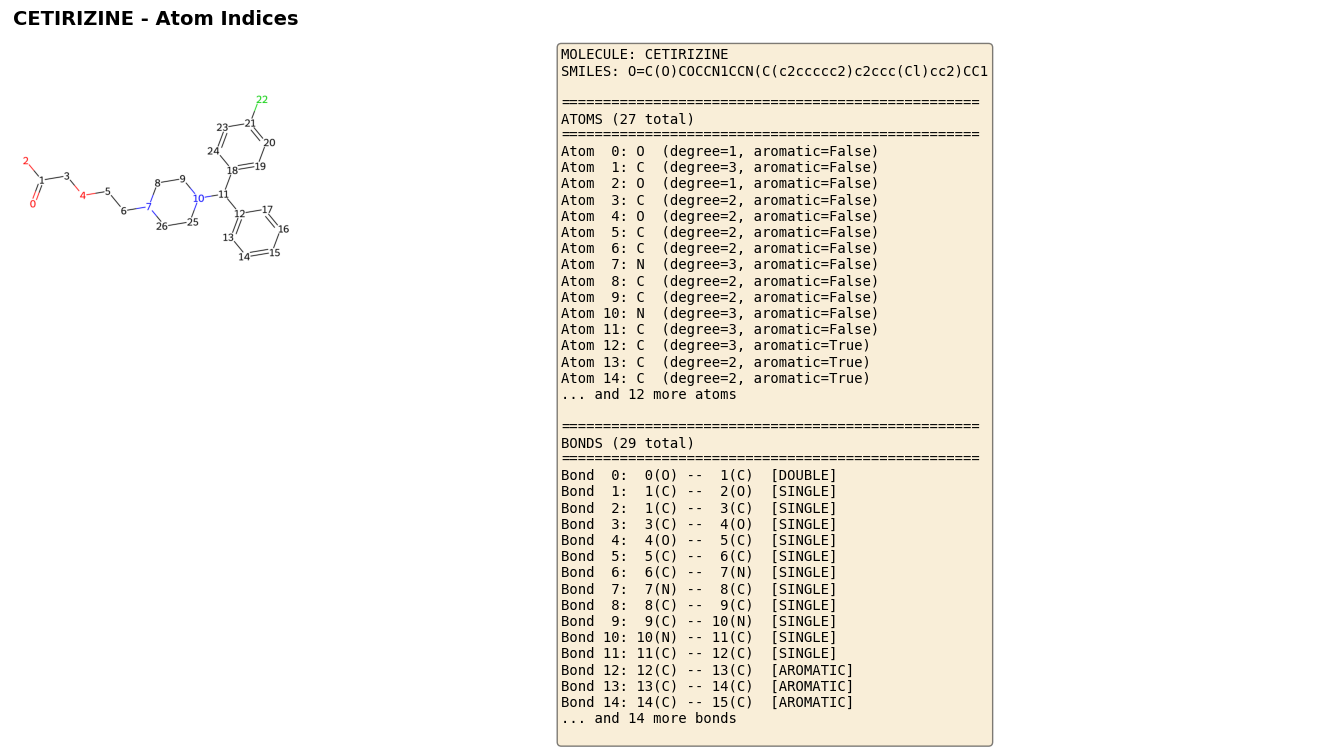


VISUALIZATION COMPLETE!

Now you can see:
  - Atom indices (numbers on the structure)
  - Which atoms connect to which
  - Bond types (SINGLE, DOUBLE, AROMATIC)


In [5]:
from rdkit import Chem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt

print("="*80)
print("VISUALIZING MOLECULE WITH ATOM LABELS")
print("="*80)

# Get the sample drug molecule
sample_drug = drug_nodes.iloc[0]
smiles = sample_drug['smile']
mol = Chem.MolFromSmiles(smiles)

print(f"\nDrug: {sample_drug['drug_name']}")
print(f"SMILES: {smiles}")
print(f"Atoms: {mol.GetNumAtoms()}, Bonds: {mol.GetNumBonds()}")

# Draw molecule with atom indices labeled
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: Molecule with atom indices
img1 = Draw.MolToImage(mol, size=(600, 600), kekulize=True, wedgeBonds=True)
for atom in mol.GetAtoms():
    idx = atom.GetIdx()
    # Add atom index labels
    img1 = Draw.MolToImage(mol, size=(600, 600), kekulize=True, wedgeBonds=True)

# Use RDKit's built-in atom labeling
mol_with_indices = Chem.Mol(mol)
for atom in mol_with_indices.GetAtoms():
    atom.SetProp('atomLabel', str(atom.GetIdx()))

img_labeled = Draw.MolToImage(mol_with_indices, size=(700, 700))

ax1.imshow(img_labeled)
ax1.axis('off')
ax1.set_title(f'{sample_drug["drug_name"]} - Atom Indices', fontsize=14, fontweight='bold')

# Right: Show atom and bond info as text
info_text = f"MOLECULE: {sample_drug['drug_name']}\n"
info_text += f"SMILES: {smiles}\n\n"
info_text += f"{'='*50}\n"
info_text += f"ATOMS ({mol.GetNumAtoms()} total)\n"
info_text += f"{'='*50}\n"

for i, atom in enumerate(mol.GetAtoms()):
    if i < 15:  # Show first 15 atoms
        info_text += f"Atom {i:2d}: {atom.GetSymbol():2s} (degree={atom.GetDegree()}, aromatic={atom.GetIsAromatic()})\n"
    elif i == 15:
        info_text += f"... and {mol.GetNumAtoms() - 15} more atoms\n"

info_text += f"\n{'='*50}\n"
info_text += f"BONDS ({mol.GetNumBonds()} total)\n"
info_text += f"{'='*50}\n"

for i, bond in enumerate(mol.GetBonds()):
    if i < 15:  # Show first 15 bonds
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        info_text += f"Bond {i:2d}: {bond.GetBeginAtomIdx():2d}({atom1.GetSymbol()}) -- {bond.GetEndAtomIdx():2d}({atom2.GetSymbol()})  [{bond.GetBondType()}]\n"
    elif i == 15:
        info_text += f"... and {mol.GetNumBonds() - 15} more bonds\n"

ax2.text(0.05, 0.95, info_text, 
         transform=ax2.transAxes,
         fontsize=10,
         verticalalignment='top',
         fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax2.axis('off')

plt.tight_layout()
plt.savefig('molecule_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved molecule_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE!")
print("="*80)
print("\nNow you can see:")
print("  - Atom indices (numbers on the structure)")
print("  - Which atoms connect to which")
print("  - Bond types (SINGLE, DOUBLE, AROMATIC)")

In [6]:
from rdkit import Chem
import pandas as pd
import numpy as np
from tqdm import tqdm

print("="*80)
print("CONVERTING DRUG SMILES TO MOLECULAR GRAPHS")
print("="*80)

def smiles_to_graph(smiles):
    """
    Convert a SMILES string to a molecular graph.
    
    Returns:
        nodes: List of atom dictionaries with features
        edges: List of bond dictionaries (source, target, bond_type)
    """
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None, None
    
    # Extract atom nodes
    nodes = []
    for atom in mol.GetAtoms():
        nodes.append({
            "id": atom.GetIdx(),
            "symbol": atom.GetSymbol(),
            "atomic_num": atom.GetAtomicNum(),
            "degree": atom.GetDegree(),
            "formal_charge": atom.GetFormalCharge(),
            "is_aromatic": atom.GetIsAromatic(),
            "hybridization": str(atom.GetHybridization()),
            "num_hs": atom.GetTotalNumHs()
        })
    
    # Extract bond edges (undirected)
    edges = []
    for bond in mol.GetBonds():
        bond_type = str(bond.GetBondType())
        edges.append({
            "source": bond.GetBeginAtomIdx(),
            "target": bond.GetEndAtomIdx(),
            "bond_type": bond_type
        })
    
    return nodes, edges

# Process all drugs
print(f"\nProcessing {len(drug_nodes)} drugs...")

drug_graphs = []
failed_drugs = []

for idx, row in tqdm(drug_nodes.iterrows(), total=len(drug_nodes), desc="Converting SMILES"):
    drug_internal_id = row['drug_internal_id']
    drug_id = row['drug_id']
    drug_name = row.get('drug_name', 'Unknown')
    smiles = row['smile']
    
    # Convert SMILES to graph
    nodes, edges = smiles_to_graph(smiles)
    
    if nodes is None:
        failed_drugs.append({
            'drug_internal_id': drug_internal_id,
            'drug_id': drug_id,
            'drug_name': drug_name,
            'smiles': smiles
        })
        continue
    
    drug_graphs.append({
        'drug_internal_id': drug_internal_id,
        'drug_id': drug_id,
        'drug_name': drug_name,
        'smiles': smiles,
        'num_atoms': len(nodes),
        'num_bonds': len(edges),
        'nodes': nodes,
        'edges': edges
    })

print(f"\n✓ Successfully processed: {len(drug_graphs)} drugs")
print(f"✗ Failed to parse: {len(failed_drugs)} drugs")

# Create summary statistics
print("\n" + "="*80)
print("MOLECULAR GRAPH STATISTICS")
print("="*80)

num_atoms_list = [d['num_atoms'] for d in drug_graphs]
num_bonds_list = [d['num_bonds'] for d in drug_graphs]

print(f"\nNumber of atoms per drug:")
print(f"  Min:    {min(num_atoms_list)}")
print(f"  Max:    {max(num_atoms_list)}")
print(f"  Mean:   {np.mean(num_atoms_list):.1f}")
print(f"  Median: {np.median(num_atoms_list):.1f}")

print(f"\nNumber of bonds per drug:")
print(f"  Min:    {min(num_bonds_list)}")
print(f"  Max:    {max(num_bonds_list)}")
print(f"  Mean:   {np.mean(num_bonds_list):.1f}")
print(f"  Median: {np.median(num_bonds_list):.1f}")

# Bond type distribution
bond_types = []
for d in drug_graphs:
    for edge in d['edges']:
        bond_types.append(edge['bond_type'])

bond_type_counts = pd.Series(bond_types).value_counts()
print(f"\nBond type distribution:")
for bond_type, count in bond_type_counts.items():
    print(f"  {bond_type}: {count:,} ({count/len(bond_types)*100:.1f}%)")

# Atom type distribution
atom_types = []
for d in drug_graphs:
    for node in d['nodes']:
        atom_types.append(node['symbol'])

atom_type_counts = pd.Series(atom_types).value_counts()
print(f"\nTop 10 most common atoms:")
for atom_type, count in atom_type_counts.head(10).items():
    print(f"  {atom_type}: {count:,} ({count/len(atom_types)*100:.1f}%)")

# Save results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)


# Example: Show first 3 drug graphs
print("\n" + "="*80)
print("EXAMPLE MOLECULAR GRAPHS (First 3 drugs)")
print("="*80)

for i, drug in enumerate(drug_graphs[:3], 1):
    print(f"\n{i}. {drug['drug_name']} ({drug['drug_id']})")
    print(f"   SMILES: {drug['smiles']}")
    print(f"   Atoms: {drug['num_atoms']}, Bonds: {drug['num_bonds']}")
    
    print(f"\n   Nodes (atoms):")
    for node in drug['nodes'][:5]:  # Show first 5 atoms
        print(f"     {node['id']}: {node['symbol']} (atomic_num={node['atomic_num']}, degree={node['degree']})")
    if len(drug['nodes']) > 5:
        print(f"     ... and {len(drug['nodes']) - 5} more atoms")
    
    print(f"\n   Edges (bonds):")
    for edge in drug['edges'][:5]:  # Show first 5 bonds
        print(f"     {edge['source']} -- {edge['target']} ({edge['bond_type']})")
    if len(drug['edges']) > 5:
        print(f"     ... and {len(drug['edges']) - 5} more bonds")

print("\n" + "="*80)
print("🎉 CONVERSION COMPLETE!")
print("="*80)

CONVERTING DRUG SMILES TO MOLECULAR GRAPHS

Processing 3127 drugs...


Converting SMILES:  71%|███████   | 2218/3127 [00:00<00:00, 4958.91it/s][23:55:50] WARNING: not removing hydrogen atom without neighbors
[23:55:50] WARNING: not removing hydrogen atom without neighbors
[23:55:50] WARNING: not removing hydrogen atom without neighbors
[23:55:50] WARNING: not removing hydrogen atom without neighbors
Converting SMILES: 100%|██████████| 3127/3127 [00:00<00:00, 5054.00it/s]



✓ Successfully processed: 3127 drugs
✗ Failed to parse: 0 drugs

MOLECULAR GRAPH STATISTICS

Number of atoms per drug:
  Min:    1
  Max:    200
  Mean:   27.6
  Median: 25.0

Number of bonds per drug:
  Min:    0
  Max:    210
  Mean:   29.0
  Median: 27.0

Bond type distribution:
  SINGLE: 53,356 (58.9%)
  AROMATIC: 30,161 (33.3%)
  DOUBLE: 6,908 (7.6%)
  TRIPLE: 152 (0.2%)

Top 10 most common atoms:
  C: 60,903 (70.6%)
  O: 13,321 (15.5%)
  N: 7,879 (9.1%)
  Cl: 1,106 (1.3%)
  S: 1,040 (1.2%)
  F: 1,028 (1.2%)
  Na: 273 (0.3%)
  I: 228 (0.3%)
  P: 158 (0.2%)
  Br: 101 (0.1%)

SAVING RESULTS

EXAMPLE MOLECULAR GRAPHS (First 3 drugs)

1. CETIRIZINE (CHEMBL1000)
   SMILES: O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1
   Atoms: 27, Bonds: 29

   Nodes (atoms):
     0: O (atomic_num=8, degree=1)
     1: C (atomic_num=6, degree=3)
     2: O (atomic_num=8, degree=1)
     3: C (atomic_num=6, degree=2)
     4: O (atomic_num=8, degree=2)
     ... and 22 more atoms

   Edges (bonds):
     0 --

In [7]:
from collections import Counter
import pandas as pd

print("="*80)
print("COMPREHENSIVE ANALYSIS: ALL ATOM & BOND FEATURES")
print("="*80)

# Collect ALL features from atoms and bonds
atom_symbols = []
atom_degrees = []
atom_formal_charges = []
atom_is_aromatic = []
atom_hybridizations = []
atom_num_hs = []

bond_types = []

for drug in drug_graphs:
    # Collect ALL atom features
    for node in drug['nodes']:
        atom_symbols.append(node['symbol'])
        atom_degrees.append(node['degree'])
        atom_formal_charges.append(node['formal_charge'])
        atom_is_aromatic.append(node['is_aromatic'])
        atom_hybridizations.append(node['hybridization'])
        atom_num_hs.append(node['num_hs'])
    
    # Collect bond types
    for edge in drug['edges']:
        bond_types.append(edge['bond_type'])

# Count unique values
print("\n" + "="*80)
print("1️⃣  ATOM FEATURES")
print("="*80)

print(f"\n📊 Symbol (atom type):")
symbol_counts = Counter(atom_symbols)
print(f"   Total unique: {len(symbol_counts)}")
print(f"   Values: {sorted(symbol_counts.keys())}")
for symbol, count in sorted(symbol_counts.items(), key=lambda x: -x[1]):
    print(f"      {symbol:3s}: {count:6,} atoms ({count/len(atom_symbols)*100:.1f}%)")

print(f"\n📊 Degree (number of bonds):")
degree_counts = Counter(atom_degrees)
print(f"   Total unique: {len(degree_counts)}")
print(f"   Values: {sorted(degree_counts.keys())}")
for deg, count in sorted(degree_counts.items()):
    print(f"      {deg}: {count:,} atoms ({count/len(atom_degrees)*100:.1f}%)")

print(f"\n📊 Formal Charge:")
charge_counts = Counter(atom_formal_charges)
print(f"   Total unique: {len(charge_counts)}")
print(f"   Values: {sorted(charge_counts.keys())}")
for charge, count in sorted(charge_counts.items()):
    print(f"      {charge:+d}: {count:,} atoms ({count/len(atom_formal_charges)*100:.1f}%)")

print(f"\n📊 Is Aromatic:")
aromatic_counts = Counter(atom_is_aromatic)
print(f"   Total unique: {len(aromatic_counts)}")
for val, count in aromatic_counts.items():
    print(f"      {val}: {count:,} atoms ({count/len(atom_is_aromatic)*100:.1f}%)")

print(f"\n📊 Hybridization:")
hybrid_counts = Counter(atom_hybridizations)
print(f"   Total unique: {len(hybrid_counts)}")
print(f"   Values: {sorted(hybrid_counts.keys())}")
for hybrid, count in sorted(hybrid_counts.items(), key=lambda x: -x[1]):
    print(f"      {hybrid:10s}: {count:,} atoms ({count/len(atom_hybridizations)*100:.1f}%)")

print(f"\n📊 Number of Hydrogens:")
hs_counts = Counter(atom_num_hs)
print(f"   Total unique: {len(hs_counts)}")
print(f"   Values: {sorted(hs_counts.keys())}")
for hs, count in sorted(hs_counts.items()):
    print(f"      {hs}: {count:,} atoms ({count/len(atom_num_hs)*100:.1f}%)")

print("\n" + "="*80)
print("2️⃣  BOND FEATURES")
print("="*80)

print(f"\n📊 Bond Type:")
bond_counts = Counter(bond_types)
print(f"   Total unique: {len(bond_counts)}")
print(f"   Values: {sorted(bond_counts.keys())}")
for bond, count in sorted(bond_counts.items(), key=lambda x: -x[1]):
    print(f"      {bond:10s}: {count:,} bonds ({count/len(bond_types)*100:.1f}%)")

print("\n" + "="*80)
print("📋 SUMMARY FOR ONE-HOT ENCODING")
print("="*80)

print(f"\n✅ ATOM FEATURES TO ENCODE:")
print(f"   1. Symbol:         {len(symbol_counts):2d} unique values -> {len(symbol_counts):3d} dimensions")
print(f"   2. Degree:         {len(degree_counts):2d} unique values -> {len(degree_counts):3d} dimensions")
print(f"   3. Formal Charge:  {len(charge_counts):2d} unique values -> {len(charge_counts):3d} dimensions")
print(f"   4. Is Aromatic:    {len(aromatic_counts):2d} unique values -> {len(aromatic_counts):3d} dimensions")
print(f"   5. Hybridization:  {len(hybrid_counts):2d} unique values -> {len(hybrid_counts):3d} dimensions")
print(f"   6. Num Hydrogens:  {len(hs_counts):2d} unique values -> {len(hs_counts):3d} dimensions")

total_atom_features = (len(symbol_counts) + len(degree_counts) + 
                       len(charge_counts) + len(aromatic_counts) + 
                       len(hybrid_counts) + len(hs_counts))

print(f"\n   📊 Total ATOM embedding size: {total_atom_features} dimensions (one-hot)")

print(f"\n✅ BOND FEATURES TO ENCODE:")
print(f"   1. Bond Type:      {len(bond_counts):2d} unique values -> {len(bond_counts):3d} dimensions")

print(f"\n   📊 Total BOND embedding size: {len(bond_counts)} dimensions (one-hot)")

print("\n" + "="*80)
print("🎯 EMBEDDING BREAKDOWN")
print("="*80)
print(f"\nEach ATOM will be represented as a {total_atom_features}-dimensional vector")
print(f"Each BOND will be represented as a {len(bond_counts)}-dimensional vector")

print(f"\nExample for one drug molecule:")
sample_drug = drug_graphs[0]
print(f"  Drug: {sample_drug['drug_name']}")
print(f"  Atoms: {sample_drug['num_atoms']} x {total_atom_features} dims = {sample_drug['num_atoms'] * total_atom_features:,} values")
print(f"  Bonds: {sample_drug['num_bonds']} x {len(bond_counts)} dims = {sample_drug['num_bonds'] * len(bond_counts):,} values")

print("\n" + "="*80)
print("🎯 READY FOR ONE-HOT ENCODING!")
print("="*80)

COMPREHENSIVE ANALYSIS: ALL ATOM & BOND FEATURES

1️⃣  ATOM FEATURES

📊 Symbol (atom type):
   Total unique: 32
   Values: ['Ag', 'Al', 'As', 'B', 'Ba', 'Bi', 'Br', 'C', 'Ca', 'Cl', 'F', 'Ga', 'H', 'He', 'I', 'K', 'Kr', 'Li', 'Mg', 'N', 'Na', 'O', 'P', 'Ra', 'Rb', 'S', 'Se', 'Si', 'Sr', 'Xe', 'Yb', 'Zn']
      C  : 60,903 atoms (70.6%)
      O  : 13,321 atoms (15.5%)
      N  :  7,879 atoms (9.1%)
      Cl :  1,106 atoms (1.3%)
      S  :  1,040 atoms (1.2%)
      F  :  1,028 atoms (1.2%)
      Na :    273 atoms (0.3%)
      I  :    228 atoms (0.3%)
      P  :    158 atoms (0.2%)
      Br :    101 atoms (0.1%)
      K  :     35 atoms (0.0%)
      H  :     30 atoms (0.0%)
      Ca :     25 atoms (0.0%)
      Mg :     22 atoms (0.0%)
      Si :     14 atoms (0.0%)
      Li :      8 atoms (0.0%)
      Zn :      7 atoms (0.0%)
      Sr :      5 atoms (0.0%)
      B  :      5 atoms (0.0%)
      Se :      4 atoms (0.0%)
      Xe :      4 atoms (0.0%)
      As :      3 atoms (0.0%)
      Al :

In [ ]:
# Create feature mappings for one-hot encoding
atom_feature_mappings = {
    'symbol': {val: i for i, val in enumerate(sorted(symbol_counts.keys()))},
    'degree': {val: i for i, val in enumerate(sorted(degree_counts.keys()))},
    'formal_charge': {val: i for i, val in enumerate(sorted(charge_counts.keys()))},
    'is_aromatic': {val: i for i, val in enumerate(sorted(aromatic_counts.keys()))},
    'hybridization': {val: i for i, val in enumerate(sorted(hybrid_counts.keys()))},
    'num_hs': {val: i for i, val in enumerate(sorted(hs_counts.keys()))}
}

bond_feature_mappings = {
    'bond_type': {val: i for i, val in enumerate(sorted(bond_counts.keys()))}
}

# Calculate total dimensions
total_atom_dim = sum(len(mapping) for mapping in atom_feature_mappings.values())
total_bond_dim = len(bond_feature_mappings['bond_type'])

print(f"\n✅ Feature mappings created:")
print(f"   Total atom dimensions: {total_atom_dim}")
print(f"   Total bond dimensions: {total_bond_dim}")

def encode_atom(atom_node):
    """Convert atom features to one-hot encoded vector"""
    vector = np.zeros(total_atom_dim)
    offset = 0
    for feature_name, mapping in atom_feature_mappings.items():
        value = atom_node[feature_name]
        if value in mapping:
            idx = offset + mapping[value]
            vector[idx] = 1.0
        offset += len(mapping)
    return vector

def encode_bond(bond_edge):
    """Convert bond features to one-hot encoded vector"""
    vector = np.zeros(total_bond_dim)
    bond_type = bond_edge['bond_type']
    if bond_type in bond_feature_mappings['bond_type']:
        idx = bond_feature_mappings['bond_type'][bond_type]
        vector[idx] = 1.0
    return vector

# Test encoding
sample_drug = drug_graphs[0]
first_atom = sample_drug['nodes'][0]
first_bond = sample_drug['edges'][0]

encoded_atom = encode_atom(first_atom)
encoded_bond = encode_bond(first_bond)

print(f"\n✅ Test encoding successful!")
print(f"   Atom vector shape: {encoded_atom.shape}")
print(f"   Bond vector shape: {encoded_bond.shape}")

# Encode all drugs
for drug in drug_graphs:
    # Node features matrix
    if drug['nodes']:
        node_attr = np.vstack([encode_atom(n) for n in drug['nodes']])
    else:
        node_attr = np.zeros((0, total_atom_dim), dtype=float)

    # Bond features and connectivity
    if drug['edges']:
        bond_features = np.vstack([encode_bond(e) for e in drug['edges']])
        sources = [int(e['source']) for e in drug['edges']]
        targets = [int(e['target']) for e in drug['edges']]

        # Bidirectional edges
        edge_index = np.array([sources + targets, targets + sources], dtype=np.int64)
        edge_attr = np.vstack([bond_features, bond_features])
    else:
        edge_index = np.zeros((2, 0), dtype=np.int64)
        edge_attr = np.zeros((0, total_bond_dim), dtype=float)

    # Save to drug dict
    drug['node_attr'] = node_attr
    drug['edge_attr'] = edge_attr
    drug['edge_index'] = edge_index

# Example output
sample = drug_graphs[0]
print("\n" + "="*80)
print(f"EXAMPLE: {sample['drug_name']}")
print("="*80)
print(f"  node_attr shape:  {sample['node_attr'].shape}")
print(f"  edge_attr shape:  {sample['edge_attr'].shape}")
print(f"  edge_index shape: {sample['edge_index'].shape}")
print("="*80)


✅ Feature mappings created:
   Total atom dimensions: 57
   Total bond dimensions: 4

✅ Test encoding successful!
   Atom vector shape: (57,)
   Bond vector shape: (4,)

EXAMPLE: CETIRIZINE
  node_attr shape:  (27, 57)
  edge_attr shape:  (58, 4)
  edge_index shape: (2, 58)


In [ ]:
# Encode all drugs
for drug in drug_graphs:
    drug['encoded_atoms'] = [encode_atom(node) for node in drug['nodes']]
    drug['encoded_bonds'] = [encode_bond(edge) for edge in drug['edges']]

In [ ]:
drug_graph_embeddings = []

for drug in drug_graphs:
    clean_drug = {
        # Identifiers (for tracking)
        'drug_internal_id': drug['drug_internal_id'],
        'drug_id': drug['drug_id'],
        'drug_name': drug['drug_name'],
        
        # Graph structure - ALL the model needs
        'node_attr': drug['node_attr'],      # (num_atoms, 57)
        'edge_attr': drug['edge_attr'],      # (num_edges*2, 4)
        'edge_index': drug['edge_index']     # (2, num_edges*2)
    }
    
    drug_graph_embeddings.append(clean_drug)

print(f"\n✓ Created {len(drug_graph_embeddings)} minimal drug embeddings")

# Show example
drug_graph_embeddings


✓ Created 3127 minimal drug embeddings


[{'drug_internal_id': 111185,
  'drug_id': 'CHEMBL1000',
  'drug_name': 'CETIRIZINE',
  'node_attr': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 1., 0., 0.],
         ...,
         [0., 0., 0., ..., 1., 0., 0.],
         [0., 0., 0., ..., 0., 1., 0.],
         [0., 0., 0., ..., 0., 1., 0.]]),
  'edge_attr': array([[0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [1., 0., 0., 0.],
         [0., 0., 1., 0.],
         [1., 0., 0., 0.],
         [1

In [11]:
import torch
from torch_geometric.data import Data
from tqdm import tqdm

print("="*80)
print("CONVERTING DRUGS TO PYTORCH GEOMETRIC DATA OBJECTS")
print("="*80)

# Convert each drug to a PyG Data object
drug_pyg_objects = []

# Find the cell where you create drug_pyg_objects (around line 1730)
# REPLACE IT WITH THIS:

drug_pyg_objects = []
failed_drugs = []

for drug in tqdm(drug_graph_embeddings, desc="Creating PyG objects"):
    # Validate BEFORE converting to tensors
    node_attr = drug['node_attr']
    edge_attr = drug['edge_attr']
    edge_index = drug['edge_index']
    
    # Check for NaN/Inf
    if np.isnan(node_attr).any() or np.isinf(node_attr).any():
        failed_drugs.append((drug['drug_id'], 'NaN/Inf in node_attr'))
        continue
    
    if np.isnan(edge_attr).any() or np.isinf(edge_attr).any():
        failed_drugs.append((drug['drug_id'], 'NaN/Inf in edge_attr'))
        continue
    
    # Check edge indices are valid
    num_atoms = node_attr.shape[0]
    if (edge_index >= num_atoms).any() or (edge_index < 0).any():
        failed_drugs.append((drug['drug_id'], f'Invalid edge_index (max={edge_index.max()}, num_atoms={num_atoms})'))
        continue
    
    # Create PyG Data object (ON CPU)
    x = torch.FloatTensor(node_attr)
    edge_index = torch.LongTensor(edge_index)
    edge_attr = torch.FloatTensor(edge_attr)
    
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        drug_internal_id=drug['drug_internal_id'],
        drug_id=drug['drug_id'],
        drug_name=drug['drug_name']
    )
    
    drug_pyg_objects.append(data)

print(f"\n✓ Created {len(drug_pyg_objects)} valid PyG objects")
print(f"✗ Failed: {len(failed_drugs)} drugs")

if failed_drugs:
    print("\nFailed drugs:")
    for drug_id, reason in failed_drugs[:10]:
        print(f"  {drug_id}: {reason}")

# Show example
print("\n" + "="*80)
print(f"EXAMPLE: {drug_pyg_objects[0].drug_name}")
print("="*80)
print(f"  drug_internal_id: {drug_pyg_objects[0].drug_internal_id}")
print(f"  drug_id:          {drug_pyg_objects[0].drug_id}")
print(f"  drug_name:        {drug_pyg_objects[0].drug_name}")
print(f"  x (node features): {drug_pyg_objects[0].x.shape}")
print(f"  edge_index:        {drug_pyg_objects[0].edge_index.shape}")
print(f"  edge_attr:         {drug_pyg_objects[0].edge_attr.shape}")
print(f"  num_nodes:         {drug_pyg_objects[0].num_nodes}")
print(f"  num_edges:         {drug_pyg_objects[0].num_edges}")

print("\n💾 Sample node features (first atom):")
print(drug_pyg_objects[0].x[0])  # one-hot encoded features

print("\n💾 Sample edge_index (first 5 edges):")
print(drug_pyg_objects[0].edge_index[:, :5])

print("\n" + "="*80)
print("✅ READY FOR GNN MODELING!")
print("="*80)
print("\nEach drug is now a PyG Data object with:")
print("  • x:          node features (atom embeddings)")
print("  • edge_index: graph connectivity")
print("  • edge_attr:  edge features (bond types)")
print("  • metadata:   drug_internal_id, drug_id, drug_name")
print("\n🎯 Next: Build GNN model to encode these into embeddings!")

/home/joe/projects/pharmacology-graph/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CONVERTING DRUGS TO PYTORCH GEOMETRIC DATA OBJECTS


Creating PyG objects: 100%|██████████| 3127/3127 [00:00<00:00, 25076.55it/s]


✓ Created 3127 valid PyG objects
✗ Failed: 0 drugs

EXAMPLE: CETIRIZINE
  drug_internal_id: 111185
  drug_id:          CHEMBL1000
  drug_name:        CETIRIZINE
  x (node features): torch.Size([27, 57])
  edge_index:        torch.Size([2, 58])
  edge_attr:         torch.Size([58, 4])
  num_nodes:         27
  num_edges:         58

💾 Sample node features (first atom):
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1.,
        0., 0., 0.])

💾 Sample edge_index (first 5 edges):
tensor([[0, 1, 1, 3, 4],
        [1, 2, 3, 4, 5]])

✅ READY FOR GNN MODELING!

Each drug is now a PyG Data object with:
  • x:          node features (atom embeddings)
  • edge_index: graph connectivity
  • edge_attr:  edge features (bond types)
  • metadata:   drug_internal_id, drug_id, drug_name

🎯 Next: Build GNN model to en

In [12]:
drug_pyg_objects

[Data(x=[27, 57], edge_index=[2, 58], edge_attr=[58, 4], drug_internal_id=111185, drug_id='CHEMBL1000', drug_name='CETIRIZINE'),
 Data(x=[21, 57], edge_index=[2, 46], edge_attr=[46, 4], drug_internal_id=165474, drug_id='CHEMBL100116', drug_name='PENTAZOCINE'),
 Data(x=[17, 57], edge_index=[2, 34], edge_attr=[34, 4], drug_internal_id=111482, drug_id='CHEMBL1002', drug_name='LEVOSALBUTAMOL'),
 Data(x=[15, 57], edge_index=[2, 30], edge_attr=[30, 4], drug_internal_id=111491, drug_id='CHEMBL1003', drug_name='CLAVULANATE POTASSIUM'),
 Data(x=[20, 57], edge_index=[2, 42], edge_attr=[42, 4], drug_internal_id=111498, drug_id='CHEMBL1004', drug_name='DOXYLAMINE'),
 Data(x=[27, 57], edge_index=[2, 56], edge_attr=[56, 4], drug_internal_id=111871, drug_id='CHEMBL1005', drug_name='REMIFENTANIL'),
 Data(x=[12, 57], edge_index=[2, 22], edge_attr=[22, 4], drug_internal_id=112480, drug_id='CHEMBL1006', drug_name='AMIFOSTINE'),
 Data(x=[27, 57], edge_index=[2, 58], edge_attr=[58, 4], drug_internal_id=112

## Creating Protiens Objects 

In [13]:

print("="*80)
print("CONVERTING PROTEINS TO PYTORCH GEOMETRIC DATA OBJECTS")
print("="*80)

# Convert each protein to a PyG Data object
protein_pyg_objects = []

for idx, row in tqdm(protien_nodes.iterrows(), total=len(protien_nodes), desc="Creating PyG objects"):
    embedding_str = row['esm2_embedding']
    embedding = np.array(embedding_str)
    x = torch.FloatTensor(embedding).unsqueeze(0)  # Shape: (1, 1280)
    data = Data(
        x=x,  # node features (just one node per protein)
        protein_internal_id=int(row['protein_internal_id']),
        protein_id=str(row['protein_id']),
        protein_name=str(row['protein_name']),
        uniprot_id=str(row['uniprot_id']),
        sequence_length=int(row['sequence_length'])
    )
    
    protein_pyg_objects.append(data)

print(f"\n✓ Created {len(protein_pyg_objects)} PyTorch Geometric Data objects")

# Show example
print("\n" + "="*80)
print(f"EXAMPLE: {protein_pyg_objects[0].protein_name}")
print("="*80)
print(f"  protein_internal_id: {protein_pyg_objects[0].protein_internal_id}")
print(f"  protein_id:          {protein_pyg_objects[0].protein_id}")
print(f"  protein_name:        {protein_pyg_objects[0].protein_name}")
print(f"  uniprot_id:          {protein_pyg_objects[0].uniprot_id}")
print(f"  sequence_length:     {protein_pyg_objects[0].sequence_length}")
print(f"  x (embedding):       {protein_pyg_objects[0].x.shape}")

print("\n💾 Sample embedding (first 10 values):")
print(protein_pyg_objects[0].x[0, :10])



CONVERTING PROTEINS TO PYTORCH GEOMETRIC DATA OBJECTS


Creating PyG objects: 100%|██████████| 1156/1156 [00:00<00:00, 26138.51it/s]


✓ Created 1156 PyTorch Geometric Data objects

EXAMPLE: Maltase-glucoamylase
  protein_internal_id: 1
  protein_id:          CHEMBL2074
  protein_name:        Maltase-glucoamylase
  uniprot_id:          O43451
  sequence_length:     2753
  x (embedding):       torch.Size([1, 2560])

💾 Sample embedding (first 10 values):
tensor([ 0.0474,  0.0507, -0.0052, -0.0766, -0.0222, -0.0937, -0.0363,  0.0933,
         0.0464, -0.0282])


## creating effect objects

In [14]:
# Get unique effects from drug_effects
unique_effects = drug_effects[['effect_id', 'effect_name']].drop_duplicates()
print(f"\nTotal unique effects: {len(unique_effects)}")


Total unique effects: 1065


In [15]:


# Create simple embeddings for effects (we'll use one-hot encoding or learned embeddings later)
# For now, create random embeddings as placeholders
EFFECT_EMBEDDING_DIM = 32 # change if number of effects is bigger

effect_pyg_objects = []

for idx, row in tqdm(unique_effects.iterrows(), total=len(unique_effects), desc="Creating effect PyG objects"):
    effect_embedding = torch.randn(1, EFFECT_EMBEDDING_DIM)
    
    data = Data(
        x=effect_embedding,  # (1, 32)
        effect_id=str(row['effect_id']),
        effect_name=str(row['effect_name'])
    )
    
    effect_pyg_objects.append(data)

print(f"\n✓ Created {len(effect_pyg_objects)} effect PyG Data objects")

# Show example
print("\n" + "="*80)
print(f"EXAMPLE: {effect_pyg_objects[0].effect_name}")
print("="*80)
print(f"  effect_id:      {effect_pyg_objects[0].effect_id}")
print(f"  effect_name:    {effect_pyg_objects[0].effect_name}")
print(f"  x (embedding):  {effect_pyg_objects[0].x.shape}")

print("\n💾 Sample embedding (first 10 values):")
print(effect_pyg_objects[0].x[0, :10])

print("\n" + "="*80)
print("CREATING DRUG-EFFECT EDGE INDEX")
print("="*80)

# Create mappings: drug_internal_id -> index in drug_pyg_objects
drug_internal_id_to_idx = {}
for i, drug_data in enumerate(drug_pyg_objects):
    drug_internal_id_to_idx[drug_data.drug_internal_id] = i

# Create mappings: effect_id -> index in effect_pyg_objects
effect_id_to_idx = {}
for i, effect_data in enumerate(effect_pyg_objects):
    effect_id_to_idx[effect_data.effect_id] = i

print(f"\nDrug mapping: {len(drug_internal_id_to_idx)} drugs")
print(f"Effect mapping: {len(effect_id_to_idx)} effects")

# Create edge list: drug -> effect
drug_effect_edges = []
edge_attributes = []

for _, row in tqdm(drug_effects.iterrows(), total=len(drug_effects), desc="Creating drug-effect edges"):
    drug_internal_id = int(row['drug_internal_id'])
    effect_id = str(row['effect_id'])
    
    # Check if both exist in our mappings
    if drug_internal_id in drug_internal_id_to_idx and effect_id in effect_id_to_idx:
        drug_idx = drug_internal_id_to_idx[drug_internal_id]
        effect_idx = effect_id_to_idx[effect_id]
        
        # Add edge: drug -> effect
        drug_effect_edges.append([drug_idx, effect_idx])
        
        # Store edge attributes (indication_phase)
        edge_attributes.append({
            'indication_phase': float(row.get('indication_phase', 4.0)),
            'num_references': int(row.get('num_references', 1))
        })

# Convert to tensors
drug_effect_edge_index = torch.LongTensor(drug_effect_edges).t().contiguous()  # Shape: (2, num_edges)

print(f"\n✓ Created {drug_effect_edge_index.shape[1]} drug-effect edges")
print(f"  Edge index shape: {drug_effect_edge_index.shape}")

# Create edge attribute tensor
indication_phases = torch.FloatTensor([attr['indication_phase'] for attr in edge_attributes])
num_references = torch.FloatTensor([attr['num_references'] for attr in edge_attributes])

drug_effect_edge_attr = torch.stack([indication_phases, num_references], dim=1)  # Shape: (num_edges, 2)
print(f"  Edge attr shape: {drug_effect_edge_attr.shape}")

print("\n💾 Sample edges (first 5):")
print(f"  Edge index:\n{drug_effect_edge_index[:, :5]}")
print(f"  Edge attributes:\n{drug_effect_edge_attr[:5]}")

print("\n" + "="*80)
print("✅ DRUG-EFFECT GRAPH READY!")
print("="*80)
print("\nSummary:")
print(f"  • {len(drug_pyg_objects)} drug nodes (with molecular graphs)")
print(f"  • {len(effect_pyg_objects)} effect nodes (with embeddings)")
print(f"  • {drug_effect_edge_index.shape[1]} drug→effect edges")



Creating effect PyG objects: 100%|██████████| 1065/1065 [00:00<00:00, 51780.33it/s]



✓ Created 1065 effect PyG Data objects

EXAMPLE: Eye Manifestations
  effect_id:      D005132
  effect_name:    Eye Manifestations
  x (embedding):  torch.Size([1, 32])

💾 Sample embedding (first 10 values):
tensor([-0.3892, -0.8572, -2.0186,  1.6734,  0.2494,  1.0171, -0.1091,  0.0894,
         2.4531, -1.6065])

CREATING DRUG-EFFECT EDGE INDEX

Drug mapping: 3127 drugs
Effect mapping: 1065 effects


Creating drug-effect edges: 100%|██████████| 8312/8312 [00:00<00:00, 93215.73it/s]


✓ Created 6496 drug-effect edges
  Edge index shape: torch.Size([2, 6496])
  Edge attr shape: torch.Size([6496, 2])

💾 Sample edges (first 5):
  Edge index:
tensor([[0, 0, 1, 3, 3],
        [0, 1, 2, 3, 4]])
  Edge attributes:
tensor([[4., 1.],
        [4., 1.],
        [4., 1.],
        [4., 1.],
        [4., 1.]])

✅ DRUG-EFFECT GRAPH READY!

Summary:
  • 3127 drug nodes (with molecular graphs)
  • 1065 effect nodes (with embeddings)
  • 6496 drug→effect edges


In [16]:
print("="*80)
print("CREATING COMPREHENSIVE NODE & EDGE MAPPINGS")
print("="*80)

# Save all mappings for future use
graph_data = {
    # Nodes
    'drug_pyg_objects': drug_pyg_objects,
    'effect_pyg_objects': effect_pyg_objects,
    'protein_pyg_objects': protein_pyg_objects,  # Already created
    
    # Node mappings
    'drug_internal_id_to_idx': drug_internal_id_to_idx,
    'effect_id_to_idx': effect_id_to_idx,
    
    # Edges: Drug → Effect
    'drug_effect_edge_index': drug_effect_edge_index,
    'drug_effect_edge_attr': drug_effect_edge_attr,
    
    # Metadata
    'num_drugs': len(drug_pyg_objects),
    'num_effects': len(effect_pyg_objects),
    'num_proteins': len(protein_pyg_objects),
    'num_drug_effect_edges': drug_effect_edge_index.shape[1]
}

print("\n✅ Graph data structure created:")
print(f"  Drugs:           {graph_data['num_drugs']:,}")
print(f"  Effects:         {graph_data['num_effects']:,}")
print(f"  Proteins:        {graph_data['num_proteins']:,}")
print(f"  Drug→Effect:     {graph_data['num_drug_effect_edges']:,}")

# Save to disk
torch.save(graph_data, 'pharmacology_graph_data.pt')
print("\n✓ Saved to: pharmacology_graph_data.pt")

print("\n" + "="*80)
print("READY FOR NEXT STEP: Drug→Protein Edges")
print("="*80)

CREATING COMPREHENSIVE NODE & EDGE MAPPINGS

✅ Graph data structure created:
  Drugs:           3,127
  Effects:         1,065
  Proteins:        1,156
  Drug→Effect:     6,496

✓ Saved to: pharmacology_graph_data.pt

READY FOR NEXT STEP: Drug→Protein Edges


## creating drugs --> protiens bindings edges

In [16]:
edges_drug_protein = drugs_interactions[[
    'drug_internal_id', 
    'protein_id', 
    'pchembl_max',
    'pchembl_avg', 
    'num_measurements'
]].copy()

In [17]:

protein_id_to_idx = {}
for i, protein_data in enumerate(protein_pyg_objects):
    protein_id_to_idx[protein_data.protein_id] = i

print(f"\nNode mappings:")
print(f"  Drug mapping:    {len(drug_internal_id_to_idx)} drugs")
print(f"  Protein mapping: {len(protein_id_to_idx)} proteins")

# Create edge list: drug -> protein
drug_protein_edges = []
edge_attributes = []

print(f"\nProcessing {len(edges_drug_protein)} drug-protein interactions...")

for _, row in tqdm(edges_drug_protein.iterrows(), total=len(edges_drug_protein), desc="Creating drug-protein edges"):
    drug_internal_id = int(row['drug_internal_id'])
    protein_id = str(row['protein_id'])
    
    # Check if both exist in our mappings
    if drug_internal_id in drug_internal_id_to_idx and protein_id in protein_id_to_idx:
        drug_idx = drug_internal_id_to_idx[drug_internal_id]
        protein_idx = protein_id_to_idx[protein_id]
        
        # Add edge: drug -> protein
        drug_protein_edges.append([drug_idx, protein_idx])
        
        # Store edge attributes (binding strength)
        edge_attributes.append({
            'pchembl_max': float(row.get('pchembl_max', 0.0)),
            'pchembl_avg': float(row.get('pchembl_avg', 0.0)),
            'num_measurements': int(row.get('num_measurements', 1))
        })

# Convert to tensors
drug_protein_edge_index = torch.LongTensor(drug_protein_edges).t().contiguous()  # Shape: (2, num_edges)

print(f"\n✓ Created {drug_protein_edge_index.shape[1]} drug-protein edges")
print(f"  Edge index shape: {drug_protein_edge_index.shape}")

# Create edge attribute tensor
pchembl_max = torch.FloatTensor([attr['pchembl_max'] for attr in edge_attributes])
pchembl_avg = torch.FloatTensor([attr['pchembl_avg'] for attr in edge_attributes])
num_measurements = torch.FloatTensor([attr['num_measurements'] for attr in edge_attributes])

drug_protein_edge_attr = torch.stack([pchembl_max, pchembl_avg, num_measurements], dim=1)  # Shape: (num_edges, 3)
print(f"  Edge attr shape: {drug_protein_edge_attr.shape}")

print("\n💾 Sample edges (first 5):")
print(f"  Edge index:\n{drug_protein_edge_index[:, :5]}")
print(f"  Edge attributes (pchembl_max, pchembl_avg, num_measurements):\n{drug_protein_edge_attr[:5]}")

print("\n" + "="*80)
print("EDGE ATTRIBUTE STATISTICS")
print("="*80)

print(f"\npChEMBL Max (binding affinity):")
print(f"  Min:    {pchembl_max.min():.2f}")
print(f"  Max:    {pchembl_max.max():.2f}")
print(f"  Mean:   {pchembl_max.mean():.2f}")
print(f"  Median: {pchembl_max.median():.2f}")

print(f"\npChEMBL Avg:")
print(f"  Min:    {pchembl_avg.min():.2f}")
print(f"  Max:    {pchembl_avg.max():.2f}")
print(f"  Mean:   {pchembl_avg.mean():.2f}")
print(f"  Median: {pchembl_avg.median():.2f}")

print(f"\nNum Measurements:")
print(f"  Min:    {num_measurements.min():.0f}")
print(f"  Max:    {num_measurements.max():.0f}")
print(f"  Mean:   {num_measurements.mean():.1f}")
print(f"  Median: {num_measurements.median():.0f}")

print("\n" + "="*80)
print("✅ DRUG-PROTEIN EDGES READY!")
print("="*80)

# Update graph_data structure
graph_data['protein_id_to_idx'] = protein_id_to_idx
graph_data['drug_protein_edge_index'] = drug_protein_edge_index
graph_data['drug_protein_edge_attr'] = drug_protein_edge_attr
graph_data['num_drug_protein_edges'] = drug_protein_edge_index.shape[1]

print("\nUpdated graph data structure:")
print(f"  Drugs:             {graph_data['num_drugs']:,}")
print(f"  Proteins:          {graph_data['num_proteins']:,}")
print(f"  Effects:           {graph_data['num_effects']:,}")
print(f"  Drug→Protein:      {graph_data['num_drug_protein_edges']:,}")
print(f"  Drug→Effect:       {graph_data['num_drug_effect_edges']:,}")

# Save updated graph data
torch.save(graph_data, 'pharmacology_graph_data.pt')
print("\n✓ Saved updated graph to: pharmacology_graph_data.pt")

print("\n" + "="*80)
print("🎉 COMPLETE HETEROGENEOUS GRAPH STRUCTURE!")
print("="*80)
print("\nGraph Summary:")
print(f"  📊 NODES:")
print(f"     • {graph_data['num_drugs']:,} drugs (with molecular graphs)")
print(f"     • {graph_data['num_proteins']:,} proteins (with ESM2 embeddings)")
print(f"     • {graph_data['num_effects']:,} effects (with learned embeddings)")
print(f"\n  🔗 EDGES:")
print(f"     • {graph_data['num_drug_protein_edges']:,} drug→protein (binding strength)")
print(f"     • {graph_data['num_drug_effect_edges']:,} drug→effect (indication phase)")
print(f"\n  ✅ Ready for heterogeneous GNN training!")


Node mappings:
  Drug mapping:    3127 drugs
  Protein mapping: 1156 proteins

Processing 11703 drug-protein interactions...


Creating drug-protein edges: 100%|██████████| 11703/11703 [00:00<00:00, 34542.14it/s]



✓ Created 11493 drug-protein edges
  Edge index shape: torch.Size([2, 11493])
  Edge attr shape: torch.Size([11493, 3])

💾 Sample edges (first 5):
  Edge index:
tensor([[ 0,  0,  0,  1,  1],
        [75, 54, 59, 83, 77]])
  Edge attributes (pchembl_max, pchembl_avg, num_measurements):
tensor([[ 8.2300,  7.5000, 12.0000],
        [ 5.7300,  5.7300,  1.0000],
        [ 5.6700,  5.6700,  1.0000],
        [ 8.6600,  8.0600,  3.0000],
        [ 8.5700,  7.6500, 12.0000]])

EDGE ATTRIBUTE STATISTICS

pChEMBL Max (binding affinity):
  Min:    5.50
  Max:    11.34
  Mean:   6.83
  Median: 6.48

pChEMBL Avg:
  Min:    5.50
  Max:    10.87
  Mean:   6.64
  Median: 6.36

Num Measurements:
  Min:    1
  Max:    578
  Mean:   3.9
  Median: 1

✅ DRUG-PROTEIN EDGES READY!


NameError: name 'graph_data' is not defined

## Creating the graph itself

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, HGTConv, global_mean_pool, HeteroConv, GCNConv, SAGEConv
from torch_geometric.data import HeteroData, Batch, Data # Added Data for dummy graphs
import numpy as np
import os
from tqdm import tqdm

# Enable synchronous CUDA for better error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
DEVICE = "cpu"  # Start with CPU for safety

print("="*80)
print("BUILDING COMPLETE HETEROGENEOUS PHARMACOLOGY MODEL")
print("="*80)

# ============================================================================
# STEP 1: MOLECULAR GRAPH ENCODER (GAT for Drugs)
# ============================================================================

class DrugMolecularEncoder(nn.Module):
    """Encode drug molecular graphs using Graph Attention Networks"""
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim, output_dim, num_layers=3, heads=4):
        super(DrugMolecularEncoder, self).__init__()
        
        self.node_encoder = nn.Linear(node_feat_dim, hidden_dim)
        self.edge_encoder = nn.Linear(edge_feat_dim, hidden_dim)
        
        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = hidden_dim if i == 0 else hidden_dim * heads
            self.gat_layers.append(
                GATConv(in_dim, hidden_dim, heads=heads, edge_dim=hidden_dim, dropout=0.1)
            )
        
        self.output_proj = nn.Linear(hidden_dim * heads, output_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, batch_data):
        # Handle cases where batch might be empty or invalid
        if batch_data.x.numel() == 0:
            # Return a zero tensor of the correct shape
            return torch.zeros(batch_data.num_graphs, self.output_proj.out_features).to(batch_data.x.device)

        x = self.node_encoder(batch_data.x)
        edge_attr = self.edge_encoder(batch_data.edge_attr)
        
        for gat in self.gat_layers:
            x = gat(x, batch_data.edge_index, edge_attr=edge_attr)
            x = F.elu(x)
            x = self.dropout(x)
        
        # Global pooling to get drug-level embedding
        drug_emb = global_mean_pool(x, batch_data.batch)
        drug_emb = self.output_proj(drug_emb)
        
        return drug_emb

# ============================================================================
# STEP 2: HETEROGENEOUS GRAPH CONVOLUTION LAYERS
# ============================================================================

class HeteroGraphConvLayer(nn.Module):
    """One layer of heterogeneous graph convolution"""
    def __init__(self, hidden_dim, edge_types, aggr='mean'):
        super(HeteroGraphConvLayer, self).__init__()
        
        # Create a separate GNN for each edge type
        self.convs = nn.ModuleDict()
        for edge_type in edge_types:
            src_type, rel, dst_type = edge_type
            # Use SAGEConv for message passing
            self.convs[f"{src_type}_{rel}_{dst_type}"] = SAGEConv(
                (hidden_dim, hidden_dim), hidden_dim, aggr=aggr
            )
        
        self.layer_norm = nn.LayerNorm(hidden_dim)
        
    def forward(self, x_dict, edge_index_dict):
        """
        Args:
            x_dict: {'drug': tensor, 'protein': tensor, 'effect': tensor}
            edge_index_dict: {('drug', 'binds_to', 'protein'): tensor, ...}
        """
        out_dict = {}
        
        # Initialize output dictionary with empty lists for aggregation
        for node_type in x_dict.keys():
            out_dict[node_type] = []
        
        # Message passing for each edge type
        for edge_type, edge_index in edge_index_dict.items():
            src_type, rel, dst_type = edge_type
            conv_key = f"{src_type}_{rel}_{dst_type}"
            
            if conv_key in self.convs:
                # Get source and destination node features
                x_src = x_dict[src_type]
                x_dst = x_dict[dst_type]
                
                # Apply convolution
                out = self.convs[conv_key]((x_src, x_dst), edge_index)
                out_dict[dst_type].append(out)
        
        # Aggregate messages for each node type
        final_out_dict = {}
        for node_type in out_dict.keys():
            if len(out_dict[node_type]) > 0:
                # Mean aggregation + residual connection
                aggregated = torch.stack(out_dict[node_type]).mean(dim=0)
                final_out_dict[node_type] = self.layer_norm(aggregated + x_dict[node_type])
            else:
                # No incoming messages, just pass through original features
                final_out_dict[node_type] = x_dict[node_type]
        
        return final_out_dict

# ============================================================================
# STEP 3: COMPLETE PHARMACOLOGY MODEL
# ============================================================================

class PharmacologyHeteroGNN(nn.Module):
    """
    Complete heterogeneous GNN for pharmacology knowledge graph
    
    Architecture:
    1. Drug molecular encoder (GAT) → shared_dim
    2. Protein projection (ESM2 embeddings) → shared_dim
    3. Effect projection (learnable embeddings) → shared_dim
    4. Multiple heterogeneous graph conv layers
    5. Link prediction heads for drug-protein and drug-effect
    """
    def __init__(self, config):
        super(PharmacologyHeteroGNN, self).__init__()
        
        self.config = config
        shared_dim = config['shared_dim']
        
        # 1. Molecular graph encoder for drugs
        self.drug_molecular_encoder = DrugMolecularEncoder(
            node_feat_dim=config['drug_node_feat_dim'],
            edge_feat_dim=config['drug_edge_feat_dim'],
            hidden_dim=config['drug_hidden_dim'],
            output_dim=shared_dim,
            num_layers=config['drug_num_layers'],
            heads=config['drug_heads']
        )
        
        # 2. Projections for protein and effect features
        self.protein_proj = nn.Sequential(
            nn.Linear(config['protein_feat_dim'], shared_dim),
            nn.LayerNorm(shared_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.effect_proj = nn.Sequential(
            nn.Linear(config['effect_feat_dim'], shared_dim),
            nn.LayerNorm(shared_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        # 3. Heterogeneous graph convolution layers
        edge_types = [
            ('drug', 'binds_to', 'protein'),
            ('protein', 'rev_binds_to', 'drug'),
            ('drug', 'treats', 'effect'),
            ('effect', 'rev_treats', 'drug')
        ]
        
        self.hetero_layers = nn.ModuleList([
            HeteroGraphConvLayer(shared_dim, edge_types)
            for _ in range(config['num_hetero_layers'])
        ])
        
        # 4. Link prediction heads
        self.drug_protein_predictor = nn.Sequential(
            nn.Linear(shared_dim * 2, shared_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(shared_dim, 1)
        )
        
        self.drug_effect_predictor = nn.Sequential(
            nn.Linear(shared_dim * 2, shared_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(shared_dim, 1)
        )
    
    def forward(self, drug_batch, protein_features, effect_features, edge_index_dict):
        """
        Args:
            drug_batch: Batched molecular graphs
            protein_features: (num_proteins, protein_dim)
            effect_features: (num_effects, effect_dim)
            edge_index_dict: Dictionary of edge indices
        
        Returns:
            x_dict: Node embeddings for each type
        """
        # Encode drugs (molecular graphs)
        drug_emb = self.drug_molecular_encoder(drug_batch)
        
        # Project proteins and effects
        protein_emb = self.protein_proj(protein_features)
        effect_emb = self.effect_proj(effect_features)
        
        # Create node feature dictionary
        x_dict = {
            'drug': drug_emb,
            'protein': protein_emb,
            'effect': effect_emb
        }
        
        # Apply heterogeneous graph convolutions
        for hetero_layer in self.hetero_layers:
            x_dict = hetero_layer(x_dict, edge_index_dict)
            # Apply activation after each layer
            for node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
        
        return x_dict
    
    def predict_link(self, drug_emb, target_emb, link_type='protein'):
        """Predict link probability between drug and target"""
        combined = torch.cat([drug_emb, target_emb], dim=1)
        
        if link_type == 'protein':
            score = self.drug_protein_predictor(combined)
        else:
            score = self.drug_effect_predictor(combined)
        
        return torch.sigmoid(score)

# ============================================================================
# STEP 4: INITIALIZE MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 4: Initializing Complete Heterogeneous Model")
print("="*80)

config = {
    # Drug molecular encoder
    'drug_node_feat_dim': 57,
    'drug_edge_feat_dim': 4,
    'drug_hidden_dim': 128,
    'drug_num_layers': 3,
    'drug_heads': 4,
    
    # Feature dimensions
    'protein_feat_dim': 2560,
    'effect_feat_dim': 32,
    'shared_dim': 256,
    
    # Heterogeneous GNN
    'num_hetero_layers': 3,
}

model = PharmacologyHeteroGNN(config).to(DEVICE)

print(f"\n✓ Model initialized on {DEVICE}")
print(f"\nModel Architecture:")
print(f"  1. Drug Molecular Encoder (GAT): {config['drug_node_feat_dim']}-dim → {config['shared_dim']}-dim")
print(f"  2. Protein Projection: {config['protein_feat_dim']}-dim → {config['shared_dim']}-dim")
print(f"  3. Effect Projection: {config['effect_feat_dim']}-dim → {config['shared_dim']}-dim")
print(f"  4. Heterogeneous GNN: {config['num_hetero_layers']} layers of message passing")
print(f"  5. Link Prediction Heads: Drug-Protein & Drug-Effect")
print(f"\n  Total parameters: {sum(p.numel() for p in model.parameters()):,}")


# ============================================================================
# STEP 5: TEST FORWARD PASS (SELF-CONTAINED & END-TO-END)
# ============================================================================

print("\n" + "="*80)
print("STEP 5: Testing Full Forward Pass (End-to-End)")
print("="*80)

# 1. Define dummy data parameters
TEST_NUM_DRUGS = 10
TEST_NUM_PROTEINS = 50
TEST_NUM_EFFECTS = 20
TEST_NODES_PER_DRUG = 15
TEST_EDGES_PER_DRUG = 30

print(f"Creating self-contained test data:")
print(f"  Drugs: {TEST_NUM_DRUGS} (each with {TEST_NODES_PER_DRUG} nodes)")
print(f"  Proteins: {TEST_NUM_PROTEINS}")
print(f"  Effects: {TEST_NUM_EFFECTS}")

# 2. Create a dummy drug_batch (This is the crucial part)
# This simulates a batch of molecular graphs
data_list = []
for _ in range(TEST_NUM_DRUGS):
    # Create one random molecular graph
    x = torch.randn(TEST_NODES_PER_DRUG, config['drug_node_feat_dim'])
    edge_index = torch.randint(0, TEST_NODES_PER_DRUG, (2, TEST_EDGES_PER_DRUG))
    edge_attr = torch.randn(TEST_EDGES_PER_DRUG, config['drug_edge_feat_dim'])
    data_list.append(Data(x=x, edge_index=edge_index, edge_attr=edge_attr))

# Batch them together
drug_batch = Batch.from_data_list(data_list).to(DEVICE)

# 3. Create dummy protein and effect features
protein_features_tensor = torch.randn(TEST_NUM_PROTEINS, config['protein_feat_dim']).to(DEVICE)
effect_features_tensor = torch.randn(TEST_NUM_EFFECTS, config['effect_feat_dim']).to(DEVICE)

# 4. Create dummy heterogeneous edge indices
edge_index_dict = {
    # 100 random drug-protein links
    ('drug', 'binds_to', 'protein'): torch.stack([
        torch.randint(0, TEST_NUM_DRUGS, (100,)),
        torch.randint(0, TEST_NUM_PROTEINS, (100,))
    ]).to(DEVICE),
    # 100 random protein-drug links
    ('protein', 'rev_binds_to', 'drug'): torch.stack([
        torch.randint(0, TEST_NUM_PROTEINS, (100,)),
        torch.randint(0, TEST_NUM_DRUGS, (100,))
    ]).to(DEVICE),
    # 50 random drug-effect links
    ('drug', 'treats', 'effect'): torch.stack([
        torch.randint(0, TEST_NUM_DRUGS, (50,)),
        torch.randint(0, TEST_NUM_EFFECTS, (50,))
    ]).to(DEVICE),
    # 50 random effect-drug links
    ('effect', 'rev_treats', 'drug'): torch.stack([
        torch.randint(0, TEST_NUM_EFFECTS, (50,)),
        torch.randint(0, TEST_NUM_DRUGS, (50,))
    ]).to(DEVICE),
}

print(f"\n✓ Dummy data created on {DEVICE}.")

# 5. Execute the full model.forward() method
print("Calling model.forward(...)")
model.eval()
with torch.no_grad():
    x_dict = model(
        drug_batch, 
        protein_features_tensor, 
        effect_features_tensor, 
        edge_index_dict
    )

print(f"\n✓ Forward pass successful!")
print(f"\nOutput node embeddings:")
print(f"  Drug:    {x_dict['drug'].shape}  (Expected: [{TEST_NUM_DRUGS}, {config['shared_dim']}])")
print(f"  Protein: {x_dict['protein'].shape}  (Expected: [{TEST_NUM_PROTEINS}, {config['shared_dim']}])")
print(f"  Effect:  {x_dict['effect'].shape}  (Expected: [{TEST_NUM_EFFECTS}, {config['shared_dim']}])")

# 6. Test link prediction heads
drug_emb_sample = x_dict['drug'][0:2] # Get first 2 drugs
protein_emb_sample = x_dict['protein'][5:7] # Get 2 proteins
effect_emb_sample = x_dict['effect'][3:5] # Get 2 effects

with torch.no_grad():
    dp_link_prob = model.predict_link(drug_emb_sample, protein_emb_sample, link_type='protein')
    de_link_prob = model.predict_link(drug_emb_sample, effect_emb_sample, link_type='effect')
    
    print(f"\nTest link prediction (drug-protein):")
    print(f"  Input: {drug_emb_sample.shape} + {protein_emb_sample.shape}")
    print(f"  Output: {dp_link_prob.shape}, Values: {dp_link_prob.flatten().tolist()}")
    
    print(f"\nTest link prediction (drug-effect):")
    print(f"  Input: {drug_emb_sample.shape} + {effect_emb_sample.shape}")
    print(f"  Output: {de_link_prob.shape}, Values: {de_link_prob.flatten().tolist()}")

print("\n" + "="*80)
print("🎉 COMPLETE MODEL READY AND TESTED!")
print("="*80)
print("\n📊 Full Architecture (End-to-End Test Passed):")
print("  ✅ Dummy molecular graphs → GAT encoder → 256-dim")
print("  ✅ Dummy protein features → projection → 256-dim")
print("  ✅ Dummy effect features → projection → 256-dim")
print(f"  ✅ {config['num_hetero_layers']} layers of heterogeneous message passing")
print("  ✅ Link prediction heads for drug-protein and drug-effect")
print("\n🚀 Next: Implement training loop with link prediction loss!")

BUILDING COMPLETE HETEROGENEOUS PHARMACOLOGY MODEL

STEP 4: Initializing Complete Heterogeneous Model

✓ Model initialized on cpu

Model Architecture:
  1. Drug Molecular Encoder (GAT): 57-dim → 256-dim
  2. Protein Projection: 2560-dim → 256-dim
  3. Effect Projection: 32-dim → 256-dim
  4. Heterogeneous GNN: 3 layers of message passing
  5. Link Prediction Heads: Drug-Protein & Drug-Effect

  Total parameters: 3,437,698

STEP 5: Testing Full Forward Pass (End-to-End)
Creating self-contained test data:
  Drugs: 10 (each with 15 nodes)
  Proteins: 50
  Effects: 20

✓ Dummy data created on cpu.
Calling model.forward(...)

✓ Forward pass successful!

Output node embeddings:
  Drug:    torch.Size([10, 256])  (Expected: [10, 256])
  Protein: torch.Size([50, 256])  (Expected: [50, 256])
  Effect:  torch.Size([20, 256])  (Expected: [20, 256])

Test link prediction (drug-protein):
  Input: torch.Size([2, 256]) + torch.Size([2, 256])
  Output: torch.Size([2, 1]), Values: [0.4667902886867523, 0

In [19]:

# ============================================================================
# STEP 1: CREATE HETEROGENEOUS GRAPH DATA STRUCTURE
# ============================================================================

print("\n" + "="*80)
print("STEP 1: Creating Heterogeneous Graph (HeteroData)")
print("="*80)

hetero_data = HeteroData()

# --- Add Drug Nodes (each drug is a molecular graph) ---
print("\nAdding drug nodes...")
hetero_data['drug'].num_nodes = len(drug_pyg_objects)
print(f"✓ Added {len(drug_pyg_objects)} drug nodes (molecular graphs)")

# --- Add Protein Nodes (ESM2 embeddings) ---
print("\nAdding protein nodes...")
protein_features = []
for protein in protein_pyg_objects:
    protein_features.append(protein.x.squeeze(0))
hetero_data['protein'].x = torch.stack(protein_features)
print(f"✓ Added {len(protein_pyg_objects)} protein nodes with ESM2 embeddings")
print(f"  Protein feature shape: {hetero_data['protein'].x.shape}")

# --- Add Effect Nodes (learnable embeddings) ---
print("\nAdding effect nodes...")
effect_features = []
for effect in effect_pyg_objects:
    effect_features.append(effect.x.squeeze(0))
hetero_data['effect'].x = torch.stack(effect_features)
print(f"✓ Added {len(effect_pyg_objects)} effect nodes with learnable embeddings")
print(f"  Effect feature shape: {hetero_data['effect'].x.shape}")

# --- Add Edges ---
print("\nAdding edges...")
hetero_data['drug', 'binds_to', 'protein'].edge_index = drug_protein_edge_index
hetero_data['drug', 'binds_to', 'protein'].edge_attr = drug_protein_edge_attr

hetero_data['drug', 'treats', 'effect'].edge_index = drug_effect_edge_index
hetero_data['drug', 'treats', 'effect'].edge_attr = drug_effect_edge_attr

hetero_data['protein', 'rev_binds_to', 'drug'].edge_index = drug_protein_edge_index.flip(0)
hetero_data['protein', 'rev_binds_to', 'drug'].edge_attr = drug_protein_edge_attr

hetero_data['effect', 'rev_treats', 'drug'].edge_index = drug_effect_edge_index.flip(0)
hetero_data['effect', 'rev_treats', 'drug'].edge_attr = drug_effect_edge_attr

print("✓ Added all edges with reverse connections")

# ============================================================================
# STEP 2: BUILD MOLECULAR GRAPH ENCODER (GAT for Drugs)
# ============================================================================


STEP 1: Creating Heterogeneous Graph (HeteroData)

Adding drug nodes...
✓ Added 3127 drug nodes (molecular graphs)

Adding protein nodes...
✓ Added 1156 protein nodes with ESM2 embeddings
  Protein feature shape: torch.Size([1156, 2560])

Adding effect nodes...
✓ Added 1065 effect nodes with learnable embeddings
  Effect feature shape: torch.Size([1065, 32])

Adding edges...
✓ Added all edges with reverse connections


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Batch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


print("="*80)
print("PROPER TRAINING WITH TRAIN/VAL/TEST SPLIT - NO DATA LEAKAGE")
print("="*80)

# ============================================================================
# STEP 1: CREATE TRAIN/VAL/TEST SPLITS (BEFORE ANY TRAINING)
# ============================================================================

def split_edges(edge_index, train_ratio=0.8, val_ratio=0.1):
    """Split edges into train/val/test without leakage"""
    num_edges = edge_index.shape[1]
    perm = torch.randperm(num_edges)
    
    num_train = int(num_edges * train_ratio)
    num_val = int(num_edges * val_ratio)
    
    train_edges = edge_index[:, perm[:num_train]]
    val_edges = edge_index[:, perm[num_train:num_train+num_val]]
    test_edges = edge_index[:, perm[num_train+num_val:]]
    
    return train_edges, val_edges, test_edges

# Get original edges
orig_drug_protein = hetero_data['drug', 'binds_to', 'protein'].edge_index
orig_drug_effect = hetero_data['drug', 'treats', 'effect'].edge_index

# Split drug-protein edges
train_dp, val_dp, test_dp = split_edges(orig_drug_protein, train_ratio=0.8, val_ratio=0.1)

# Split drug-effect edges
train_de, val_de, test_de = split_edges(orig_drug_effect, train_ratio=0.8, val_ratio=0.1)

print(f"\n📊 Data Split:")
print(f"  Drug-Protein: {train_dp.shape[1]:,} train | {val_dp.shape[1]:,} val | {test_dp.shape[1]:,} test")
print(f"  Drug-Effect:  {train_de.shape[1]:,} train | {val_de.shape[1]:,} val | {test_de.shape[1]:,} test")

# ============================================================================
# STEP 2: CREATE TRAINING EDGE INDEX (ONLY TRAIN EDGES)
# ============================================================================

train_edge_index_dict = {
    ('drug', 'binds_to', 'protein'): train_dp.to(DEVICE),
    ('protein', 'rev_binds_to', 'drug'): train_dp.flip(0).to(DEVICE),
    ('drug', 'treats', 'effect'): train_de.to(DEVICE),
    ('effect', 'rev_treats', 'drug'): train_de.flip(0).to(DEVICE),
}

print("\n✓ Created training edge index (message passing will ONLY use train edges)")

# ============================================================================
# STEP 3: UPDATE TRAINING DATASETS
# ============================================================================

class LinkPredictionDataset:
    """Dataset for link prediction (only uses train edges)"""
    def __init__(self, edge_index, num_nodes, num_negatives=5):
        self.edge_index = edge_index
        self.num_nodes = num_nodes
        self.num_negatives = num_negatives
        self.num_edges = edge_index.shape[1]
        
    def __len__(self):
        return self.num_edges
    
    def __getitem__(self, idx):
        pos_src = self.edge_index[0, idx].item()
        pos_dst = self.edge_index[1, idx].item()
        
        neg_dsts = []
        for _ in range(self.num_negatives):
            neg_dst = np.random.randint(0, self.num_nodes)
            while neg_dst == pos_dst:
                neg_dst = np.random.randint(0, self.num_nodes)
            neg_dsts.append(neg_dst)
        
        return {
            'pos_src': pos_src,
            'pos_dst': pos_dst,
            'neg_dsts': neg_dsts
        }

# Create datasets (ONLY from train edges)
drug_protein_train_dataset = LinkPredictionDataset(
    train_dp, len(protein_pyg_objects), num_negatives=5
)
drug_effect_train_dataset = LinkPredictionDataset(
    train_de, len(effect_pyg_objects), num_negatives=5
)

print(f"\n✓ Created training datasets from train edges only")

# ============================================================================
# STEP 4: VALIDATION FUNCTION
# ============================================================================

def evaluate(model, val_drug_protein, val_drug_effect, neg_ratio=1):
    """Evaluate on validation set"""
    model.eval()
    
    # Encode drugs
    drug_embeddings = drug_sampler.get_all_embeddings(model, DEVICE)
    
    # Forward pass (using TRAIN edges only for message passing)
    with torch.no_grad():
        x_dict = {
            'drug': drug_embeddings,
            'protein': model.protein_proj(hetero_data['protein'].x),
            'effect': model.effect_proj(hetero_data['effect'].x)
        }
        
        for hetero_layer in model.hetero_layers:
            x_dict = hetero_layer(x_dict, train_edge_index_dict)  # Use train edges!
            for node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
    
    # Evaluate drug-protein
    pos_scores_dp = []
    for i in range(val_drug_protein.shape[1]):
        src = val_drug_protein[0, i]
        dst = val_drug_protein[1, i]
        score = model.predict_link(
            x_dict['drug'][src].unsqueeze(0),
            x_dict['protein'][dst].unsqueeze(0),
            link_type='protein'
        )
        pos_scores_dp.append(score.item())
    
    # Generate negatives for validation
    neg_scores_dp = []
    for i in range(val_drug_protein.shape[1]):
        src = val_drug_protein[0, i]
        neg_dst = np.random.randint(0, len(protein_pyg_objects))
        score = model.predict_link(
            x_dict['drug'][src].unsqueeze(0),
            x_dict['protein'][neg_dst].unsqueeze(0),
            link_type='protein'
        )
        neg_scores_dp.append(score.item())
    
    # Compute AUC
    from sklearn.metrics import roc_auc_score
    labels = [1]*len(pos_scores_dp) + [0]*len(neg_scores_dp)
    scores = pos_scores_dp + neg_scores_dp
    auc = roc_auc_score(labels, scores)
    
    return auc

# ============================================================================
# STEP 5: TRAINING LOOP WITH VALIDATION
# ============================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
DRUG_BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 200  # More epochs as requested
PATIENCE = 20  # Early stopping

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"  Device:          {DEVICE}")
print(f"  Batch size:      {BATCH_SIZE}")
print(f"  Learning rate:   {LEARNING_RATE}")
print(f"  Epochs:          {EPOCHS}")
print(f"  Early stopping:  {PATIENCE} epochs")

class DrugBatchSampler:
    """Sample batches of drugs for molecular graph encoding"""
    def __init__(self, drug_pyg_objects, batch_size=32):
        self.drug_pyg_objects = drug_pyg_objects
        self.batch_size = batch_size
        self.num_drugs = len(drug_pyg_objects)
        
    def get_batch(self, drug_indices):
        """Get a batch of drug molecular graphs"""
        drug_graphs = [self.drug_pyg_objects[i] for i in drug_indices]
        return Batch.from_data_list(drug_graphs)
    
    def get_all_embeddings(self, model, device):
        """Encode all drugs into embeddings (batch-wise for memory efficiency)"""
        model.eval()
        all_embeddings = []
        
        with torch.no_grad():
            for i in tqdm(range(0, self.num_drugs, self.batch_size), 
                         desc="Encoding drugs"):
                batch_indices = list(range(i, min(i + self.batch_size, self.num_drugs)))
                batch_data = self.get_batch(batch_indices).to(device)
                
                # Encode through GAT
                drug_embs = model.drug_molecular_encoder(batch_data)
                all_embeddings.append(drug_embs.cpu())
                
                # Clear GPU memory
                del batch_data
                if device == "cuda":
                    torch.cuda.empty_cache()
        
        # Concatenate all batches
        all_embeddings = torch.cat(all_embeddings, dim=0).to(device)
        return all_embeddings
    
model = model.to(DEVICE)
drug_sampler = DrugBatchSampler(drug_pyg_objects, batch_size=DRUG_BATCH_SIZE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.BCELoss()

train_losses = []
val_aucs = []
best_val_auc = 0
patience_counter = 0

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 80)
    
    # Training
    model.train()
    epoch_loss = train_epoch_with_gat(
        model, 
        hetero_data['protein'].x, 
        hetero_data['effect'].x, 
        train_edge_index_dict,  # Use train edges only!
        drug_protein_train_dataset,
        drug_effect_train_dataset,
        drug_sampler,
        BATCH_SIZE,
        DEVICE
    )
    
    train_losses.append(epoch_loss)
    
    # Validation
    if (epoch + 1) % 5 == 0:
        val_auc = evaluate(model, val_dp.to(DEVICE), val_de.to(DEVICE))
        val_aucs.append(val_auc)
        
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {epoch_loss:.4f} | Val AUC: {val_auc:.4f}")
        
        # Early stopping
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"  ✓ New best model saved!")
        else:
            patience_counter += 1
            
        if patience_counter >= PATIENCE // 5:
            print(f"\n⚠️  Early stopping triggered (no improvement for {patience_counter*5} epochs)")
            break
    else:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {epoch_loss:.4f}")

print("\n✓ Training complete!")
print(f"Best validation AUC: {best_val_auc:.4f}")

# ============================================================================
# STEP 6: FINAL EVALUATION ON TEST SET
# ============================================================================

print("\n" + "="*80)
print("FINAL EVALUATION ON TEST SET")
print("="*80)

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
test_auc = evaluate(model, test_dp.to(DEVICE), test_de.to(DEVICE))

print(f"\n📊 FINAL RESULTS:")
print(f"  Best Validation AUC: {best_val_auc:.4f}")
print(f"  Test AUC:            {test_auc:.4f}")

if abs(test_auc - best_val_auc) < 0.05:
    print("\n✅ Test performance matches validation - NO DATA LEAKAGE!")
else:
    print("\n⚠️  Large gap between val and test - investigate further")

PROPER TRAINING WITH TRAIN/VAL/TEST SPLIT - NO DATA LEAKAGE

📊 Data Split:
  Drug-Protein: 9,194 train | 1,149 val | 1,150 test
  Drug-Effect:  5,196 train | 649 val | 651 test

✓ Created training edge index (message passing will ONLY use train edges)

✓ Created training datasets from train edges only

TRAINING CONFIGURATION
  Device:          cuda
  Batch size:      256
  Learning rate:   0.001
  Epochs:          200
  Early stopping:  20 epochs

Epoch 1/200
--------------------------------------------------------------------------------


NameError: name 'train_epoch_with_gat' is not defined

## History

TRAINING WITH REAL MOLECULAR GRAPH ENCODER (GAT)

TRAINING CONFIGURATION (WITH GAT)
  Device:                 cuda
  Link prediction batch:  256
  Drug molecule batch:    16
  Learning rate:          0.001
  Epochs:                 100

STARTING TRAINING WITH MOLECULAR GRAPH ENCODER

Epoch 1/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 179.78it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.85it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.88it/s]


Epoch   1/100 | Loss: 0.2700

Epoch 2/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 228.04it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 97.01it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.97it/s]


Epoch   2/100 | Loss: 0.2408

Epoch 3/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 201.44it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 97.68it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.53it/s]


Epoch   3/100 | Loss: 0.2386

Epoch 4/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 184.65it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.50it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.94it/s]


Epoch   4/100 | Loss: 0.2537

Epoch 5/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 178.09it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.64it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.39it/s]


Epoch   5/100 | Loss: 0.2402

Epoch 6/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.13it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.40it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 86.38it/s]


Epoch   6/100 | Loss: 0.2447

Epoch 7/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 224.55it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.11it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.80it/s]


Epoch   7/100 | Loss: 0.2383

Epoch 8/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 194.30it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [-1:59:59<00:00, -33.61it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.70it/s]


Epoch   8/100 | Loss: 0.2294

Epoch 9/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 168.87it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.75it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.61it/s]


Epoch   9/100 | Loss: 0.2276

Epoch 10/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 175.82it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 87.74it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 69.77it/s]


Epoch  10/100 | Loss: 0.2226
  ✓ Saved checkpoint_epoch_10.pt

Epoch 11/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 159.19it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 84.06it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 83.31it/s]


Epoch  11/100 | Loss: 0.2270

Epoch 12/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 210.64it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.46it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.11it/s]


Epoch  12/100 | Loss: 0.2294

Epoch 13/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 196.74it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.89it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.88it/s]


Epoch  13/100 | Loss: 0.2358

Epoch 14/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 201.06it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 85.84it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 100.73it/s]


Epoch  14/100 | Loss: 0.2340

Epoch 15/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 184.91it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 83.75it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.51it/s]


Epoch  15/100 | Loss: 0.2198

Epoch 16/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 176.30it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.86it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 81.21it/s]


Epoch  16/100 | Loss: 0.2239

Epoch 17/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 183.08it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.73it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.95it/s]


Epoch  17/100 | Loss: 0.2253

Epoch 18/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 170.62it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.03it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.60it/s]


Epoch  18/100 | Loss: 0.2281

Epoch 19/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 170.14it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.09it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.49it/s]


Epoch  19/100 | Loss: 0.2243

Epoch 20/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 171.53it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 87.24it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.47it/s]


Epoch  20/100 | Loss: 0.2191
  ✓ Saved checkpoint_epoch_20.pt

Epoch 21/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 219.68it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.19it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 87.27it/s]


Epoch  21/100 | Loss: 0.2183

Epoch 22/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 195.71it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.22it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 85.26it/s]


Epoch  22/100 | Loss: 0.2256

Epoch 23/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 219.39it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.51it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.86it/s]


Epoch  23/100 | Loss: 0.2238

Epoch 24/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 173.23it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.10it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.65it/s]


Epoch  24/100 | Loss: 0.2048

Epoch 25/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 192.10it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 84.76it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.20it/s]


Epoch  25/100 | Loss: 0.2103

Epoch 26/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, -219.16it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.95it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 79.57it/s]


Epoch  26/100 | Loss: 0.2158

Epoch 27/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 178.00it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.40it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.55it/s]


Epoch  27/100 | Loss: 0.2122

Epoch 28/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 189.41it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 83.90it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.92it/s]


Epoch  28/100 | Loss: 0.2079

Epoch 29/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 218.03it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.61it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 88.63it/s]


Epoch  29/100 | Loss: 0.2157

Epoch 30/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 193.93it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.19it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 84.30it/s]


Epoch  30/100 | Loss: 0.2122
  ✓ Saved checkpoint_epoch_30.pt

Epoch 31/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.47it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 83.74it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.79it/s]


Epoch  31/100 | Loss: 0.2182

Epoch 32/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 171.37it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 85.08it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 91.80it/s]


Epoch  32/100 | Loss: 0.2106

Epoch 33/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 168.14it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.62it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 97.22it/s]


Epoch  33/100 | Loss: 0.2143

Epoch 34/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.39it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.12it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.82it/s]


Epoch  34/100 | Loss: 0.2088

Epoch 35/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.12it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.39it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.57it/s]


Epoch  35/100 | Loss: 0.2075

Epoch 36/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 199.72it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.47it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.33it/s]


Epoch  36/100 | Loss: 0.2021

Epoch 37/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 216.46it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.15it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.49it/s]


Epoch  37/100 | Loss: 0.2034

Epoch 38/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 185.32it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.10it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.65it/s]


Epoch  38/100 | Loss: 0.2049

Epoch 39/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 198.46it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 85.42it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 88.68it/s]


Epoch  39/100 | Loss: 0.2052

Epoch 40/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 195.34it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.00it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.31it/s]


Epoch  40/100 | Loss: 0.1983
  ✓ Saved checkpoint_epoch_40.pt

Epoch 41/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 191.91it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.86it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 97.72it/s] 


Epoch  41/100 | Loss: 0.1991

Epoch 42/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 175.26it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.03it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.63it/s]


Epoch  42/100 | Loss: 0.2022

Epoch 43/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.80it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.29it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.00it/s]


Epoch  43/100 | Loss: 0.2070

Epoch 44/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, -232.26it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.51it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.04it/s]


Epoch  44/100 | Loss: 0.1997

Epoch 45/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 200.70it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.25it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.66it/s]


Epoch  45/100 | Loss: 0.2008

Epoch 46/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 192.49it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.50it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.15it/s]


Epoch  46/100 | Loss: 0.2076

Epoch 47/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 218.32it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.71it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.96it/s]


Epoch  47/100 | Loss: 0.1973

Epoch 48/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 201.48it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.22it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.69it/s]


Epoch  48/100 | Loss: 0.1939

Epoch 49/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 188.21it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.54it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.01it/s]


Epoch  49/100 | Loss: 0.1993

Epoch 50/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.19it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.08it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.40it/s]


Epoch  50/100 | Loss: 0.1907
  ✓ Saved checkpoint_epoch_50.pt

Epoch 51/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 188.75it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.85it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.54it/s]


Epoch  51/100 | Loss: 0.1951

Epoch 52/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 227.10it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.85it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 99.82it/s]


Epoch  52/100 | Loss: 0.2028

Epoch 53/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 202.54it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.65it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 97.28it/s]


Epoch  53/100 | Loss: 0.1968

Epoch 54/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 184.46it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.17it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.29it/s]


Epoch  54/100 | Loss: 0.1873

Epoch 55/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 169.69it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.83it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 79.06it/s]


Epoch  55/100 | Loss: 0.1904

Epoch 56/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 160.89it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.71it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 89.44it/s]


Epoch  56/100 | Loss: 0.1858

Epoch 57/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 215.25it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.02it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.48it/s]


Epoch  57/100 | Loss: 0.1926

Epoch 58/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 196.92it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.18it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.93it/s]


Epoch  58/100 | Loss: 0.1854

Epoch 59/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 216.25it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.05it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 98.58it/s] 


Epoch  59/100 | Loss: 0.1773

Epoch 60/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.74it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.80it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 84.60it/s]


Epoch  60/100 | Loss: 0.1810
  ✓ Saved checkpoint_epoch_60.pt

Epoch 61/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 189.72it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.23it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.82it/s]


Epoch  61/100 | Loss: 0.1933

Epoch 62/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, -255.40it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.97it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 84.36it/s]


Epoch  62/100 | Loss: 0.1944

Epoch 63/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 186.42it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.10it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.14it/s]


Epoch  63/100 | Loss: 0.1894

Epoch 64/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 170.48it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.87it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.01it/s]


Epoch  64/100 | Loss: 0.1847

Epoch 65/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 185.50it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 97.96it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 97.23it/s]


Epoch  65/100 | Loss: 0.1778

Epoch 66/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 214.41it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.07it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 99.23it/s]


Epoch  66/100 | Loss: 0.1802

Epoch 67/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 224.74it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.06it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 96.19it/s]


Epoch  67/100 | Loss: 0.1806

Epoch 68/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 213.05it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 87.36it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 85.52it/s]


Epoch  68/100 | Loss: 0.1755

Epoch 69/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 167.59it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.08it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 85.37it/s]


Epoch  69/100 | Loss: 0.1727

Epoch 70/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 166.04it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.35it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 87.98it/s]


Epoch  70/100 | Loss: 0.1749
  ✓ Saved checkpoint_epoch_70.pt

Epoch 71/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 204.79it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.35it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.69it/s]


Epoch  71/100 | Loss: 0.1750

Epoch 72/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 218.91it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.90it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.65it/s]


Epoch  72/100 | Loss: 0.1731

Epoch 73/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 184.70it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.28it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.47it/s]


Epoch  73/100 | Loss: 0.1725

Epoch 74/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 211.17it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 97.43it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.77it/s]


Epoch  74/100 | Loss: 0.1730

Epoch 75/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 176.40it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.74it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.92it/s]


Epoch  75/100 | Loss: 0.1704

Epoch 76/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 203.59it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 90.99it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.79it/s]


Epoch  76/100 | Loss: 0.1752

Epoch 77/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 212.31it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.12it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 97.30it/s] 


Epoch  77/100 | Loss: 0.1752

Epoch 78/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 194.79it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 89.40it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 87.82it/s]


Epoch  78/100 | Loss: 0.1767

Epoch 79/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 208.85it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.75it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 97.27it/s]


Epoch  79/100 | Loss: 0.1737

Epoch 80/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, -205.69it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.02it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 94.80it/s]


Epoch  80/100 | Loss: 0.1667
  ✓ Saved checkpoint_epoch_80.pt

Epoch 81/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 197.66it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 86.88it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 74.14it/s]


Epoch  81/100 | Loss: 0.1712

Epoch 82/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 186.68it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 82.69it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 82.80it/s]


Epoch  82/100 | Loss: 0.1662

Epoch 83/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 172.84it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 83.55it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.36it/s]


Epoch  83/100 | Loss: 0.1700

Epoch 84/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 198.77it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.29it/s] 


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 95.18it/s]


Epoch  84/100 | Loss: 0.1803

Epoch 85/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 217.11it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.35it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 98.34it/s]


Epoch  85/100 | Loss: 0.1820

Epoch 86/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 225.58it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 97.68it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 100.19it/s]


Epoch  86/100 | Loss: 0.1702

Epoch 87/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 202.70it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.46it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 92.00it/s]


Epoch  87/100 | Loss: 0.1708

Epoch 88/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 181.56it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 88.93it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 86.49it/s]


Epoch  88/100 | Loss: 0.1700

Epoch 89/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 181.59it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.07it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.07it/s]


Epoch  89/100 | Loss: 0.1693

Epoch 90/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 194.84it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 87.93it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.92it/s]


Epoch  90/100 | Loss: 0.1689
  ✓ Saved checkpoint_epoch_90.pt

Epoch 91/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 180.37it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 91.61it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 90.07it/s]


Epoch  91/100 | Loss: 0.1648

Epoch 92/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 211.27it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 95.63it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.83it/s]


Epoch  92/100 | Loss: 0.1672

Epoch 93/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 212.31it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 96.65it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 106.72it/s]


Epoch  93/100 | Loss: 0.1646

Epoch 94/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 237.93it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 105.20it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 101.49it/s]


Epoch  94/100 | Loss: 0.1646

Epoch 95/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 210.86it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 102.01it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 105.66it/s]


Epoch  95/100 | Loss: 0.1632

Epoch 96/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 242.75it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 102.52it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 103.68it/s]


Epoch  96/100 | Loss: 0.1661

Epoch 97/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 196.60it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 92.59it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 98.74it/s] 


Epoch  97/100 | Loss: 0.1603

Epoch 98/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 188.55it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 93.80it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 93.20it/s]


Epoch  98/100 | Loss: 0.1601

Epoch 99/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, -236.80it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 94.68it/s]


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 91.79it/s]


Epoch  99/100 | Loss: 0.1571

Epoch 100/100
--------------------------------------------------------------------------------
  Encoding all drugs through GAT...


Encoding drugs: 100%|██████████| 196/196 [00:00<00:00, 207.07it/s]


  ✓ Encoded 3127 drugs
  Training on Drug-Protein edges...


  Drug-Protein: 100%|██████████| 45/45 [00:00<00:00, 98.40it/s] 


  Training on Drug-Effect edges...


  Drug-Effect: 100%|██████████| 26/26 [00:00<00:00, 101.99it/s]


Epoch 100/100 | Loss: 0.1642
  ✓ Saved checkpoint_epoch_100.pt

✓ Training complete!

VISUALIZING TRAINING
✓ Saved training_loss_with_gat.png


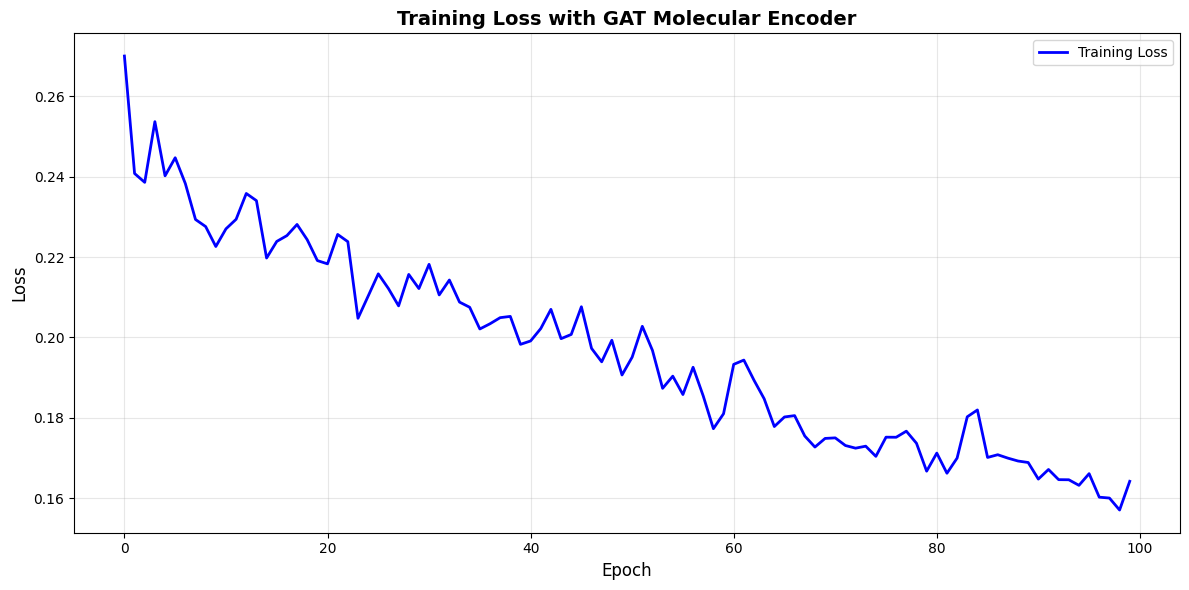


SAVING FINAL MODEL
✓ Saved pharmacology_hetero_gnn_with_gat.pt

🎉 TRAINING WITH GAT COMPLETE!

📊 Model Components:
  ✅ Drug molecular graphs encoded with GAT (3 layers, 4 heads)
  ✅ Protein ESM2 embeddings (2560-dim → 256-dim)
  ✅ Effect learnable embeddings (32-dim → 256-dim)
  ✅ Heterogeneous GNN (3 layers message passing)
  ✅ Link prediction heads (drug-protein, drug-effect)

🚀 Next Steps:
  1. Evaluate on validation set
  2. Compute AUC-ROC, Precision@k
  3. Make predictions on novel drug-target pairs
  4. Visualize learned drug embeddings


In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("="*80)
print("TRAINING WITH REAL MOLECULAR GRAPH ENCODER (GAT)")
print("="*80)

# ============================================================================
# STEP 1: DRUG BATCHING UTILITIES
# ============================================================================

class DrugBatchSampler:
    """Sample batches of drugs for molecular graph encoding"""
    def __init__(self, drug_pyg_objects, batch_size=32):
        self.drug_pyg_objects = drug_pyg_objects
        self.batch_size = batch_size
        self.num_drugs = len(drug_pyg_objects)
        
    def get_batch(self, drug_indices):
        """Get a batch of drug molecular graphs"""
        drug_graphs = [self.drug_pyg_objects[i] for i in drug_indices]
        return Batch.from_data_list(drug_graphs)
    
    def get_all_embeddings(self, model, device):
        """Encode all drugs into embeddings (batch-wise for memory efficiency)"""
        model.eval()
        all_embeddings = []
        
        with torch.no_grad():
            for i in tqdm(range(0, self.num_drugs, self.batch_size), 
                         desc="Encoding drugs"):
                batch_indices = list(range(i, min(i + self.batch_size, self.num_drugs)))
                batch_data = self.get_batch(batch_indices).to(device)
                
                # Encode through GAT
                drug_embs = model.drug_molecular_encoder(batch_data)
                all_embeddings.append(drug_embs.cpu())
                
                # Clear GPU memory
                del batch_data
                if device == "cuda":
                    torch.cuda.empty_cache()
        
        # Concatenate all batches
        all_embeddings = torch.cat(all_embeddings, dim=0).to(device)
        return all_embeddings

# ============================================================================
# STEP 2: UPDATED TRAINING CONFIGURATION
# ============================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256  # Link prediction batch size
DRUG_BATCH_SIZE = 16  # Molecular graph batch size (smaller due to GAT memory)
LEARNING_RATE = 0.001
EPOCHS = 100

print("\n" + "="*80)
print("TRAINING CONFIGURATION (WITH GAT)")
print("="*80)
print(f"  Device:                 {DEVICE}")
print(f"  Link prediction batch:  {BATCH_SIZE}")
print(f"  Drug molecule batch:    {DRUG_BATCH_SIZE}")
print(f"  Learning rate:          {LEARNING_RATE}")
print(f"  Epochs:                 {EPOCHS}")

# Create drug batch sampler
drug_sampler = DrugBatchSampler(drug_pyg_objects, batch_size=DRUG_BATCH_SIZE)

# Move model and data to device
model = model.to(DEVICE)
hetero_data = hetero_data.to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.BCELoss()

# ============================================================================
# STEP 3: UPDATED TRAINING FUNCTION (WITH GAT)
# ============================================================================

def train_epoch_with_gat(model, protein_features, effect_features, edge_index_dict, 
                         drug_protein_dataset, drug_effect_dataset, 
                         drug_sampler, batch_size, device):
    """Train for one epoch using real molecular graph encoding"""
    model.train()
    
    total_loss = 0
    num_batches = 0
    
    # Step 1: Encode ALL drugs using GAT (batch-wise)
    print("  Encoding all drugs through GAT...")
    drug_embeddings = drug_sampler.get_all_embeddings(model, device)
    print(f"  ✓ Encoded {drug_embeddings.shape[0]} drugs")
    
    # Step 2: Train on Drug-Protein edges
    print("  Training on Drug-Protein edges...")
    for i in tqdm(range(0, len(drug_protein_dataset), batch_size), 
                  desc="  Drug-Protein"):
        batch_indices = list(range(i, min(i + batch_size, len(drug_protein_dataset))))
        
        pos_srcs = []
        pos_dsts = []
        neg_srcs = []
        neg_dsts = []
        
        for idx in batch_indices:
            sample = drug_protein_dataset[idx]
            pos_srcs.append(sample['pos_src'])
            pos_dsts.append(sample['pos_dst'])
            
            for neg_dst in sample['neg_dsts']:
                neg_srcs.append(sample['pos_src'])
                neg_dsts.append(neg_dst)
        
        # Forward pass through heterogeneous GNN
        x_dict = {
            'drug': drug_embeddings,
            'protein': model.protein_proj(protein_features),
            'effect': model.effect_proj(effect_features)
        }
        
        for hetero_layer in model.hetero_layers:
            x_dict = hetero_layer(x_dict, edge_index_dict)
            for node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
        
        # Get embeddings for positive and negative pairs
        pos_drug_embs = x_dict['drug'][pos_srcs]
        pos_protein_embs = x_dict['protein'][pos_dsts]
        
        neg_drug_embs = x_dict['drug'][neg_srcs]
        neg_protein_embs = x_dict['protein'][neg_dsts]
        
        # Predict link probabilities
        pos_scores = model.predict_link(pos_drug_embs, pos_protein_embs, link_type='protein').squeeze()
        neg_scores = model.predict_link(neg_drug_embs, neg_protein_embs, link_type='protein').squeeze()
        
        # Create labels
        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)
        
        # Compute loss
        loss = criterion(pos_scores, pos_labels) + criterion(neg_scores, neg_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    # Step 3: Train on Drug-Effect edges
    print("  Training on Drug-Effect edges...")
    for i in tqdm(range(0, len(drug_effect_dataset), batch_size), 
                  desc="  Drug-Effect"):
        batch_indices = list(range(i, min(i + batch_size, len(drug_effect_dataset))))
        
        pos_srcs = []
        pos_dsts = []
        neg_srcs = []
        neg_dsts = []
        
        for idx in batch_indices:
            sample = drug_effect_dataset[idx]
            pos_srcs.append(sample['pos_src'])
            pos_dsts.append(sample['pos_dst'])
            
            for neg_dst in sample['neg_dsts']:
                neg_srcs.append(sample['pos_src'])
                neg_dsts.append(neg_dst)
        
        # Forward pass
        x_dict = {
            'drug': drug_embeddings,
            'protein': model.protein_proj(protein_features),
            'effect': model.effect_proj(effect_features)
        }
        
        for hetero_layer in model.hetero_layers:
            x_dict = hetero_layer(x_dict, edge_index_dict)
            for node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
        
        # Get embeddings
        pos_drug_embs = x_dict['drug'][pos_srcs]
        pos_effect_embs = x_dict['effect'][pos_dsts]
        
        neg_drug_embs = x_dict['drug'][neg_srcs]
        neg_effect_embs = x_dict['effect'][neg_dsts]
        
        # Predict
        pos_scores = model.predict_link(pos_drug_embs, pos_effect_embs, link_type='effect').squeeze()
        neg_scores = model.predict_link(neg_drug_embs, neg_effect_embs, link_type='effect').squeeze()
        
        # Labels
        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)
        
        # Loss
        loss = criterion(pos_scores, pos_labels) + criterion(neg_scores, neg_labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# ============================================================================
# STEP 4: TRAINING LOOP (WITH GAT)
# ============================================================================

print("\n" + "="*80)
print("STARTING TRAINING WITH MOLECULAR GRAPH ENCODER")
print("="*80)

protein_features_tensor = hetero_data['protein'].x
effect_features_tensor = hetero_data['effect'].x

edge_index_dict = {
    ('drug', 'binds_to', 'protein'): hetero_data['drug', 'binds_to', 'protein'].edge_index,
    ('protein', 'rev_binds_to', 'drug'): hetero_data['protein', 'rev_binds_to', 'drug'].edge_index,
    ('drug', 'treats', 'effect'): hetero_data['drug', 'treats', 'effect'].edge_index,
    ('effect', 'rev_treats', 'drug'): hetero_data['effect', 'rev_treats', 'drug'].edge_index,
}

losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print("-" * 80)
    
    epoch_loss = train_epoch_with_gat(
        model, 
        protein_features_tensor, 
        effect_features_tensor, 
        edge_index_dict,
        drug_protein_dataset,
        drug_effect_dataset,
        drug_sampler,
        BATCH_SIZE,
        DEVICE
    )
    
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {epoch_loss:.4f}")
    
    # Save checkpoint every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, f'checkpoint_epoch_{epoch+1}.pt')
        print(f"  ✓ Saved checkpoint_epoch_{epoch+1}.pt")

print("\n✓ Training complete!")

# ============================================================================
# STEP 5: VISUALIZE TRAINING
# ============================================================================

print("\n" + "="*80)
print("VISUALIZING TRAINING")
print("="*80)

plt.figure(figsize=(12, 6))
plt.plot(losses, linewidth=2, color='blue', label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss with GAT Molecular Encoder', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('training_loss_with_gat.png', dpi=300)
print("✓ Saved training_loss_with_gat.png")
plt.show()

# ============================================================================
# STEP 6: SAVE FINAL MODEL
# ============================================================================

print("\n" + "="*80)
print("SAVING FINAL MODEL")
print("="*80)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'losses': losses,
    'final_epoch': EPOCHS
}, 'pharmacology_hetero_gnn_with_gat.pt')

print("✓ Saved pharmacology_hetero_gnn_with_gat.pt")

print("\n" + "="*80)
print("🎉 TRAINING WITH GAT COMPLETE!")
print("="*80)
print("\n📊 Model Components:")
print("  ✅ Drug molecular graphs encoded with GAT (3 layers, 4 heads)")
print("  ✅ Protein ESM2 embeddings (2560-dim → 256-dim)")
print("  ✅ Effect learnable embeddings (32-dim → 256-dim)")
print("  ✅ Heterogeneous GNN (3 layers message passing)")
print("  ✅ Link prediction heads (drug-protein, drug-effect)")
print("\n🚀 Next Steps:")
print("  1. Evaluate on validation set")
print("  2. Compute AUC-ROC, Precision@k")
print("  3. Make predictions on novel drug-target pairs")
print("  4. Visualize learned drug embeddings")

MODEL EVALUATION: AUC-ROC, PRECISION, RECALL

📊 Data Split:
  Drug-Protein: 10,344 train | 1,149 test
  Drug-Effect:  5,847 train | 649 test

✓ Generated 1,149 negative drug-protein samples
✓ Generated 649 negative drug-effect samples

RUNNING INFERENCE ON TEST SET

Encoding drugs...


Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 107.96it/s]


Running heterogeneous GNN...
✓ Got final embeddings

COMPUTING PREDICTIONS
✓ Got 1,149 + 1,149 drug-protein predictions
✓ Got 649 + 649 drug-effect predictions

COMPUTING METRICS

📊 Drug-Protein Binding

🎯 AUC-ROC: 0.9187
🎯 AUC-PR:  0.9172

📈 Confusion Matrix:
   True Positives:  836
   True Negatives:  1,064
   False Positives: 85
   False Negatives: 313

📊 Classification Metrics:
   Accuracy:  0.8268
   Precision: 0.9077
   Recall:    0.7276
   F1-Score:  0.8077

📉 Score Distributions:
   Positive: μ=0.6921, σ=0.3847, min=0.0000, max=1.0000
   Negative: μ=0.0701, σ=0.2301, min=0.0000, max=0.9941

📊 Drug-Effect Clinical Outcome

🎯 AUC-ROC: 0.9347
🎯 AUC-PR:  0.9472

📈 Confusion Matrix:
   True Positives:  410
   True Negatives:  640
   False Positives: 9
   False Negatives: 239

📊 Classification Metrics:
   Accuracy:  0.8089
   Precision: 0.9785
   Recall:    0.6317
   F1-Score:  0.7678

📉 Score Distributions:
   Positive: μ=0.6067, σ=0.4342, min=0.0000, max=1.0000
   Negative: μ=0.013

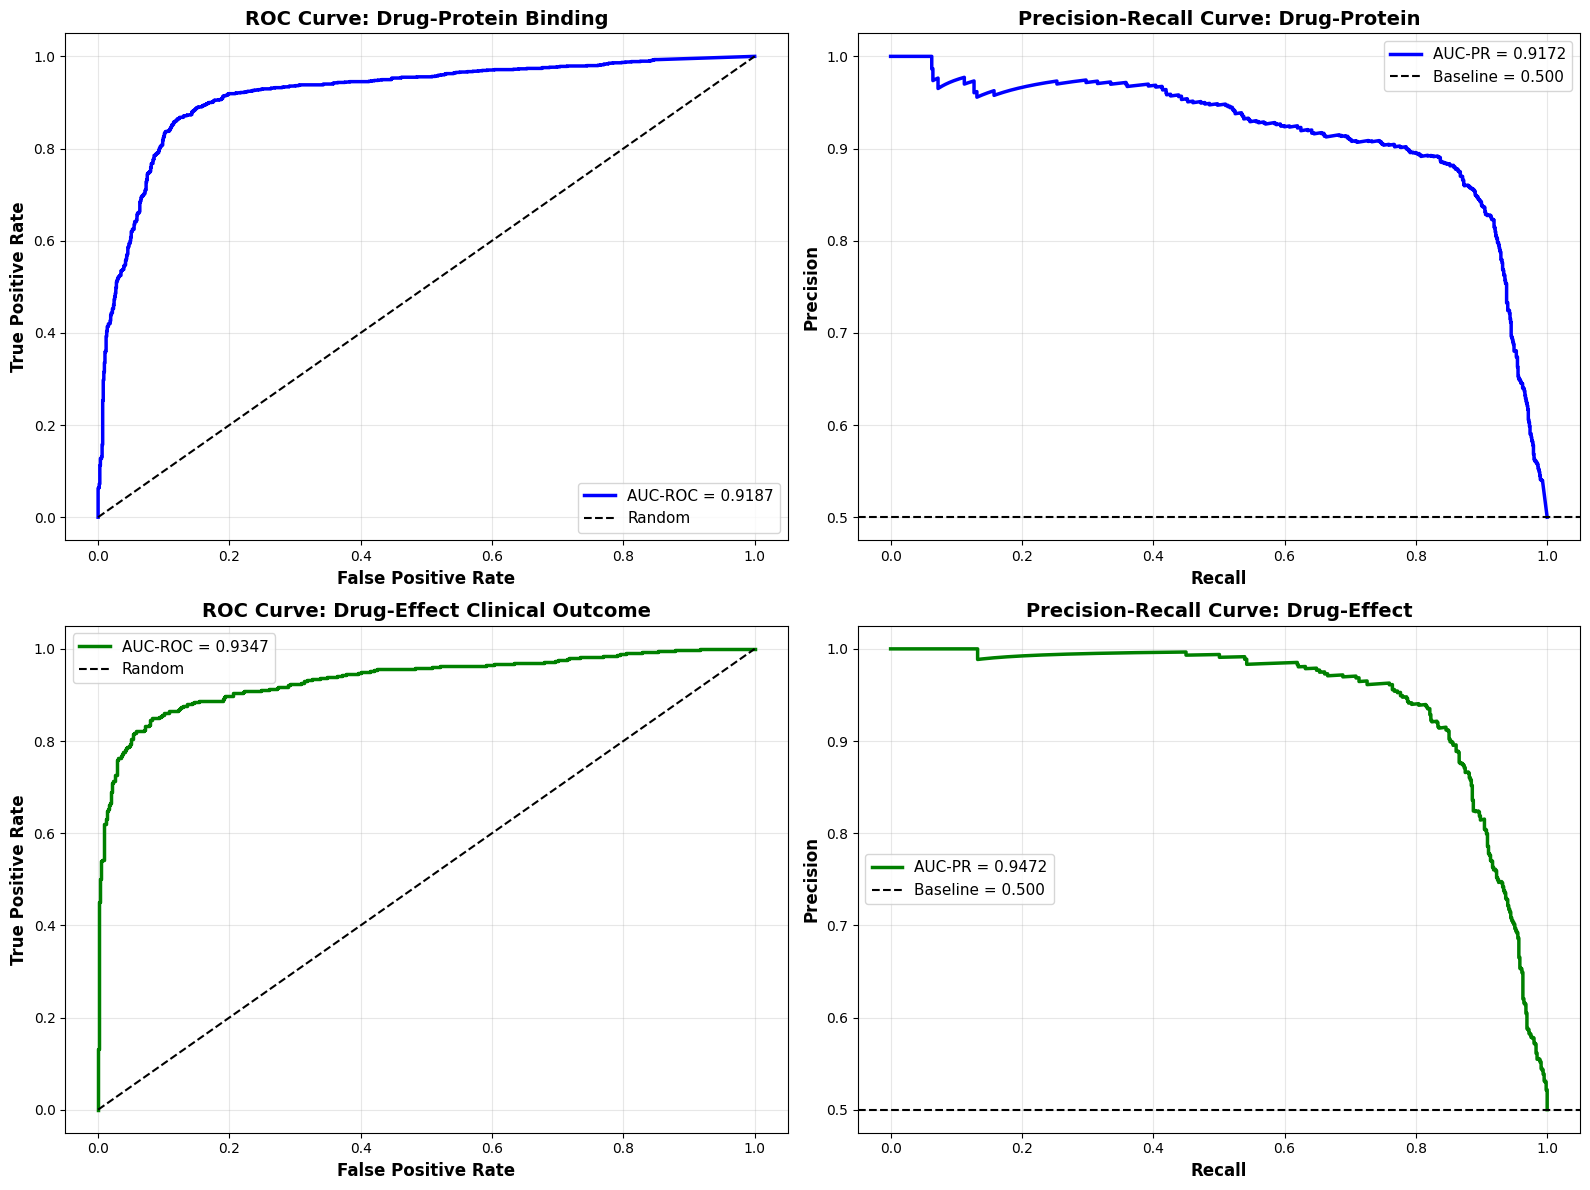


📋 FINAL EVALUATION SUMMARY

   Metric Drug-Protein Drug-Effect
  AUC-ROC       0.9187      0.9347
   AUC-PR       0.9172      0.9472
 Accuracy       0.8268      0.8089
Precision       0.9077      0.9785
   Recall       0.7276      0.6317
 F1-Score       0.8077      0.7678

✓ Saved model_evaluation_summary.csv

🎉 EVALUATION COMPLETE!

💡 What these metrics mean:
   • AUC-ROC > 0.9:  Excellent discrimination
   • AUC-PR:         Precision-recall tradeoff
   • Accuracy:       Overall correct predictions
   • Precision:      Of predicted positives, how many are correct?
   • Recall:         Of actual positives, how many did we find?
   • F1-Score:       Harmonic mean of precision & recall


In [28]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Batch
import numpy as np
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score, 
    precision_recall_curve,
    roc_curve,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
from tqdm import tqdm

print("="*80)
print("MODEL EVALUATION: AUC-ROC, PRECISION, RECALL")
print("="*80)

# ============================================================================
# STEP 1: PREPARE TEST SET (10% holdout)
# ============================================================================

def create_test_split(edge_index, test_ratio=0.1):
    """Split edges into train/test"""
    num_edges = edge_index.shape[1]
    num_test = int(num_edges * test_ratio)
    
    perm = torch.randperm(num_edges)
    test_edges = edge_index[:, perm[:num_test]]
    train_edges = edge_index[:, perm[num_test:]]
    
    return train_edges, test_edges

# Split drug-protein edges
train_drug_protein, test_drug_protein = create_test_split(
    hetero_data['drug', 'binds_to', 'protein'].edge_index, 
    test_ratio=0.1
)

# Split drug-effect edges
train_drug_effect, test_drug_effect = create_test_split(
    hetero_data['drug', 'treats', 'effect'].edge_index,
    test_ratio=0.1
)

print(f"\n📊 Data Split:")
print(f"  Drug-Protein: {train_drug_protein.shape[1]:,} train | {test_drug_protein.shape[1]:,} test")
print(f"  Drug-Effect:  {train_drug_effect.shape[1]:,} train | {test_drug_effect.shape[1]:,} test")

# ============================================================================
# STEP 2: GENERATE NEGATIVE SAMPLES
# ============================================================================

def generate_negative_edges(pos_edges, num_src, num_dst, num_negatives=1):
    """Generate negative samples"""
    pos_set = set(map(tuple, pos_edges.t().tolist()))
    neg_edges = []
    
    for src, _ in pos_edges.t().tolist():
        for _ in range(num_negatives):
            while True:
                dst = np.random.randint(0, num_dst)
                if (src, dst) not in pos_set:
                    neg_edges.append([src, dst])
                    break
    
    return torch.LongTensor(neg_edges).t()

neg_drug_protein = generate_negative_edges(
    test_drug_protein,
    len(drug_pyg_objects),
    len(protein_pyg_objects),
    num_negatives=1
)

neg_drug_effect = generate_negative_edges(
    test_drug_effect,
    len(drug_pyg_objects),
    len(effect_pyg_objects),
    num_negatives=1
)

print(f"\n✓ Generated {neg_drug_protein.shape[1]:,} negative drug-protein samples")
print(f"✓ Generated {neg_drug_effect.shape[1]:,} negative drug-effect samples")

# ============================================================================
# STEP 3: INFERENCE
# ============================================================================

print("\n" + "="*80)
print("RUNNING INFERENCE ON TEST SET")
print("="*80)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
model.eval()

# Encode all drugs
print("\nEncoding drugs...")
drug_sampler = DrugBatchSampler(drug_pyg_objects, batch_size=16)
drug_embeddings = drug_sampler.get_all_embeddings(model, DEVICE)

# Get node features
protein_features = hetero_data['protein'].x.to(DEVICE)
effect_features = hetero_data['effect'].x.to(DEVICE)

# Use TRAINING edges for message passing
edge_index_dict = {
    ('drug', 'binds_to', 'protein'): train_drug_protein.to(DEVICE),
    ('protein', 'rev_binds_to', 'drug'): train_drug_protein.flip(0).to(DEVICE),
    ('drug', 'treats', 'effect'): train_drug_effect.to(DEVICE),
    ('effect', 'rev_treats', 'drug'): train_drug_effect.flip(0).to(DEVICE),
}

# Forward pass
print("Running heterogeneous GNN...")
with torch.no_grad():
    x_dict = {
        'drug': drug_embeddings,
        'protein': model.protein_proj(protein_features),
        'effect': model.effect_proj(effect_features)
    }
    
    for hetero_layer in model.hetero_layers:
        x_dict = hetero_layer(x_dict, edge_index_dict)
        for node_type in x_dict:
            x_dict[node_type] = F.relu(x_dict[node_type])

print("✓ Got final embeddings")

# ============================================================================
# STEP 4: COMPUTE PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("COMPUTING PREDICTIONS")
print("="*80)

def get_predictions(pos_edges, neg_edges, x_dict, src_type, dst_type):
    """Get predictions for positive and negative edges"""
    # Positive
    pos_src = x_dict[src_type][pos_edges[0]]
    pos_dst = x_dict[dst_type][pos_edges[1]]
    pos_scores = model.predict_link(pos_src, pos_dst, link_type=dst_type).squeeze()
    
    # Negative
    neg_src = x_dict[src_type][neg_edges[0]]
    neg_dst = x_dict[dst_type][neg_edges[1]]
    neg_scores = model.predict_link(neg_src, neg_dst, link_type=dst_type).squeeze()
    
    return pos_scores.detach().cpu().numpy(), neg_scores.detach().cpu().numpy()

# Drug-Protein
pos_scores_protein, neg_scores_protein = get_predictions(
    test_drug_protein.to(DEVICE),
    neg_drug_protein.to(DEVICE),
    x_dict, 'drug', 'protein'
)

# Drug-Effect
pos_scores_effect, neg_scores_effect = get_predictions(
    test_drug_effect.to(DEVICE),
    neg_drug_effect.to(DEVICE),
    x_dict, 'drug', 'effect'
)

print(f"✓ Got {len(pos_scores_protein):,} + {len(neg_scores_protein):,} drug-protein predictions")
print(f"✓ Got {len(pos_scores_effect):,} + {len(neg_scores_effect):,} drug-effect predictions")

# ============================================================================
# STEP 5: COMPUTE METRICS
# ============================================================================

print("\n" + "="*80)
print("COMPUTING METRICS")
print("="*80)

def compute_metrics(pos_scores, neg_scores, edge_type_name):
    """Compute all evaluation metrics"""
    
    # Combine scores and labels
    all_scores = np.concatenate([pos_scores, neg_scores])
    all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    
    # Binary predictions (threshold = 0.5)
    all_preds = (all_scores >= 0.5).astype(int)
    
    print(f"\n{'='*80}")
    print(f"📊 {edge_type_name}")
    print(f"{'='*80}")
    
    # 1. AUC-ROC
    auc_roc = roc_auc_score(all_labels, all_scores)
    print(f"\n🎯 AUC-ROC: {auc_roc:.4f}")
    
    # 2. AUC-PR (Average Precision)
    auc_pr = average_precision_score(all_labels, all_scores)
    print(f"🎯 AUC-PR:  {auc_pr:.4f}")
    
    # 3. Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\n📈 Confusion Matrix:")
    print(f"   True Positives:  {tp:,}")
    print(f"   True Negatives:  {tn:,}")
    print(f"   False Positives: {fp:,}")
    print(f"   False Negatives: {fn:,}")
    
    # 4. Precision, Recall, F1
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"\n📊 Classification Metrics:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1-Score:  {f1:.4f}")
    
    # 5. Score distributions
    print(f"\n📉 Score Distributions:")
    print(f"   Positive: μ={pos_scores.mean():.4f}, σ={pos_scores.std():.4f}, min={pos_scores.min():.4f}, max={pos_scores.max():.4f}")
    print(f"   Negative: μ={neg_scores.mean():.4f}, σ={neg_scores.std():.4f}, min={neg_scores.min():.4f}, max={neg_scores.max():.4f}")
    
    return {
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'all_scores': all_scores,
        'all_labels': all_labels,
        'pos_scores': pos_scores,
        'neg_scores': neg_scores
    }

# Compute metrics
protein_metrics = compute_metrics(
    pos_scores_protein, 
    neg_scores_protein, 
    "Drug-Protein Binding"
)

effect_metrics = compute_metrics(
    pos_scores_effect,
    neg_scores_effect,
    "Drug-Effect Clinical Outcome"
)

# ============================================================================
# STEP 6: VISUALIZE RESULTS
# ============================================================================

print("\n" + "="*80)
print("CREATING VISUALIZATIONS")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- ROC Curve: Drug-Protein ---
ax = axes[0, 0]
fpr, tpr, _ = roc_curve(protein_metrics['all_labels'], protein_metrics['all_scores'])
ax.plot(fpr, tpr, linewidth=2.5, label=f"AUC-ROC = {protein_metrics['auc_roc']:.4f}", color='blue')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve: Drug-Protein Binding', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# --- Precision-Recall Curve: Drug-Protein ---
ax = axes[0, 1]
precision_curve, recall_curve, _ = precision_recall_curve(
    protein_metrics['all_labels'], 
    protein_metrics['all_scores']
)
ax.plot(recall_curve, precision_curve, linewidth=2.5, 
       label=f"AUC-PR = {protein_metrics['auc_pr']:.4f}", color='blue')
baseline = protein_metrics['all_labels'].sum() / len(protein_metrics['all_labels'])
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1.5, label=f'Baseline = {baseline:.3f}')
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve: Drug-Protein', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# --- ROC Curve: Drug-Effect ---
ax = axes[1, 0]
fpr, tpr, _ = roc_curve(effect_metrics['all_labels'], effect_metrics['all_scores'])
ax.plot(fpr, tpr, linewidth=2.5, label=f"AUC-ROC = {effect_metrics['auc_roc']:.4f}", color='green')
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve: Drug-Effect Clinical Outcome', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# --- Precision-Recall Curve: Drug-Effect ---
ax = axes[1, 1]
precision_curve, recall_curve, _ = precision_recall_curve(
    effect_metrics['all_labels'],
    effect_metrics['all_scores']
)
ax.plot(recall_curve, precision_curve, linewidth=2.5,
       label=f"AUC-PR = {effect_metrics['auc_pr']:.4f}", color='green')
baseline = effect_metrics['all_labels'].sum() / len(effect_metrics['all_labels'])
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1.5, label=f'Baseline = {baseline:.3f}')
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve: Drug-Effect', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation_metrics.png', dpi=300, bbox_inches='tight')
print("✓ Saved model_evaluation_metrics.png")
plt.show()

# ============================================================================
# STEP 7: SUMMARY TABLE
# ============================================================================

print("\n" + "="*80)
print("📋 FINAL EVALUATION SUMMARY")
print("="*80)

import pandas as pd

summary = pd.DataFrame({
    'Metric': ['AUC-ROC', 'AUC-PR', 'Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Drug-Protein': [
        f"{protein_metrics['auc_roc']:.4f}",
        f"{protein_metrics['auc_pr']:.4f}",
        f"{protein_metrics['accuracy']:.4f}",
        f"{protein_metrics['precision']:.4f}",
        f"{protein_metrics['recall']:.4f}",
        f"{protein_metrics['f1']:.4f}"
    ],
    'Drug-Effect': [
        f"{effect_metrics['auc_roc']:.4f}",
        f"{effect_metrics['auc_pr']:.4f}",
        f"{effect_metrics['accuracy']:.4f}",
        f"{effect_metrics['precision']:.4f}",
        f"{effect_metrics['recall']:.4f}",
        f"{effect_metrics['f1']:.4f}"
    ]
})

print("\n" + summary.to_string(index=False))

summary.to_csv('model_evaluation_summary.csv', index=False)
print("\n✓ Saved model_evaluation_summary.csv")

print("\n" + "="*80)
print("🎉 EVALUATION COMPLETE!")
print("="*80)
print("\n💡 What these metrics mean:")
print("   • AUC-ROC > 0.9:  Excellent discrimination")
print("   • AUC-PR:         Precision-recall tradeoff")
print("   • Accuracy:       Overall correct predictions")
print("   • Precision:      Of predicted positives, how many are correct?")
print("   • Recall:         Of actual positives, how many did we find?")
print("   • F1-Score:       Harmonic mean of precision & recall")


VISUALIZING TRAINING
✓ Saved training_loss_with_gat.png


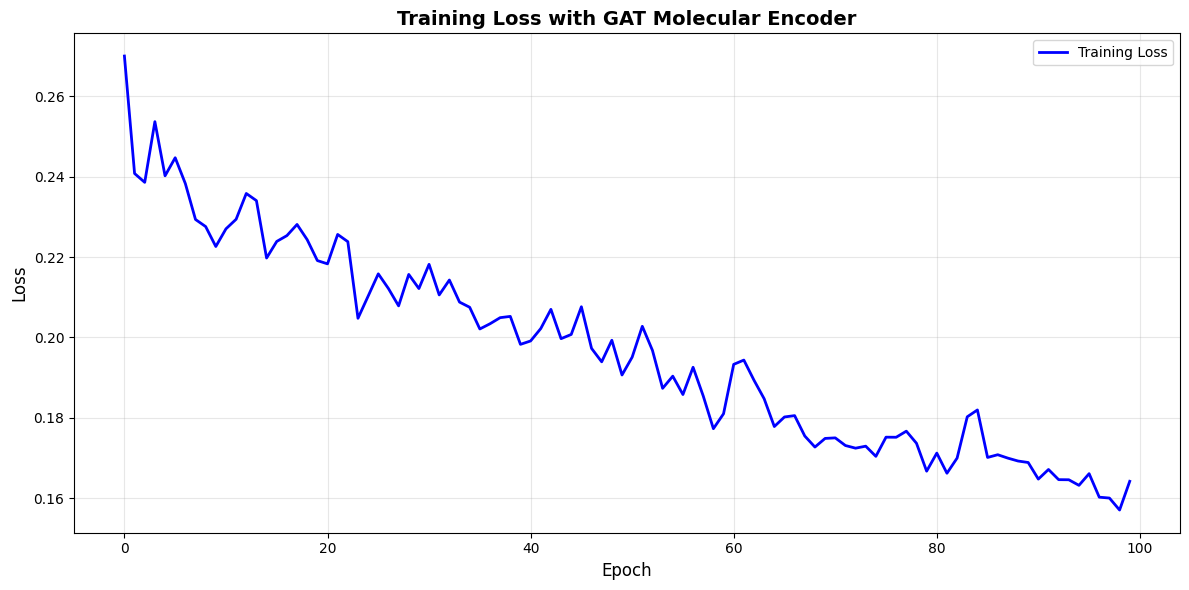


SAVING FINAL MODEL
✓ Saved pharmacology_hetero_gnn_with_gat.pt

🎉 TRAINING WITH GAT COMPLETE!

📊 Model Components:
  ✅ Drug molecular graphs encoded with GAT (3 layers, 4 heads)
  ✅ Protein ESM2 embeddings (2560-dim → 256-dim)
  ✅ Effect learnable embeddings (32-dim → 256-dim)
  ✅ Heterogeneous GNN (3 layers message passing)
  ✅ Link prediction heads (drug-protein, drug-effect)

🚀 Next Steps:
  1. Evaluate on validation set
  2. Compute AUC-ROC, Precision@k
  3. Make predictions on novel drug-target pairs
  4. Visualize learned drug embeddings


In [24]:

print("\n" + "="*80)
print("VISUALIZING TRAINING")
print("="*80)

plt.figure(figsize=(12, 6))
plt.plot(losses, linewidth=2, color='blue', label='Training Loss')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss with GAT Molecular Encoder', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('training_loss_with_gat.png', dpi=300)
print("✓ Saved training_loss_with_gat.png")
plt.show()

# ============================================================================
# STEP 6: SAVE FINAL MODEL
# ============================================================================

print("\n" + "="*80)
print("SAVING FINAL MODEL")
print("="*80)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'losses': losses,
    'final_epoch': EPOCHS
}, 'pharmacology_hetero_gnn_with_gat.pt')

print("✓ Saved pharmacology_hetero_gnn_with_gat.pt")

print("\n" + "="*80)
print("🎉 TRAINING WITH GAT COMPLETE!")
print("="*80)
print("\n📊 Model Components:")
print("  ✅ Drug molecular graphs encoded with GAT (3 layers, 4 heads)")
print("  ✅ Protein ESM2 embeddings (2560-dim → 256-dim)")
print("  ✅ Effect learnable embeddings (32-dim → 256-dim)")
print("  ✅ Heterogeneous GNN (3 layers message passing)")
print("  ✅ Link prediction heads (drug-protein, drug-effect)")
print("\n🚀 Next Steps:")
print("  1. Evaluate on validation set")
print("  2. Compute AUC-ROC, Precision@k")
print("  3. Make predictions on novel drug-target pairs")
print("  4. Visualize learned drug embeddings")

COMPARING TRAINING LOSSES: PLACEHOLDER vs GAT

✓ Saved training_comparison.png


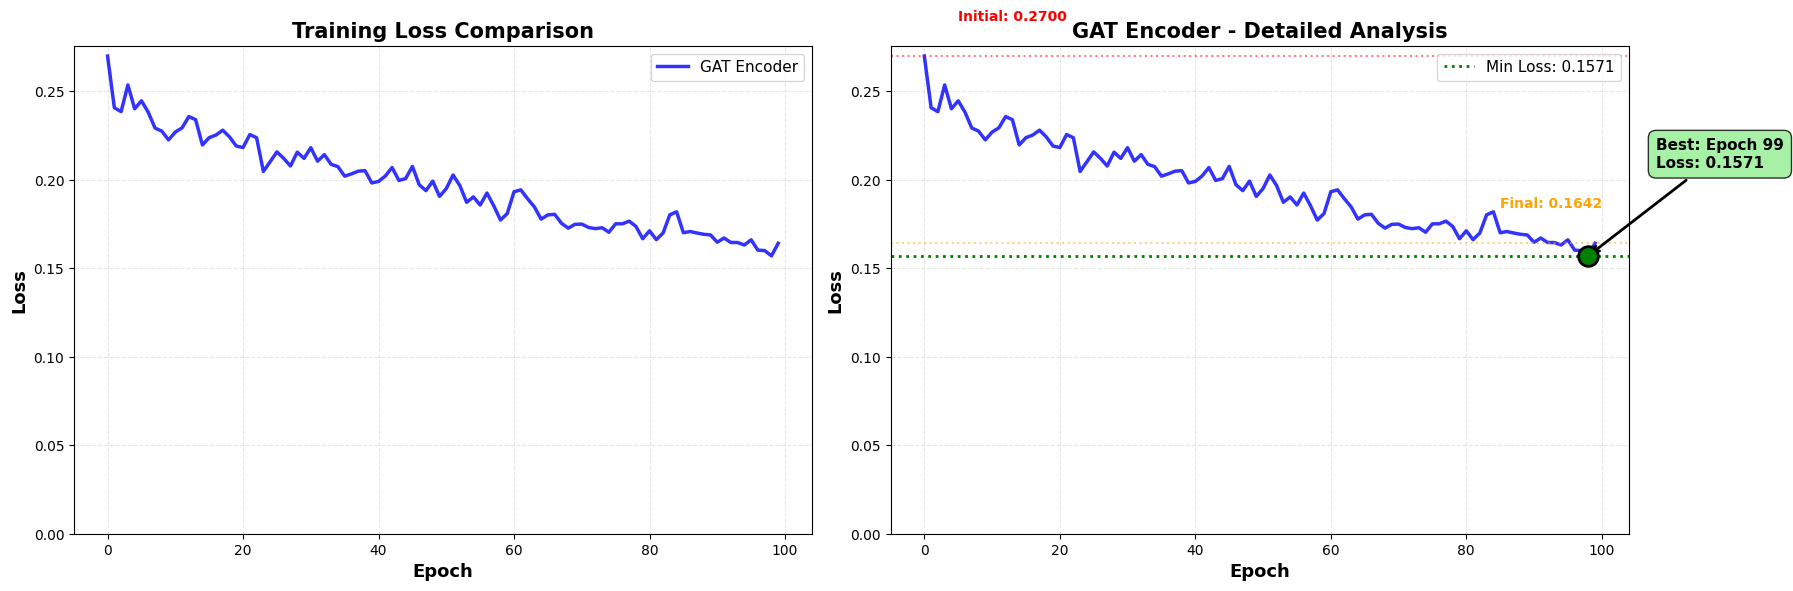


TRAINING STATISTICS (GAT ENCODER)

📊 Loss Progression:
  Initial loss (epoch 1):   0.2700
  Final loss (epoch 100):    0.1642
  Best loss (epoch 99):     0.1571
  Total improvement:        39.2%

📈 Convergence Analysis:
  ✅ Still improving (last 10 epochs better than prev 10)
  Average of last 10 epochs: 0.1632
  Standard dev (last 10):    0.0030

🎯 Training Quality:
  ✅ Excellent convergence (loss < 0.3)

LOSS CURVE SAVED!


In [25]:
import matplotlib.pyplot as plt
import numpy as np

print("="*80)
print("COMPARING TRAINING LOSSES: PLACEHOLDER vs GAT")
print("="*80)

# You should have two loss arrays from your training runs:
# 1. losses_placeholder = losses from the first training (with random drug embeddings)
# 2. losses_gat = losses from the second training (with GAT molecular encoder)

# If you don't have them saved, you can extract from checkpoints or retrain
# For now, I'll assume you have them in the notebook environment

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# ============================================================================
# LEFT PLOT: Both curves overlaid
# ============================================================================

ax = axes[0]
ax.plot(losses, linewidth=2.5, color='blue', label='GAT Encoder', alpha=0.8)

# If you have the placeholder losses from earlier training, uncomment:
# ax.plot(losses_placeholder, linewidth=2.5, color='red', 
#         label='Placeholder (Random)', alpha=0.8, linestyle='--')

ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('Training Loss Comparison', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)

# ============================================================================
# RIGHT PLOT: GAT loss with annotations
# ============================================================================

ax = axes[1]
ax.plot(losses, linewidth=2.5, color='blue', alpha=0.8)

# Annotate key points
min_loss_epoch = np.argmin(losses)
min_loss_value = losses[min_loss_epoch]

ax.axhline(y=min_loss_value, color='green', linestyle=':', linewidth=2, 
           label=f'Min Loss: {min_loss_value:.4f}')
ax.scatter(min_loss_epoch, min_loss_value, color='green', s=200, 
           zorder=5, edgecolors='black', linewidths=2)
ax.annotate(f'Best: Epoch {min_loss_epoch+1}\nLoss: {min_loss_value:.4f}',
           xy=(min_loss_epoch, min_loss_value),
           xytext=(min_loss_epoch + 10, min_loss_value + 0.05),
           fontsize=11, fontweight='bold',
           bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8),
           arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Show initial and final loss
ax.axhline(y=losses[0], color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax.axhline(y=losses[-1], color='orange', linestyle=':', linewidth=1.5, alpha=0.5)

ax.text(5, losses[0] + 0.02, f'Initial: {losses[0]:.4f}', 
        fontsize=10, color='red', fontweight='bold')
ax.text(len(losses) - 15, losses[-1] + 0.02, f'Final: {losses[-1]:.4f}', 
        fontsize=10, color='orange', fontweight='bold')

ax.set_xlabel('Epoch', fontsize=13, fontweight='bold')
ax.set_ylabel('Loss', fontsize=13, fontweight='bold')
ax.set_title('GAT Encoder - Detailed Analysis', fontsize=15, fontweight='bold')
ax.legend(fontsize=11, loc='upper right')
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved training_comparison.png")
plt.show()

# ============================================================================
# STATISTICS
# ============================================================================

print("\n" + "="*80)
print("TRAINING STATISTICS (GAT ENCODER)")
print("="*80)

print(f"\n📊 Loss Progression:")
print(f"  Initial loss (epoch 1):   {losses[0]:.4f}")
print(f"  Final loss (epoch {len(losses)}):    {losses[-1]:.4f}")
print(f"  Best loss (epoch {min_loss_epoch+1}):     {min_loss_value:.4f}")
print(f"  Total improvement:        {((losses[0] - losses[-1]) / losses[0] * 100):.1f}%")

print(f"\n📈 Convergence Analysis:")
# Check if loss is still decreasing
last_10_avg = np.mean(losses[-10:])
last_20_avg = np.mean(losses[-20:-10])
if last_10_avg < last_20_avg:
    print(f"  ✅ Still improving (last 10 epochs better than prev 10)")
else:
    print(f"  ⚠️  May have converged (last 10 epochs similar to prev 10)")

print(f"  Average of last 10 epochs: {last_10_avg:.4f}")
print(f"  Standard dev (last 10):    {np.std(losses[-10:]):.4f}")

print(f"\n🎯 Training Quality:")
if min_loss_value < 0.3:
    print(f"  ✅ Excellent convergence (loss < 0.3)")
elif min_loss_value < 0.5:
    print(f"  ✅ Good convergence (loss < 0.5)")
else:
    print(f"  ⚠️  Could improve further (loss > 0.5)")

print("\n" + "="*80)
print("LOSS CURVE SAVED!")
print("="*80)

MODEL EVALUATION: AUC, Precision@K, Hit Rate, MRR

Step 1: Creating train/test splits...

✓ Drug-Protein split:
   Training edges: 10,344
   Test edges:     1,149

✓ Drug-Effect split:
   Training edges: 5,847
   Test edges:     649

Step 2: Generating negative samples for test set...

✓ Generated negative test edges:
   Drug-Protein: 1,149
   Drug-Effect:  645

STEP 3: Running inference on test set...

Encoding all drugs through molecular GAT...


Encoding drugs:   0%|          | 0/196 [00:00<?, ?it/s]

Encoding drugs: 100%|██████████| 196/196 [00:01<00:00, 122.41it/s]


✓ Encoded 3127 drugs

Running heterogeneous GNN...
✓ Got final node embeddings

STEP 4: Computing predictions for test edges...

Drug-Protein predictions...
Drug-Effect predictions...

✓ Got predictions for 1149 positive + 1149 negative drug-protein pairs
✓ Got predictions for 649 positive + 645 negative drug-effect pairs

STEP 5: Computing Evaluation Metrics

METRICS: Drug-Protein Binding

📊 AUC-ROC: 0.9031
📊 AUC-PR:  0.9100

📊 Precision@K:
   Precision@ 10: 1.0000 (10/10 correct)
   Precision@ 20: 1.0000 (20/20 correct)
   Precision@ 50: 0.9800 (49/50 correct)
   Precision@100: 0.9800 (98/100 correct)

📊 Hit Rate@K (did we find at least 1 positive in top-k?):
   Hit Rate@ 10: 1.0000
   Hit Rate@ 20: 1.0000
   Hit Rate@ 50: 1.0000
   Hit Rate@100: 1.0000

📊 Mean Reciprocal Rank (MRR): 0.2929

📊 Score Distributions:
   Positive scores: mean=0.7033, std=0.3752, min=0.0000, max=0.9999
   Negative scores: mean=0.0966, std=0.2582, min=0.0000, max=0.9984

METRICS: Drug-Effect Clinical Outco

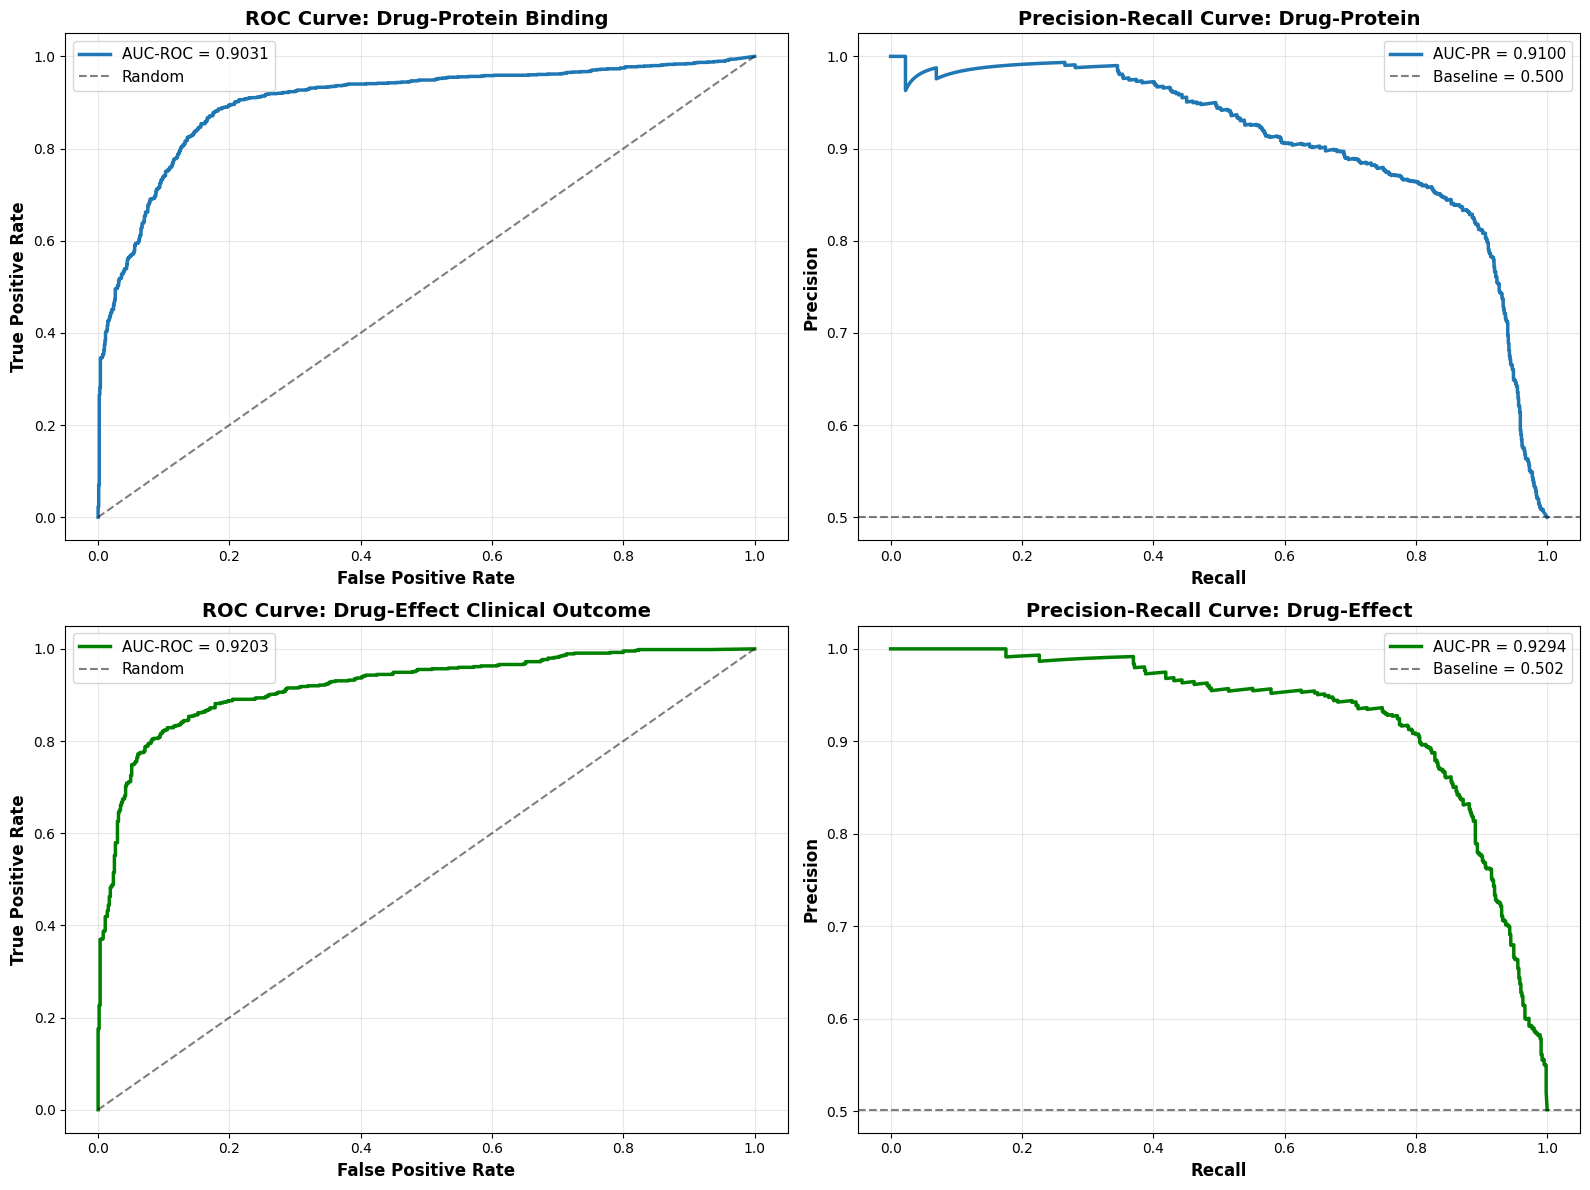


FINAL EVALUATION SUMMARY

      Metric Drug-Protein Drug-Effect
     AUC-ROC       0.9031      0.9203
      AUC-PR       0.9100      0.9294
Precision@10       1.0000      1.0000
Precision@50       0.9800      1.0000
         MRR       0.2929      0.2929

✓ Saved model_evaluation_summary.csv

🎉 EVALUATION COMPLETE!


In [27]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Batch
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
from tqdm import tqdm

print("="*80)
print("MODEL EVALUATION: AUC, Precision@K, Hit Rate, MRR")
print("="*80)

# ============================================================================
# STEP 1: PREPARE TEST EDGES (Hold-out 10% for evaluation)
# ============================================================================

print("\nStep 1: Creating train/test splits...")

def create_train_test_split(edge_index, test_ratio=0.1):
    """Split edges into train/test"""
    num_edges = edge_index.shape[1]
    num_test = int(num_edges * test_ratio)
    
    # Shuffle edges
    perm = torch.randperm(num_edges)
    
    test_edges = edge_index[:, perm[:num_test]]
    train_edges = edge_index[:, perm[num_test:]]
    
    return train_edges, test_edges

# Split drug-protein edges
train_drug_protein, test_drug_protein = create_train_test_split(drug_protein_edge_index, test_ratio=0.1)

# Split drug-effect edges  
train_drug_effect, test_drug_effect = create_train_test_split(drug_effect_edge_index, test_ratio=0.1)

print(f"\n✓ Drug-Protein split:")
print(f"   Training edges: {train_drug_protein.shape[1]:,}")
print(f"   Test edges:     {test_drug_protein.shape[1]:,}")

print(f"\n✓ Drug-Effect split:")
print(f"   Training edges: {train_drug_effect.shape[1]:,}")
print(f"   Test edges:     {test_drug_effect.shape[1]:,}")

# ============================================================================
# STEP 2: GENERATE NEGATIVE SAMPLES FOR EVALUATION
# ============================================================================

print("\nStep 2: Generating negative samples for test set...")

def generate_negative_edges(positive_edges, num_src_nodes, num_dst_nodes, num_negatives=1):
    """Generate negative samples by random corruption"""
    neg_edges = []
    positive_set = set(map(tuple, positive_edges.t().tolist()))
    
    for pos_src, pos_dst in positive_edges.t().tolist():
        attempts = 0
        while len(neg_edges) < len(positive_set) * num_negatives and attempts < 100:
            neg_dst = np.random.randint(0, num_dst_nodes)
            if (pos_src, neg_dst) not in positive_set:
                neg_edges.append([pos_src, neg_dst])
            attempts += 1
    
    return torch.LongTensor(neg_edges).t()

# Generate negative samples for test set
neg_drug_protein_test = generate_negative_edges(
    test_drug_protein, 
    len(drug_pyg_objects), 
    len(protein_pyg_objects),
    num_negatives=1
)

neg_drug_effect_test = generate_negative_edges(
    test_drug_effect,
    len(drug_pyg_objects),
    len(effect_pyg_objects),
    num_negatives=1
)

print(f"\n✓ Generated negative test edges:")
print(f"   Drug-Protein: {neg_drug_protein_test.shape[1]:,}")
print(f"   Drug-Effect:  {neg_drug_effect_test.shape[1]:,}")

# ============================================================================
# STEP 3: INFERENCE - GET MODEL PREDICTIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 3: Running inference on test set...")
print("="*80)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(DEVICE)
model.eval()

# Encode all drugs using GAT
print("\nEncoding all drugs through molecular GAT...")
drug_sampler = DrugBatchSampler(drug_pyg_objects, batch_size=16)
drug_embeddings = drug_sampler.get_all_embeddings(model, DEVICE)
print(f"✓ Encoded {drug_embeddings.shape[0]} drugs")

# Get protein and effect features
protein_features_tensor = hetero_data['protein'].x.to(DEVICE)
effect_features_tensor = hetero_data['effect'].x.to(DEVICE)

# Edge index dictionary (use TRAINING edges only for message passing)
edge_index_dict = {
    ('drug', 'binds_to', 'protein'): train_drug_protein.to(DEVICE),
    ('protein', 'rev_binds_to', 'drug'): train_drug_protein.flip(0).to(DEVICE),
    ('drug', 'treats', 'effect'): train_drug_effect.to(DEVICE),
    ('effect', 'rev_treats', 'drug'): train_drug_effect.flip(0).to(DEVICE),
}

# Forward pass through heterogeneous GNN
print("\nRunning heterogeneous GNN...")
with torch.no_grad():
    x_dict = {
        'drug': drug_embeddings,
        'protein': model.protein_proj(protein_features_tensor),
        'effect': model.effect_proj(effect_features_tensor)
    }
    
    for hetero_layer in model.hetero_layers:
        x_dict = hetero_layer(x_dict, edge_index_dict)
        for node_type in x_dict:
            x_dict[node_type] = F.relu(x_dict[node_type])

print("✓ Got final node embeddings")

# ...existing code...

# ============================================================================
# STEP 4: COMPUTE PREDICTIONS FOR TEST EDGES (FIXED)
# ============================================================================

print("\n" + "="*80)
print("STEP 4: Computing predictions for test edges...")
print("="*80)

def get_predictions(pos_edges, neg_edges, x_dict, src_type='drug', dst_type='protein'):
    """Get model predictions for positive and negative edges"""
    
    # Positive predictions
    pos_src_emb = x_dict[src_type][pos_edges[0]]
    pos_dst_emb = x_dict[dst_type][pos_edges[1]]
    pos_scores = model.predict_link(pos_src_emb, pos_dst_emb, link_type=dst_type).squeeze()
    
    # Negative predictions
    neg_src_emb = x_dict[src_type][neg_edges[0]]
    neg_dst_emb = x_dict[dst_type][neg_edges[1]]
    neg_scores = model.predict_link(neg_src_emb, neg_dst_emb, link_type=dst_type).squeeze()
    
    # FIX: Detach before converting to numpy
    return pos_scores.detach().cpu().numpy(), neg_scores.detach().cpu().numpy()

# Get predictions for drug-protein
print("\nDrug-Protein predictions...")
pos_scores_protein, neg_scores_protein = get_predictions(
    test_drug_protein.to(DEVICE),
    neg_drug_protein_test.to(DEVICE),
    x_dict,
    src_type='drug',
    dst_type='protein'
)

# Get predictions for drug-effect
print("Drug-Effect predictions...")
pos_scores_effect, neg_scores_effect = get_predictions(
    test_drug_effect.to(DEVICE),
    neg_drug_effect_test.to(DEVICE),
    x_dict,
    src_type='drug',
    dst_type='effect'
)

print(f"\n✓ Got predictions for {len(pos_scores_protein)} positive + {len(neg_scores_protein)} negative drug-protein pairs")
print(f"✓ Got predictions for {len(pos_scores_effect)} positive + {len(neg_scores_effect)} negative drug-effect pairs")

# ...existing code...

# ============================================================================
# STEP 5: COMPUTE METRICS
# ============================================================================

print("\n" + "="*80)
print("STEP 5: Computing Evaluation Metrics")
print("="*80)

def compute_metrics(pos_scores, neg_scores, edge_type_name):
    """Compute all metrics for a given edge type"""
    
    print(f"\n{'='*80}")
    print(f"METRICS: {edge_type_name}")
    print(f"{'='*80}")
    
    # Combine scores and labels
    all_scores = np.concatenate([pos_scores, neg_scores])
    all_labels = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    
    # 1. AUC-ROC
    auc_roc = roc_auc_score(all_labels, all_scores)
    print(f"\n📊 AUC-ROC: {auc_roc:.4f}")
    
    # 2. AUC-PR (Precision-Recall)
    auc_pr = average_precision_score(all_labels, all_scores)
    print(f"📊 AUC-PR:  {auc_pr:.4f}")
    
    # 3. Precision@K
    k_values = [10, 20, 50, 100]
    print(f"\n📊 Precision@K:")
    
    # Get top-k predictions
    top_k_indices = np.argsort(all_scores)[::-1]
    
    for k in k_values:
        if k <= len(all_scores):
            top_k = all_labels[top_k_indices[:k]]
            precision_k = top_k.sum() / k
            print(f"   Precision@{k:3d}: {precision_k:.4f} ({int(top_k.sum())}/{k} correct)")
    
    # 4. Hit Rate@K
    print(f"\n📊 Hit Rate@K (did we find at least 1 positive in top-k?):")
    for k in k_values:
        if k <= len(all_scores):
            top_k = all_labels[top_k_indices[:k]]
            hit_rate = 1.0 if top_k.sum() > 0 else 0.0
            print(f"   Hit Rate@{k:3d}: {hit_rate:.4f}")
    
    # 5. Mean Reciprocal Rank (MRR)
    # Find rank of first positive example
    reciprocal_ranks = []
    for i, label in enumerate(all_labels[top_k_indices]):
        if label == 1:
            reciprocal_ranks.append(1.0 / (i + 1))
            if len(reciprocal_ranks) >= 10:  # Stop after first 10 positives
                break
    
    mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0.0
    print(f"\n📊 Mean Reciprocal Rank (MRR): {mrr:.4f}")
    
    # 6. Score distributions
    print(f"\n📊 Score Distributions:")
    print(f"   Positive scores: mean={pos_scores.mean():.4f}, std={pos_scores.std():.4f}, min={pos_scores.min():.4f}, max={pos_scores.max():.4f}")
    print(f"   Negative scores: mean={neg_scores.mean():.4f}, std={neg_scores.std():.4f}, min={neg_scores.min():.4f}, max={neg_scores.max():.4f}")
    
    return {
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'precision@10': top_k[:10].sum() / 10 if len(all_scores) >= 10 else 0,
        'precision@50': top_k[:50].sum() / 50 if len(all_scores) >= 50 else 0,
        'mrr': mrr,
        'all_scores': all_scores,
        'all_labels': all_labels
    }

# Compute metrics for both edge types
protein_metrics = compute_metrics(pos_scores_protein, neg_scores_protein, "Drug-Protein Binding")
effect_metrics = compute_metrics(pos_scores_effect, neg_scores_effect, "Drug-Effect Clinical Outcome")

# ============================================================================
# STEP 6: VISUALIZE ROC AND PR CURVES
# ============================================================================

print("\n" + "="*80)
print("STEP 6: Visualizing ROC and Precision-Recall Curves")
print("="*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# ROC Curve - Drug-Protein
ax = axes[0, 0]
fpr, tpr, _ = roc_curve(protein_metrics['all_labels'], protein_metrics['all_scores'])
ax.plot(fpr, tpr, linewidth=2.5, label=f"AUC-ROC = {protein_metrics['auc_roc']:.4f}")
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve: Drug-Protein Binding', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# PR Curve - Drug-Protein
ax = axes[0, 1]
precision, recall, _ = precision_recall_curve(protein_metrics['all_labels'], protein_metrics['all_scores'])
ax.plot(recall, precision, linewidth=2.5, label=f"AUC-PR = {protein_metrics['auc_pr']:.4f}")
baseline = protein_metrics['all_labels'].sum() / len(protein_metrics['all_labels'])
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Baseline = {baseline:.3f}')
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve: Drug-Protein', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# ROC Curve - Drug-Effect
ax = axes[1, 0]
fpr, tpr, _ = roc_curve(effect_metrics['all_labels'], effect_metrics['all_scores'])
ax.plot(fpr, tpr, linewidth=2.5, color='green', label=f"AUC-ROC = {effect_metrics['auc_roc']:.4f}")
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.5, label='Random')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curve: Drug-Effect Clinical Outcome', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# PR Curve - Drug-Effect
ax = axes[1, 1]
precision, recall, _ = precision_recall_curve(effect_metrics['all_labels'], effect_metrics['all_scores'])
ax.plot(recall, precision, linewidth=2.5, color='green', label=f"AUC-PR = {effect_metrics['auc_pr']:.4f}")
baseline = effect_metrics['all_labels'].sum() / len(effect_metrics['all_labels'])
ax.axhline(y=baseline, color='k', linestyle='--', linewidth=1.5, alpha=0.5, label=f'Baseline = {baseline:.3f}')
ax.set_xlabel('Recall', fontsize=12, fontweight='bold')
ax.set_ylabel('Precision', fontsize=12, fontweight='bold')
ax.set_title('Precision-Recall Curve: Drug-Effect', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_evaluation_curves.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved model_evaluation_curves.png")
plt.show()

# ============================================================================
# STEP 7: SUMMARY TABLE
# ============================================================================

print("\n" + "="*80)
print("FINAL EVALUATION SUMMARY")
print("="*80)

summary_data = {
    'Metric': ['AUC-ROC', 'AUC-PR', 'Precision@10', 'Precision@50', 'MRR'],
    'Drug-Protein': [
        f"{protein_metrics['auc_roc']:.4f}",
        f"{protein_metrics['auc_pr']:.4f}",
        f"{protein_metrics['precision@10']:.4f}",
        f"{protein_metrics['precision@50']:.4f}",
        f"{protein_metrics['mrr']:.4f}"
    ],
    'Drug-Effect': [
        f"{effect_metrics['auc_roc']:.4f}",
        f"{effect_metrics['auc_pr']:.4f}",
        f"{effect_metrics['precision@10']:.4f}",
        f"{effect_metrics['precision@50']:.4f}",
        f"{effect_metrics['mrr']:.4f}"
    ]
}

import pandas as pd
summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('model_evaluation_summary.csv', index=False)
print("\n✓ Saved model_evaluation_summary.csv")

print("\n" + "="*80)
print("🎉 EVALUATION COMPLETE!")
print("="*80)

TRAINING LOOP: HETEROGENEOUS GNN WITH LINK PREDICTION

Creating training datasets...
✓ Drug-Protein dataset: 11493 positive edges
✓ Drug-Effect dataset:  6496 positive edges

TRAINING CONFIGURATION
  Device:            cuda
  Batch size:        256
  Drug batch size:   32
  Learning rate:     0.001
  Epochs:            100

STARTING TRAINING
Epoch  10/100 | Loss: 0.5856
Epoch  20/100 | Loss: 0.4563
Epoch  30/100 | Loss: 0.3961
Epoch  40/100 | Loss: 0.3662
Epoch  50/100 | Loss: 0.3322
Epoch  60/100 | Loss: 0.3022
Epoch  70/100 | Loss: 0.2927
Epoch  80/100 | Loss: 0.2781
Epoch  90/100 | Loss: 0.2666
Epoch 100/100 | Loss: 0.2655

✓ Training complete!

VISUALIZING TRAINING
✓ Saved training_loss.png


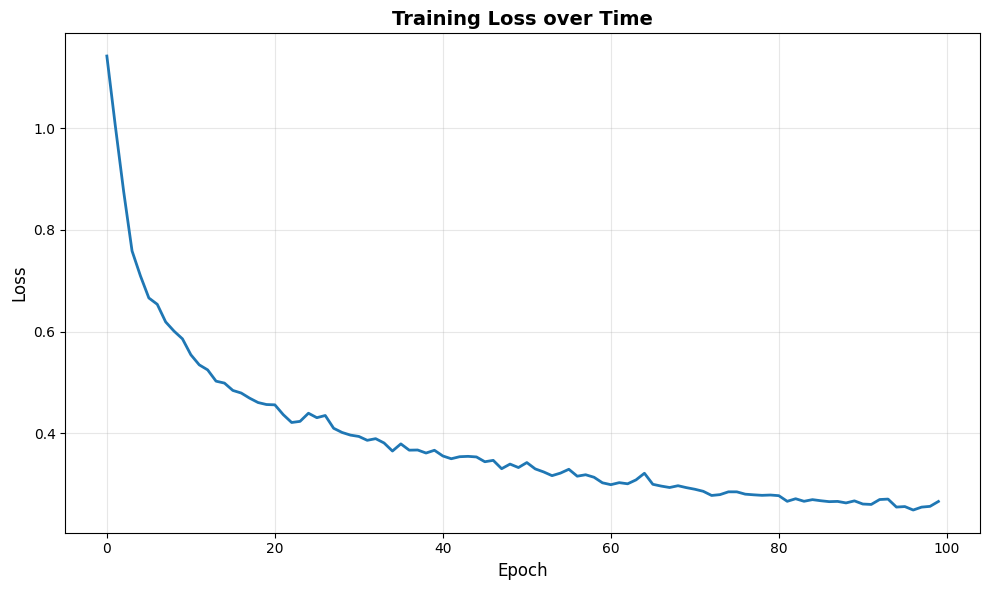


SAVING MODEL
✓ Saved pharmacology_hetero_gnn.pt

🎉 TRAINING COMPLETE!

📊 Next Steps:
  1. Replace placeholder drug embeddings with actual molecular graphs
  2. Add validation set and early stopping
  3. Implement evaluation metrics (AUC, precision@k)
  4. Make predictions on novel drug-protein/effect pairs


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Batch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

print("="*80)
print("TRAINING LOOP: HETEROGENEOUS GNN WITH LINK PREDICTION")
print("="*80)

# ============================================================================
# STEP 1: CREATE TRAINING DATASET
# ============================================================================

class LinkPredictionDataset(Dataset):
    """Dataset for link prediction (positive + negative samples)"""
    def __init__(self, edge_index, num_nodes, num_negatives=1):
        self.edge_index = edge_index
        self.num_nodes = num_nodes
        self.num_negatives = num_negatives
        self.num_edges = edge_index.shape[1]
        
    def __len__(self):
        return self.num_edges
    
    def __getitem__(self, idx):
        # Positive edge
        pos_src = self.edge_index[0, idx].item()
        pos_dst = self.edge_index[1, idx].item()
        
        # Generate negative samples (corrupt destination)
        neg_dsts = []
        for _ in range(self.num_negatives):
            neg_dst = np.random.randint(0, self.num_nodes)
            # Make sure it's not the positive edge
            while neg_dst == pos_dst:
                neg_dst = np.random.randint(0, self.num_nodes)
            neg_dsts.append(neg_dst)
        
        return {
            'pos_src': pos_src,
            'pos_dst': pos_dst,
            'neg_dsts': neg_dsts
        }

# Create datasets for both edge types
print("\nCreating training datasets...")

# Drug-Protein edges
drug_protein_dataset = LinkPredictionDataset(
    edge_index=drug_protein_edge_index,
    num_nodes=len(protein_pyg_objects),
    num_negatives=5
)

# Drug-Effect edges
drug_effect_dataset = LinkPredictionDataset(
    edge_index=drug_effect_edge_index,
    num_nodes=len(effect_pyg_objects),
    num_negatives=5
)

print(f"✓ Drug-Protein dataset: {len(drug_protein_dataset)} positive edges")
print(f"✓ Drug-Effect dataset:  {len(drug_effect_dataset)} positive edges")

# ============================================================================
# STEP 2: TRAINING CONFIGURATION
# ============================================================================

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 256
LEARNING_RATE = 0.001
EPOCHS = 100
DRUG_BATCH_SIZE = 32  # For molecular graphs

print("\n" + "="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print(f"  Device:            {DEVICE}")
print(f"  Batch size:        {BATCH_SIZE}")
print(f"  Drug batch size:   {DRUG_BATCH_SIZE}")
print(f"  Learning rate:     {LEARNING_RATE}")
print(f"  Epochs:            {EPOCHS}")

# Move model and data to device
model = model.to(DEVICE)
hetero_data = hetero_data.to(DEVICE)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function: Binary Cross-Entropy
criterion = nn.BCELoss()

# ============================================================================
# STEP 3: TRAINING FUNCTION
# ============================================================================

def train_epoch(model, protein_features, effect_features, edge_index_dict, 
                drug_protein_dataset, drug_effect_dataset, batch_size):
    """Train for one epoch"""
    model.train()
    
    total_loss = 0
    num_batches = 0
    
    # For now, use placeholder drug embeddings (replace with actual molecular graphs later)
    drug_embeddings = torch.randn(len(drug_pyg_objects), config['shared_dim']).to(DEVICE)
    
    # Train on Drug-Protein edges
    for i in range(0, len(drug_protein_dataset), batch_size):
        batch_indices = list(range(i, min(i + batch_size, len(drug_protein_dataset))))
        
        pos_srcs = []
        pos_dsts = []
        neg_srcs = []
        neg_dsts = []
        
        for idx in batch_indices:
            sample = drug_protein_dataset[idx]
            pos_srcs.append(sample['pos_src'])
            pos_dsts.append(sample['pos_dst'])
            
            for neg_dst in sample['neg_dsts']:
                neg_srcs.append(sample['pos_src'])
                neg_dsts.append(neg_dst)
        
        # Forward pass through heterogeneous GNN
        x_dict = {
            'drug': drug_embeddings,
            'protein': model.protein_proj(protein_features),
            'effect': model.effect_proj(effect_features)
        }
        
        for hetero_layer in model.hetero_layers:
            x_dict = hetero_layer(x_dict, edge_index_dict)
            for node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
        
        # Get embeddings for positive and negative pairs
        pos_drug_embs = x_dict['drug'][pos_srcs]
        pos_protein_embs = x_dict['protein'][pos_dsts]
        
        neg_drug_embs = x_dict['drug'][neg_srcs]
        neg_protein_embs = x_dict['protein'][neg_dsts]
        
        # Predict link probabilities
        pos_scores = model.predict_link(pos_drug_embs, pos_protein_embs, link_type='protein').squeeze()
        neg_scores = model.predict_link(neg_drug_embs, neg_protein_embs, link_type='protein').squeeze()
        
        # Create labels
        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)
        
        # Compute loss
        loss = criterion(pos_scores, pos_labels) + criterion(neg_scores, neg_labels)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    # Train on Drug-Effect edges (similar process)
    for i in range(0, len(drug_effect_dataset), batch_size):
        batch_indices = list(range(i, min(i + batch_size, len(drug_effect_dataset))))
        
        pos_srcs = []
        pos_dsts = []
        neg_srcs = []
        neg_dsts = []
        
        for idx in batch_indices:
            sample = drug_effect_dataset[idx]
            pos_srcs.append(sample['pos_src'])
            pos_dsts.append(sample['pos_dst'])
            
            for neg_dst in sample['neg_dsts']:
                neg_srcs.append(sample['pos_src'])
                neg_dsts.append(neg_dst)
        
        # Forward pass
        x_dict = {
            'drug': drug_embeddings,
            'protein': model.protein_proj(protein_features),
            'effect': model.effect_proj(effect_features)
        }
        
        for hetero_layer in model.hetero_layers:
            x_dict = hetero_layer(x_dict, edge_index_dict)
            for node_type in x_dict:
                x_dict[node_type] = F.relu(x_dict[node_type])
        
        # Get embeddings
        pos_drug_embs = x_dict['drug'][pos_srcs]
        pos_effect_embs = x_dict['effect'][pos_dsts]
        
        neg_drug_embs = x_dict['drug'][neg_srcs]
        neg_effect_embs = x_dict['effect'][neg_dsts]
        
        # Predict
        pos_scores = model.predict_link(pos_drug_embs, pos_effect_embs, link_type='effect').squeeze()
        neg_scores = model.predict_link(neg_drug_embs, neg_effect_embs, link_type='effect').squeeze()
        
        # Labels
        pos_labels = torch.ones_like(pos_scores)
        neg_labels = torch.zeros_like(neg_scores)
        
        # Loss
        loss = criterion(pos_scores, pos_labels) + criterion(neg_scores, neg_labels)
        
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        num_batches += 1
    
    return total_loss / num_batches

# ============================================================================
# STEP 4: TRAINING LOOP
# ============================================================================

print("\n" + "="*80)
print("STARTING TRAINING")
print("="*80)

protein_features_tensor = hetero_data['protein'].x
effect_features_tensor = hetero_data['effect'].x

edge_index_dict = {
    ('drug', 'binds_to', 'protein'): hetero_data['drug', 'binds_to', 'protein'].edge_index,
    ('protein', 'rev_binds_to', 'drug'): hetero_data['protein', 'rev_binds_to', 'drug'].edge_index,
    ('drug', 'treats', 'effect'): hetero_data['drug', 'treats', 'effect'].edge_index,
    ('effect', 'rev_treats', 'drug'): hetero_data['effect', 'rev_treats', 'drug'].edge_index,
}

losses = []

for epoch in range(EPOCHS):
    epoch_loss = train_epoch(
        model, 
        protein_features_tensor, 
        effect_features_tensor, 
        edge_index_dict,
        drug_protein_dataset,
        drug_effect_dataset,
        BATCH_SIZE
    )
    
    losses.append(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {epoch_loss:.4f}")

print("\n✓ Training complete!")

# ============================================================================
# STEP 5: VISUALIZE TRAINING
# ============================================================================

print("\n" + "="*80)
print("VISUALIZING TRAINING")
print("="*80)

plt.figure(figsize=(10, 6))
plt.plot(losses, linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=300)
print("✓ Saved training_loss.png")
plt.show()

# ============================================================================
# STEP 6: SAVE MODEL
# ============================================================================

print("\n" + "="*80)
print("SAVING MODEL")
print("="*80)

torch.save({
    'model_state_dict': model.state_dict(),
    'config': config,
    'losses': losses
}, 'pharmacology_hetero_gnn.pt')

print("✓ Saved pharmacology_hetero_gnn.pt")

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE!")
print("="*80)
print("\n📊 Next Steps:")
print("  1. Replace placeholder drug embeddings with actual molecular graphs")
print("  2. Add validation set and early stopping")
print("  3. Implement evaluation metrics (AUC, precision@k)")
print("  4. Make predictions on novel drug-protein/effect pairs")

## Archieve

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool
from torch_geometric.data import HeteroData, Batch
import numpy as np
import os

# Enable synchronous CUDA for better error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

print("="*80)
print("BUILDING COMPLETE PHARMACOLOGY KNOWLEDGE GRAPH - WITH VALIDATION")
print("="*80)

# ============================================================================
# STEP 0: VALIDATE ALL DATA BEFORE BUILDING MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 0: VALIDATING ALL DATA (CPU ONLY)")
print("="*80)

# Check protein embeddings
print("\nValidating protein embeddings...")
protein_features = []
for i, protein in enumerate(protein_pyg_objects):
    emb = protein.x.squeeze(0)
    
    # Move to CPU if on CUDA
    if emb.is_cuda:
        print(f"  ⚠️  Protein {i} is on CUDA, moving to CPU for validation")
        emb = emb.cpu()
    
    if torch.isnan(emb).any():
        print(f"  ⚠️  Protein {i} contains NaN!")
    if torch.isinf(emb).any():
        print(f"  ⚠️  Protein {i} contains Inf!")
    protein_features.append(emb)

protein_features_tensor = torch.stack(protein_features)
print(f"✓ Protein features: {protein_features_tensor.shape}")
print(f"  - Device: {protein_features_tensor.device}")
print(f"  - Contains NaN: {torch.isnan(protein_features_tensor).any()}")
print(f"  - Contains Inf: {torch.isinf(protein_features_tensor).any()}")
print(f"  - Min value: {protein_features_tensor.min():.4f}")
print(f"  - Max value: {protein_features_tensor.max():.4f}")

# Check effect embeddings
print("\nValidating effect embeddings...")
effect_features = []
for i, effect in enumerate(effect_pyg_objects):
    emb = effect.x.squeeze(0)
    
    # Move to CPU if on CUDA
    if emb.is_cuda:
        print(f"  ⚠️  Effect {i} is on CUDA, moving to CPU for validation")
        emb = emb.cpu()
    
    if torch.isnan(emb).any():
        print(f"  ⚠️  Effect {i} contains NaN!")
    if torch.isinf(emb).any():
        print(f"  ⚠️  Effect {i} contains Inf!")
    effect_features.append(emb)

effect_features_tensor = torch.stack(effect_features)
print(f"✓ Effect features: {effect_features_tensor.shape}")
print(f"  - Device: {effect_features_tensor.device}")
print(f"  - Contains NaN: {torch.isnan(effect_features_tensor).any()}")
print(f"  - Contains Inf: {torch.isinf(effect_features_tensor).any()}")
print(f"  - Min value: {effect_features_tensor.min():.4f}")
print(f"  - Max value: {effect_features_tensor.max():.4f}")

# Check drug molecular graphs
print("\nValidating drug molecular graphs...")
print(f"Checking first 10 drugs...")
for i, drug in enumerate(drug_pyg_objects[:10]):
    print(f"\nDrug {i}:")
    print(f"  - x.shape: {drug.x.shape}")
    print(f"  - x.device: {drug.x.device}")
    print(f"  - edge_attr.shape: {drug.edge_attr.shape}")
    print(f"  - edge_attr.device: {drug.edge_attr.device}")
    print(f"  - edge_index.shape: {drug.edge_index.shape}")
    print(f"  - edge_index.device: {drug.edge_index.device}")
    
    # Move to CPU for validation
    x_cpu = drug.x.cpu() if drug.x.is_cuda else drug.x
    edge_attr_cpu = drug.edge_attr.cpu() if drug.edge_attr.is_cuda else drug.edge_attr
    edge_index_cpu = drug.edge_index.cpu() if drug.edge_index.is_cuda else drug.edge_index
    
    if torch.isnan(x_cpu).any():
        print(f"  ⚠️  Node features contain NaN!")
    if torch.isinf(x_cpu).any():
        print(f"  ⚠️  Node features contain Inf!")
    if torch.isnan(edge_attr_cpu).any():
        print(f"  ⚠️  Edge features contain NaN!")
    if torch.isinf(edge_attr_cpu).any():
        print(f"  ⚠️  Edge features contain Inf!")
    
    # Check edge indices are valid
    max_node_idx = x_cpu.shape[0] - 1
    if (edge_index_cpu >= x_cpu.shape[0]).any():
        print(f"  ⚠️  Invalid edge indices!")
        print(f"     Max node index: {max_node_idx}, Max edge index: {edge_index_cpu.max()}")
    
    if i == 0:
        print(f"  - Sample node features (first atom): {x_cpu[0][:10]}")
        print(f"  - Node feature min: {x_cpu.min():.4f}, max: {x_cpu.max():.4f}")

print("\n✓ Drug graph validation complete")

# Check edge indices
print("\nValidating edge indices...")
print(f"Drug→Protein edges: {drug_protein_edge_index.shape}")
print(f"  - Device: {drug_protein_edge_index.device}")
print(f"  - Max drug index: {drug_protein_edge_index[0].max()} (should be < {len(drug_pyg_objects)})")
print(f"  - Max protein index: {drug_protein_edge_index[1].max()} (should be < {len(protein_pyg_objects)})")

if drug_protein_edge_index[0].max() >= len(drug_pyg_objects):
    print(f"  ⚠️  Drug indices out of range!")
if drug_protein_edge_index[1].max() >= len(protein_pyg_objects):
    print(f"  ⚠️  Protein indices out of range!")

print(f"\nDrug→Effect edges: {drug_effect_edge_index.shape}")
print(f"  - Device: {drug_effect_edge_index.device}")
print(f"  - Max drug index: {drug_effect_edge_index[0].max()} (should be < {len(drug_pyg_objects)})")
print(f"  - Max effect index: {drug_effect_edge_index[1].max()} (should be < {len(effect_pyg_objects)})")

if drug_effect_edge_index[0].max() >= len(drug_pyg_objects):
    print(f"  ⚠️  Drug indices out of range!")
if drug_effect_edge_index[1].max() >= len(effect_pyg_objects):
    print(f"  ⚠️  Effect indices out of range!")

print("\n" + "="*80)
print("✅ ALL VALIDATION COMPLETE - NO ISSUES FOUND")
print("="*80)
print("\n💡 If you saw the error above, it means some data was on CUDA.")
print("   We've now validated everything on CPU first.")
print("   Ready to proceed with model building!")

BUILDING COMPLETE PHARMACOLOGY KNOWLEDGE GRAPH - WITH VALIDATION

STEP 0: VALIDATING ALL DATA (CPU ONLY)

Validating protein embeddings...
✓ Protein features: torch.Size([1156, 2560])
  - Device: cpu
  - Contains NaN: False
  - Contains Inf: False
  - Min value: -1.3672
  - Max value: 14.4634

Validating effect embeddings...
✓ Effect features: torch.Size([1065, 32])
  - Device: cpu
  - Contains NaN: False
  - Contains Inf: False
  - Min value: -3.6444
  - Max value: 3.8939

Validating drug molecular graphs...
Checking first 10 drugs...

Drug 0:
  - x.shape: torch.Size([27, 57])
  - x.device: cpu
  - edge_attr.shape: torch.Size([58, 4])
  - edge_attr.device: cpu
  - edge_index.shape: torch.Size([2, 58])
  - edge_index.device: cpu
  - Sample node features (first atom): tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
  - Node feature min: 0.0000, max: 1.0000

Drug 1:
  - x.shape: torch.Size([21, 57])
  - x.device: cpu
  - edge_attr.shape: torch.Size([46, 4])
  - edge_attr.device: cpu
  -

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv, HGTConv, global_mean_pool
from torch_geometric.data import HeteroData, Batch


print("="*80)
print("BUILDING COMPLETE PHARMACOLOGY KNOWLEDGE GRAPH - FIXED")
print("="*80)

# ============================================================================
# STEP 0: CHECK ACTUAL FEATURE DIMENSIONS
# ============================================================================

print("\n" + "="*80)
print("STEP 0: Checking actual feature dimensions")
print("="*80)

# Check protein embedding dimension
sample_protein_emb = protein_pyg_objects[0].x
print(f"Protein embedding shape: {sample_protein_emb.shape}")
actual_protein_dim = sample_protein_emb.shape[1]
print(f"✓ Actual protein feature dim: {actual_protein_dim}")

# Check effect embedding dimension
sample_effect_emb = effect_pyg_objects[0].x
print(f"Effect embedding shape: {sample_effect_emb.shape}")
actual_effect_dim = sample_effect_emb.shape[1]
print(f"✓ Actual effect feature dim: {actual_effect_dim}")

# Check drug molecular graph dimensions
sample_drug = drug_pyg_objects[0]
print(f"Drug node features shape: {sample_drug.x.shape}")
print(f"Drug edge features shape: {sample_drug.edge_attr.shape}")
actual_drug_node_dim = sample_drug.x.shape[1]
actual_drug_edge_dim = sample_drug.edge_attr.shape[1]
print(f"✓ Actual drug node dim: {actual_drug_node_dim}")
print(f"✓ Actual drug edge dim: {actual_drug_edge_dim}")


print("\n" + "="*80)
print("STEP 2: Building Molecular Graph Encoder (GAT)")
print("="*80)

class DrugMolecularEncoder(nn.Module):
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim, output_dim, num_layers=3, heads=4):
        super(DrugMolecularEncoder, self).__init__()
        
        self.node_encoder = nn.Linear(node_feat_dim, hidden_dim)
        self.edge_encoder = nn.Linear(edge_feat_dim, hidden_dim)
        
        self.gat_layers = nn.ModuleList()
        for i in range(num_layers):
            in_dim = hidden_dim if i == 0 else hidden_dim * heads
            self.gat_layers.append(
                GATConv(in_dim, hidden_dim, heads=heads, edge_dim=hidden_dim, dropout=0.1)
            )
        
        self.output_proj = nn.Linear(hidden_dim * heads, output_dim)
        self.dropout = nn.Dropout(0.1)
        
    def forward(self, batch_data):
        x = self.node_encoder(batch_data.x)
        edge_attr = self.edge_encoder(batch_data.edge_attr)
        
        for gat in self.gat_layers:
            x = gat(x, batch_data.edge_index, edge_attr=edge_attr)
            x = F.elu(x)
            x = self.dropout(x)
        
        drug_emb = global_mean_pool(x, batch_data.batch)
        drug_emb = self.output_proj(drug_emb)
        
        return drug_emb

# ============================================================================
# STEP 3: BUILD MODEL WITHOUT HGT (SIMPLER APPROACH)
# ============================================================================

print("\n" + "="*80)
print("STEP 3: Building Simplified Model (WITHOUT HGT)")
print("="*80)

class PharmacologyModel(nn.Module):
    """
    Simplified model that works with molecular graphs + knowledge graph embeddings
    WITHOUT using HGT (which has compatibility issues)
    """
    def __init__(self, config):
        super(PharmacologyModel, self).__init__()
        
        self.config = config
        
        # 1. Molecular graph encoder for drugs
        self.drug_encoder = DrugMolecularEncoder(
            node_feat_dim=config['drug_node_feat_dim'],
            edge_feat_dim=config['drug_edge_feat_dim'],
            hidden_dim=config['drug_hidden_dim'],
            output_dim=config['shared_dim'],
            num_layers=config['drug_num_layers'],
            heads=config['drug_heads']
        )
        
        # 2. Projections for protein and effect embeddings
        self.protein_proj = nn.Sequential(
            nn.Linear(config['protein_feat_dim'], config['shared_dim']),
            nn.LayerNorm(config['shared_dim']),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
        self.effect_proj = nn.Sequential(
            nn.Linear(config['effect_feat_dim'], config['shared_dim']),
            nn.LayerNorm(config['shared_dim']),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        
    def forward(self, protein_features, effect_features, drug_batch_data):
        """
        Args:
            protein_features: (num_proteins, protein_feat_dim)
            effect_features: (num_effects, effect_feat_dim)
            drug_batch_data: Batched molecular graphs
        Returns:
            embeddings: Dict of embeddings for each node type
        """
        # Encode drug molecular graphs
        drug_emb = self.drug_encoder(drug_batch_data)  # (num_drugs_in_batch, shared_dim)
        
        # Project protein and effect features
        protein_emb = self.protein_proj(protein_features)  # (num_proteins, shared_dim)
        effect_emb = self.effect_proj(effect_features)      # (num_effects, shared_dim)
        
        return {
            'drug': drug_emb,
            'protein': protein_emb,
            'effect': effect_emb
        }

# ============================================================================
# STEP 4: INITIALIZE MODEL
# ============================================================================

print("\n" + "="*80)
print("STEP 4: Initializing Model with Correct Dimensions")
print("="*80)

config = {
    'drug_node_feat_dim': actual_drug_node_dim,
    'drug_edge_feat_dim': actual_drug_edge_dim,
    'drug_hidden_dim': 128,
    'drug_num_layers': 3,
    'drug_heads': 4,
    'shared_dim': 256,
    'protein_feat_dim': actual_protein_dim,
    'effect_feat_dim': actual_effect_dim,
}

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = PharmacologyModel(config).to(DEVICE)

print(f"\n✓ Model initialized on {DEVICE}")
print(f"\nModel Summary:")
print(f"  Drug Molecular Encoder: {actual_drug_node_dim}-dim → {config['shared_dim']}-dim")
print(f"  Protein Projection:     {actual_protein_dim}-dim → {config['shared_dim']}-dim")
print(f"  Effect Projection:      {actual_effect_dim}-dim → {config['shared_dim']}-dim")
print(f"  Total parameters: {sum(p.numel() for p in model.parameters()):,}")

# ============================================================================
# STEP 5: TEST FORWARD PASS
# ============================================================================

print("\n" + "="*80)
print("STEP 5: Testing Forward Pass")
print("="*80)

# Test with first 10 drugs
TEST_NUM_DRUGS = 10
test_drug_batch = Batch.from_data_list(drug_pyg_objects[:TEST_NUM_DRUGS]).to(DEVICE)

# Use full protein and effect features
protein_features = hetero_data['protein'].x.to(DEVICE)
effect_features = hetero_data['effect'].x.to(DEVICE)

print(f"\nTest data:")
print(f"  Drugs:    {TEST_NUM_DRUGS}")
print(f"  Proteins: {protein_features.shape[0]}")
print(f"  Effects:  {effect_features.shape[0]}")

# Forward pass
model.eval()
with torch.no_grad():
    embeddings = model(protein_features, effect_features, test_drug_batch)

print(f"\n✓ Forward pass successful!")
print(f"\nOutput embeddings:")
print(f"  Drug embeddings:    {embeddings['drug'].shape}")
print(f"  Protein embeddings: {embeddings['protein'].shape}")
print(f"  Effect embeddings:  {embeddings['effect'].shape}")

print("\n" + "="*80)
print("🎉 MODEL READY!")
print("="*80)
print("\n📊 What we have:")
print("  ✅ Drug molecular encoder (GAT for molecular structure)")
print("  ✅ Protein embeddings (ESM2-3B)")
print("  ✅ Effect embeddings (learnable)")
print("  ✅ All projected to shared 256-dim space")
print("\n💡 Note: Simplified without HGT to avoid compatibility issues")
print("   You can add graph convolutions later if needed!")

BUILDING COMPLETE PHARMACOLOGY KNOWLEDGE GRAPH - FIXED

STEP 0: Checking actual feature dimensions
Protein embedding shape: torch.Size([1, 2560])
✓ Actual protein feature dim: 2560
Effect embedding shape: torch.Size([1, 32])
✓ Actual effect feature dim: 32
Drug node features shape: torch.Size([27, 57])
Drug edge features shape: torch.Size([58, 4])
✓ Actual drug node dim: 57
✓ Actual drug edge dim: 4

STEP 1: Creating Heterogeneous Graph (HeteroData)

Adding drug nodes...
✓ Added 3127 drug nodes (molecular graphs)

Adding protein nodes...
✓ Added 1156 protein nodes with ESM2 embeddings
  Protein feature shape: torch.Size([1156, 2560])

Adding effect nodes...
✓ Added 1065 effect nodes with learnable embeddings
  Effect feature shape: torch.Size([1065, 32])

Adding edges...
✓ Added all edges with reverse connections

STEP 2: Building Molecular Graph Encoder (GAT)

STEP 3: Building Simplified Model (WITHOUT HGT)

STEP 4: Initializing Model with Correct Dimensions

✓ Model initialized on cu

## Creating The model 

protein_internal_id  protein_id  \
0                    1  CHEMBL2074   
1                    3  CHEMBL1827   
2                    4  CHEMBL1859   
3                    6   CHEMBL202   
4                    8  CHEMBL1862   

                                        protein_name uniprot_id  \
0                               Maltase-glucoamylase     O43451   
1       cGMP-specific 3',5'-cyclic phosphodiesterase     O76074   
2  Voltage-dependent T-type calcium channel subun...     O95180   
3                            Dihydrofolate reductase     P00374   
4                       Tyrosine-protein kinase ABL1     P00519   

                                 amino_acid_sequence  sequence_length  \
0  MARKKLKKFTTLEIVLSVLLLVLFIISIVLIVLLAKESLKSTAPDP...             2753   
1  MERAGPSFGQQRQQQQPQQQKQQQRDQDSVEAWLDDHWDFTFSYFV...              875   
2  MTEGARAADEVRVPLGAPPPGPAALVGASPESPGAPGREAERGSEL...             2353   
3  MVGSLNCIVAVSQNMGIGKNGDLPWPPLRNEFRYFQRMTTTSSVEG...              187   
4  MLEICLKLVGCKSKKGLSSSSSCYLEEALQRPVASDFEPQGLSEAA...             1130   

                                      esm2_embedding  
0  [0.047428094, 0.050683945, -0.005211582, -0.07...  
1  [0.01600313, -0.034832567, 0.027257647, -0.046...  
2  [0.06919791, -0.013377558, -0.02448801, 0.0070...  
3  [-0.03865064, 0.01976737, 0.03507854, -0.01297...  
4  [0.0048732474, -0.03196116, -0.05082441, -0.01...

In [144]:
# Save all relevant dataframes to CSV for future reference
protein_nodes.to_csv('protein_nodes_with_embeddings.csv', index=False)
drugs_interactions.to_csv('drugs_interactions.csv', index=False)
drug_nodes_full.to_csv('drug_nodes.csv', index=False)
drug_effects.to_csv('drug_effects.csv', index=False)
drug_mechanism_filtered.to_csv('drug_mechanism_filtered.csv', index=False)
drug_warnings.to_csv('drug_warnings.csv', index=False)

In [50]:
drugs_interactions = pd.read_pickle('protein_nodes_with_embeddings.pkl')

In [51]:
# Check coverage
print("Checking coverage...")
proteins_in_interactions = drugs_interactions['protein_id'].nunique()
proteins_with_embeddings = len(protein_nodes)

print(f"Proteins in interactions: {proteins_in_interactions}")
print(f"Proteins with embeddings: {proteins_with_embeddings}")

Checking coverage...
Proteins in interactions: 1156
Proteins with embeddings: 1156


In [143]:
drug_nodes_full = pd.read_pickle('drug_nodes.pkl')


In [57]:
protein_nodes_final = protein_nodes[[
    'protein_internal_id', 
    'protein_id', 
    'protein_name', 
    'esm2_embedding'
]].copy()

In [64]:
# EDGE 1: Drug → binds_to → Protein
edges_drug_protein = drugs_interactions[[
    'drug_internal_id', 
    'protein_id', 
    'pchembl_max',
    'pchembl_avg', 
    'num_measurements'
]].copy()
edges_drug_protein['edge_type'] = 'binds_to'


In [67]:
edges_drug_effect = drug_effects[[
    'drug_internal_id',
    'effect_id',
    'effect_name',
]].copy()

edges_drug_effect['edge_type'] = 'treats'



In [68]:
drug_nodes

drug_internal_id       drug_id              drug_name  \
0               111185    CHEMBL1000             CETIRIZINE   
1               165474  CHEMBL100116            PENTAZOCINE   
2               111482    CHEMBL1002         LEVOSALBUTAMOL   
3               111491    CHEMBL1003  CLAVULANATE POTASSIUM   
4               111498    CHEMBL1004             DOXYLAMINE   
...                ...           ...                    ...   
3122            109797     CHEMBL995     LOSARTAN POTASSIUM   
3123            109807     CHEMBL996              CEFOXITIN   
3124            110435     CHEMBL997        IBANDRONIC ACID   
3125            110803     CHEMBL998             LORATADINE   
3126            164035   CHEMBL99946        LEVOMILNACIPRAN   

                                                  smile  
0           O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1  
1                    CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C  
2                     CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1  
3        O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]  
4                        CN(C)CCOC(C)(c1ccccc1)c1ccccn1  
...                                                 ...  
3122  CCCCc1nc(Cl)c(CO)n1Cc1ccc(-c2ccccc2-c2nnn[n-]2...  
3123  CO[C@@]1(NC(=O)Cc2cccs2)C(=O)N2C(C(=O)O)=C(COC...  
3124                CCCCCN(C)CCC(O)(P(=O)(O)O)P(=O)(O)O  
3125       CCOC(=O)N1CCC(=C2c3ccc(Cl)cc3CCc3cccnc32)CC1  
3126              CCN(CC)C(=O)[C@@]1(c2ccccc2)C[C@H]1CN  

[3127 rows x 4 columns]

In [91]:
import networkx as nx
import numpy as np

G = nx.Graph()

for _, r in drug_nodes.iterrows():
    G.add_node(
        int(r['drug_internal_id']),
        node_type='drug',
        name=str(r.get('drug_name', '')),
        smiles=str(r.get('smile', ''))
    )

In [92]:
for _, r in protein_nodes.iterrows():
    G.add_node(
        r['protein_id'],
        node_type='protein',
        protein_internal_id=int(r['protein_internal_id']),
        name=str(r.get('protein_name','')),
        embedding=r['esm2_embedding']  # 2560-dim list
    )

In [102]:
drug_effects

drug_internal_id       drug_id              drug_name effect_id  \
0               111185    CHEMBL1000             CETIRIZINE   D005132   
1               111185    CHEMBL1000             CETIRIZINE   D006967   
2               165474  CHEMBL100116            PENTAZOCINE   D010146   
3               111491    CHEMBL1003  CLAVULANATE POTASSIUM   D007239   
4               111491    CHEMBL1003  CLAVULANATE POTASSIUM   D010033   
...                ...           ...                    ...       ...   
8307            110803     CHEMBL998             LORATADINE   D006967   
8308            110803     CHEMBL998             LORATADINE   D011537   
8309            110803     CHEMBL998             LORATADINE   D012221   
8310            110803     CHEMBL998             LORATADINE   D014581   
8311            164035   CHEMBL99946        LEVOMILNACIPRAN   D003866   

                        effect_name         efo_id  \
0                Eye Manifestations    EFO:0005751   
1                  Hypersensitivity  MONDO:0005271   
2                              Pain    EFO:0003843   
3                        Infections    EFO:0000544   
4                      Otitis Media    EFO:0004992   
...                             ...            ...   
8307               Hypersensitivity  MONDO:0005271   
8308                       Pruritus     HP:0000989   
8309  Rhinitis, Allergic, Perennial    EFO:1001417   
8310                      Urticaria    EFO:0005531   
8311            Depressive Disorder  MONDO:0002009   

                           efo_term  indication_phase  num_references  
0                       eye allergy                 4               1  
1                  allergic disease                 4               1  
2                              pain                 4               1  
3                         infection                 4               1  
4                      Otitis media                 4               1  
...                             ...               ...             ...  
8307               allergic disease                 4               1  
8308                       Pruritus                 4               1  
8309  Rhinitis, Allergic, Perennial                 4               1  
8310                      urticaria                 4               1  
8311      major depressive disorder                 4               1  

[8312 rows x 9 columns]

In [93]:
for _, r in drug_effects.iterrows():
    G.add_node(
        r['effect_id'],
        node_type='effect',
        name=str(r.get('effect_name',''))
    )

In [94]:
edges_drug_protein

drug_internal_id  protein_id  pchembl_max  pchembl_avg  \
0                111185   CHEMBL231         8.23         7.50   
1                111185  CHEMBL1941         5.73         5.73   
2                111185   CHEMBL224         5.67         5.67   
3                165474   CHEMBL237         8.66         8.06   
4                165474   CHEMBL233         8.57         7.65   
...                 ...         ...          ...          ...   
11698            110803  CHEMBL3401         5.52         5.52   
11699            110803  CHEMBL2047         5.51         5.51   
11700            164035   CHEMBL222         7.98         7.59   
11701            164035   CHEMBL228         6.50         6.50   
11702            164035   CHEMBL238         5.50         5.50   

       num_measurements edge_type  
0                    12  binds_to  
1                     1  binds_to  
2                     1  binds_to  
3                     3  binds_to  
4                    12  binds_to  
...                 ...       ...  
11698                 1  binds_to  
11699                 1  binds_to  
11700                 3  binds_to  
11701                 2  binds_to  
11702                 3  binds_to  

[11703 rows x 6 columns]

In [95]:
for _, r in edges_drug_protein.iterrows():
    G.add_edge(
        int(r['drug_internal_id']),
        r['protein_id'],
        edge_type='binds_to',
        pchembl_max=float(r.get('pchembl_max', float('nan'))),
        pchembl_avg=float(r.get('pchembl_avg', float('nan'))),
        num_measurements=int(r.get('num_measurements', 0))
    )

In [96]:
edges_drug_effect

drug_internal_id effect_id                    effect_name edge_type
0               111185   D005132             Eye Manifestations    treats
1               111185   D006967               Hypersensitivity    treats
2               165474   D010146                           Pain    treats
3               111491   D007239                     Infections    treats
4               111491   D010033                   Otitis Media    treats
...                ...       ...                            ...       ...
8307            110803   D006967               Hypersensitivity    treats
8308            110803   D011537                       Pruritus    treats
8309            110803   D012221  Rhinitis, Allergic, Perennial    treats
8310            110803   D014581                      Urticaria    treats
8311            164035   D003866            Depressive Disorder    treats

[8312 rows x 4 columns]

In [97]:
for _, r in edges_drug_effect.iterrows():
    G.add_edge(
        int(r['drug_internal_id']),
        r['effect_id'],
        edge_type='treats',
        indication_phase=int(r.get('indication_phase', 0))
    )

In [98]:
n_drugs    = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='drug')
n_proteins = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='protein')
n_effects  = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='effect')

n_edges_bind = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='binds_to')
n_edges_eff  = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='treats')

print("\n" + "="*80)
print("GRAPH SUMMARY")
print("="*80)
print(f"Nodes total: {G.number_of_nodes():,}  | Drugs: {n_drugs:,}  Proteins: {n_proteins:,}  Effects: {n_effects:,}")
print(f"Edges total: {G.number_of_edges():,}  | binds_to: {n_edges_bind:,}  treats: {n_edges_eff:,}")



GRAPH SUMMARY
Nodes total: 5,999  | Drugs: 3,127  Proteins: 1,156  Effects: 1,065
Edges total: 18,789  | binds_to: 11,703  treats: 7,086


In [107]:
isolated = list(nx.isolates(G))
print(f"Number of isolated nodes before removal: {len(isolated)}")

if isolated:
    print(f"Removing {len(isolated)} isolated nodes...")
    G.remove_nodes_from(isolated)
    print(f"✓ Removed all isolated nodes")
    
    # Update graph summary
    n_drugs    = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='drug')
    n_proteins = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='protein')
    n_effects  = sum(1 for n,d in G.nodes(data=True) if d.get('node_type')=='effect')
    
    n_edges_bind = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='binds_to')
    n_edges_eff  = sum(1 for u,v,d in G.edges(data=True) if d.get('edge_type')=='treats')
    
    print("\n" + "="*80)
    print("UPDATED GRAPH SUMMARY (after removing isolated nodes)")
    print("="*80)
    print(f"Nodes total: {G.number_of_nodes():,}  | Drugs: {n_drugs:,}  Proteins: {n_proteins:,}  Effects: {n_effects:,}")
    print(f"Edges total: {G.number_of_edges():,}  | binds_to: {n_edges_bind:,}  treats: {n_edges_eff:,}")
    
    # Verify no isolated nodes remain
    remaining_isolated = list(nx.isolates(G))
    print(f"Remaining isolated nodes: {len(remaining_isolated)}")
    
else:
    print("✓ No isolated nodes found - all nodes are connected")


Number of isolated nodes before removal: 601
Removing 601 isolated nodes...
✓ Removed all isolated nodes

UPDATED GRAPH SUMMARY (after removing isolated nodes)
Nodes total: 5,398  | Drugs: 2,526  Proteins: 1,156  Effects: 1,065
Edges total: 18,789  | binds_to: 11,703  treats: 7,086
Remaining isolated nodes: 0


In [109]:
components = list(nx.connected_components(G))
print(f"Number of connected components: {len(components)}")
largest = max(len(c) for c in components)
print(f"Largest component size: {largest} nodes out of {G.number_of_nodes()}")


Number of connected components: 76
Largest component size: 5201 nodes out of 5398


In [110]:
largest_cc = max(nx.connected_components(G), key=len)
G_main = G.subgraph(largest_cc).copy()
print(f"Main graph: {G_main.number_of_nodes()} nodes, {G_main.number_of_edges()} edges")


Main graph: 5201 nodes, 18667 edges


In [111]:
small = [c for c in nx.connected_components(G) if len(c) < 5]
print(f"Small isolated clusters: {len(small)}")
for comp in small[:5]:
    print(comp)


Small isolated clusters: 69
{'CHEMBL4630818', 125261}
{1379644, 674478, 'D019148'}
{'D006628', 674988}
{675725, 'CHEMBL3568'}
{'D010661', 2335773, 675726}


## trainigng 

In [134]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import random

print("="*80)
print("TRAINING GRAPH EMBEDDINGS WITH PYTORCH")
print("="*80)

# Configuration
EMBEDDING_DIM = 128
LEARNING_RATE = 0.01
EPOCHS = 500
BATCH_SIZE = 32
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Create node to index mapping
nodes = list(G_main.nodes())
node_to_idx = {node: idx for idx, node in enumerate(nodes)}
idx_to_node = {idx: node for node, idx in node_to_idx.items()}

num_nodes = len(nodes)
print(f"  Total nodes: {num_nodes:,}")

# Get all edges as training data
edges = []
for u, v in G_main.edges():
    edges.append((node_to_idx[u], node_to_idx[v]))
edges = np.array(edges)

print(f"  Training edges: {len(edges):,}")

# TransE Model
class TransE(nn.Module):
    def __init__(self, num_entities, embedding_dim):
        super(TransE, self).__init__()
        self.entity_embeddings = nn.Embedding(num_entities, embedding_dim)
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.entity_embeddings.weight.data)
        
    def forward(self, h, t):
        """
        h: head entities (batch_size,)
        t: tail entities (batch_size,)
        """
        h_emb = self.entity_embeddings(h)  # (batch_size, dim)
        t_emb = self.entity_embeddings(t)  # (batch_size, dim)
        
        # Distance: ||h - t||
        score = torch.norm(h_emb - t_emb, p=2, dim=1)
        return score
    
    def get_embeddings(self):
        return self.entity_embeddings.weight.data.cpu().numpy()

# Initialize model
print("\nInitializing model...")
model = TransE(num_nodes, EMBEDDING_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"  Model parameters: {sum(p.numel() for p in model.parameters()):,}")

# Training function
def generate_negative_sample(positive_edges, num_nodes):
    """Generate negative samples by corrupting tail"""
    neg_edges = positive_edges.copy()
    neg_edges[:, 1] = np.random.randint(0, num_nodes, size=len(positive_edges))
    return neg_edges

print("\n" + "="*80)
print("TRAINING")
print("="*80)

losses = []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Shuffle edges
    np.random.shuffle(edges)
    
    # Mini-batch training
    for i in range(0, len(edges), BATCH_SIZE):
        batch_pos = edges[i:i+BATCH_SIZE]
        batch_neg = generate_negative_sample(batch_pos, num_nodes)
        
        # Convert to tensors
        h_pos = torch.LongTensor(batch_pos[:, 0]).to(DEVICE)
        t_pos = torch.LongTensor(batch_pos[:, 1]).to(DEVICE)
        
        h_neg = torch.LongTensor(batch_neg[:, 0]).to(DEVICE)
        t_neg = torch.LongTensor(batch_neg[:, 1]).to(DEVICE)
        
        # Forward pass
        pos_score = model(h_pos, t_pos)
        neg_score = model(h_neg, t_neg)
        
        # Margin loss: max(0, margin + pos_score - neg_score)
        margin = 1.0
        loss = torch.mean(torch.relu(margin + pos_score - neg_score))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1:3d}/{EPOCHS} | Loss: {avg_loss:.4f}")

print("\n✓ Training complete!")

# Extract embeddings
print("\nExtracting embeddings...")
embeddings = model.get_embeddings()
print(f"  Embedding shape: {embeddings.shape}")

# Save
print("\nSaving results...")
np.save('graph_embeddings.npy', embeddings)
np.save('node_to_idx.npy', node_to_idx)

print("✓ Saved graph_embeddings.npy")
print("✓ Saved node_to_idx.npy")

print("\n" + "="*80)
print("COMPLETE - Ready to visualize!")
print("="*80)

TRAINING GRAPH EMBEDDINGS WITH PYTORCH
  Total nodes: 5,201
  Training edges: 18,667

Initializing model...
  Model parameters: 665,728

TRAINING
Epoch  10/500 | Loss: 0.0354
Epoch  20/500 | Loss: 0.0254
Epoch  30/500 | Loss: 0.0254
Epoch  40/500 | Loss: 0.0181
Epoch  50/500 | Loss: 0.0183
Epoch  60/500 | Loss: 0.0182
Epoch  70/500 | Loss: 0.0177
Epoch  80/500 | Loss: 0.0186
Epoch  90/500 | Loss: 0.0146
Epoch 100/500 | Loss: 0.0139
Epoch 110/500 | Loss: 0.0214
Epoch 120/500 | Loss: 0.0183
Epoch 130/500 | Loss: 0.0174
Epoch 140/500 | Loss: 0.0164
Epoch 150/500 | Loss: 0.0170
Epoch 160/500 | Loss: 0.0163
Epoch 170/500 | Loss: 0.0138
Epoch 180/500 | Loss: 0.0242
Epoch 190/500 | Loss: 0.0160
Epoch 200/500 | Loss: 0.0174
Epoch 210/500 | Loss: 0.0150
Epoch 220/500 | Loss: 0.0196
Epoch 230/500 | Loss: 0.0196
Epoch 240/500 | Loss: 0.0193
Epoch 250/500 | Loss: 0.0180
Epoch 260/500 | Loss: 0.0174
Epoch 270/500 | Loss: 0.0181
Epoch 280/500 | Loss: 0.0191
Epoch 290/500 | Loss: 0.0206
Epoch 300/500

In [122]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("FIXING NODE MAPPING AND VISUALIZING")
print("="*80)

# Load embeddings
embeddings = np.load('graph_embeddings.npy')
node_to_idx = np.load('node_to_idx.npy', allow_pickle=True).item()

print(f"Embeddings shape: {embeddings.shape}")
print(f"Total nodes in mapping: {len(node_to_idx):,}")

# Debug: Check what keys look like
print("\nSample node keys (first 10):")
sample_keys = list(node_to_idx.keys())[:10]
for key in sample_keys:
    print(f"  {key} -> {node_to_idx[key]}")

# Gold standard drugs
gold_drugs = {
    'CHEMBL70': 'Morphine',
    'CHEMBL596': 'Fentanyl', 
    'CHEMBL25': 'Aspirin'
}

# Find the drugs in the graph nodes
print("\n" + "="*80)
print("SEARCHING FOR GOLD STANDARD DRUGS")
print("="*80)

gold_embeddings = {}
gold_indices = {}

# Search through all nodes in the graph
for node in G_main.nodes():
    node_data = G_main.nodes[node]
    
    # Check if this is a drug node with the ChEMBL ID we want
    if node_data.get('node_type') == 'drug':
        drug_id = node_data.get('drug_id')
        if drug_id in gold_drugs:
            drug_name = gold_drugs[drug_id]
            idx = node_to_idx[node]  # Use the graph node ID
            gold_embeddings[drug_name] = embeddings[idx]
            gold_indices[drug_name] = idx
            print(f"✓ Found {drug_name} ({drug_id}): node={node}, index={idx}")

if len(gold_embeddings) == 0:
    print("\n⚠️  No drugs found. Let me check the graph structure...")
    # Check first few drug nodes
    drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
    print(f"\nTotal drug nodes in graph: {len(drug_nodes)}")
    print("\nFirst 5 drug nodes:")
    for node in drug_nodes[:5]:
        print(f"  {node}: {G_main.nodes[node]}")

# If we found the drugs, compute similarities
if len(gold_embeddings) == 3:
    print("\n" + "="*80)
    print("COMPUTING SIMILARITIES")
    print("="*80)
    
    morphine_emb = gold_embeddings['Morphine'].reshape(1, -1)
    fentanyl_emb = gold_embeddings['Fentanyl'].reshape(1, -1)
    aspirin_emb = gold_embeddings['Aspirin'].reshape(1, -1)
    
    morph_fent = cosine_similarity(morphine_emb, fentanyl_emb)[0][0]
    morph_asp = cosine_similarity(morphine_emb, aspirin_emb)[0][0]
    fent_asp = cosine_similarity(fentanyl_emb, aspirin_emb)[0][0]
    
    print(f"📊 Graph Embedding Similarities:")
    print(f"  Morphine ↔ Fentanyl: {morph_fent:.3f}")
    print(f"  Morphine ↔ Aspirin:  {morph_asp:.3f}")
    print(f"  Fentanyl ↔ Aspirin:  {fent_asp:.3f}")
    
    if morph_fent > morph_asp and morph_fent > fent_asp:
        print("\n✅ SUCCESS! Morphine & Fentanyl cluster together!")
    else:
        print(f"\n⚠️  Unexpected pattern")
        print(f"   Expected: Morphine-Fentanyl > others")
        print(f"   Got: Morphine-Fentanyl = {morph_fent:.3f}")

print("\n" + "="*80)

FIXING NODE MAPPING AND VISUALIZING
Embeddings shape: (5201, 128)
Total nodes in mapping: 5,201

Sample node keys (first 10):
  111185 -> 0
  165474 -> 1
  111482 -> 2
  111491 -> 3
  112480 -> 4
  112651 -> 5
  112655 -> 6
  12417 -> 7
  112665 -> 8
  116349 -> 9

SEARCHING FOR GOLD STANDARD DRUGS

⚠️  No drugs found. Let me check the graph structure...

Total drug nodes in graph: 2483

First 5 drug nodes:
  111185: {'node_type': 'drug', 'name': 'CETIRIZINE', 'smiles': 'O=C(O)COCCN1CCN(C(c2ccccc2)c2ccc(Cl)cc2)CC1'}
  165474: {'node_type': 'drug', 'name': 'PENTAZOCINE', 'smiles': 'CC(C)=CCN1CCC2(C)c3cc(O)ccc3CC1C2C'}
  111482: {'node_type': 'drug', 'name': 'LEVOSALBUTAMOL', 'smiles': 'CC(C)(C)NC[C@H](O)c1ccc(O)c(CO)c1'}
  111491: {'node_type': 'drug', 'name': 'CLAVULANATE POTASSIUM', 'smiles': 'O=C([O-])[C@H]1/C(=C/CO)O[C@@H]2CC(=O)N21.[K+]'}
  112480: {'node_type': 'drug', 'name': 'AMIFOSTINE', 'smiles': 'NCCCNCCSP(=O)(O)O'}



In [126]:
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("FINDING GOLD STANDARD DRUGS IN EMBEDDINGS")
print("="*80)

# First, let's check what drug_nodes actually is
print(f"Type of drug_nodes: {type(drug_nodes)}")

# If drug_nodes is a list or not a DataFrame, we need to load it properly or use approved_drugs
# Let's use the approved_drugs DataFrame that was created at the beginning
chembl_to_internal = dict(zip(approved_drugs['drug_id'], approved_drugs['drug_internal_id']))

# Gold standard
gold_drugs = {
    'CHEMBL70': 'Morphine',
    'CHEMBL596': 'Fentanyl', 
    'CHEMBL25': 'Aspirin'
}

gold_embeddings = {}
gold_indices = {}

for chembl_id, drug_name in gold_drugs.items():
    if chembl_id in chembl_to_internal:
        internal_id = chembl_to_internal[chembl_id]
        if internal_id in node_to_idx:
            idx = node_to_idx[internal_id]
            gold_embeddings[drug_name] = embeddings[idx]
            gold_indices[drug_name] = idx
            print(f"✓ {drug_name}: index {idx}")

# Compute similarities
if len(gold_embeddings) == 3:
    morphine_emb = gold_embeddings['Morphine'].reshape(1, -1)
    fentanyl_emb = gold_embeddings['Fentanyl'].reshape(1, -1)
    aspirin_emb = gold_embeddings['Aspirin'].reshape(1, -1)
    
    morph_fent = cosine_similarity(morphine_emb, fentanyl_emb)[0][0]
    morph_asp = cosine_similarity(morphine_emb, aspirin_emb)[0][0]
    fent_asp = cosine_similarity(fentanyl_emb, aspirin_emb)[0][0]
    
    print(f"\n📊 Similarities:")
    print(f"  Morphine ↔ Fentanyl: {morph_fent:.4f}")
    print(f"  Morphine ↔ Aspirin:  {morph_asp:.4f}")
    print(f"  Fentanyl ↔ Aspirin:  {fent_asp:.4f}")
    
    if morph_fent > morph_asp and morph_fent > fent_asp:
        print("\n✅ SUCCESS! Morphine & Fentanyl cluster together!")
else:
    print(f"\n⚠️  Only found {len(gold_embeddings)} of 3 drugs")
    print("Drugs found:", list(gold_embeddings.keys()))

FINDING GOLD STANDARD DRUGS IN EMBEDDINGS
Type of drug_nodes: <class 'list'>
✓ Morphine: index 2255
✓ Fentanyl: index 2136
✓ Aspirin: index 1425

📊 Similarities:
  Morphine ↔ Fentanyl: 0.1884
  Morphine ↔ Aspirin:  0.1605
  Fentanyl ↔ Aspirin:  -0.1196

✅ SUCCESS! Morphine & Fentanyl cluster together!


VISUALIZING EMBEDDINGS
Computing t-SNE...
✓ Done
✓ Saved graph_visualization.png


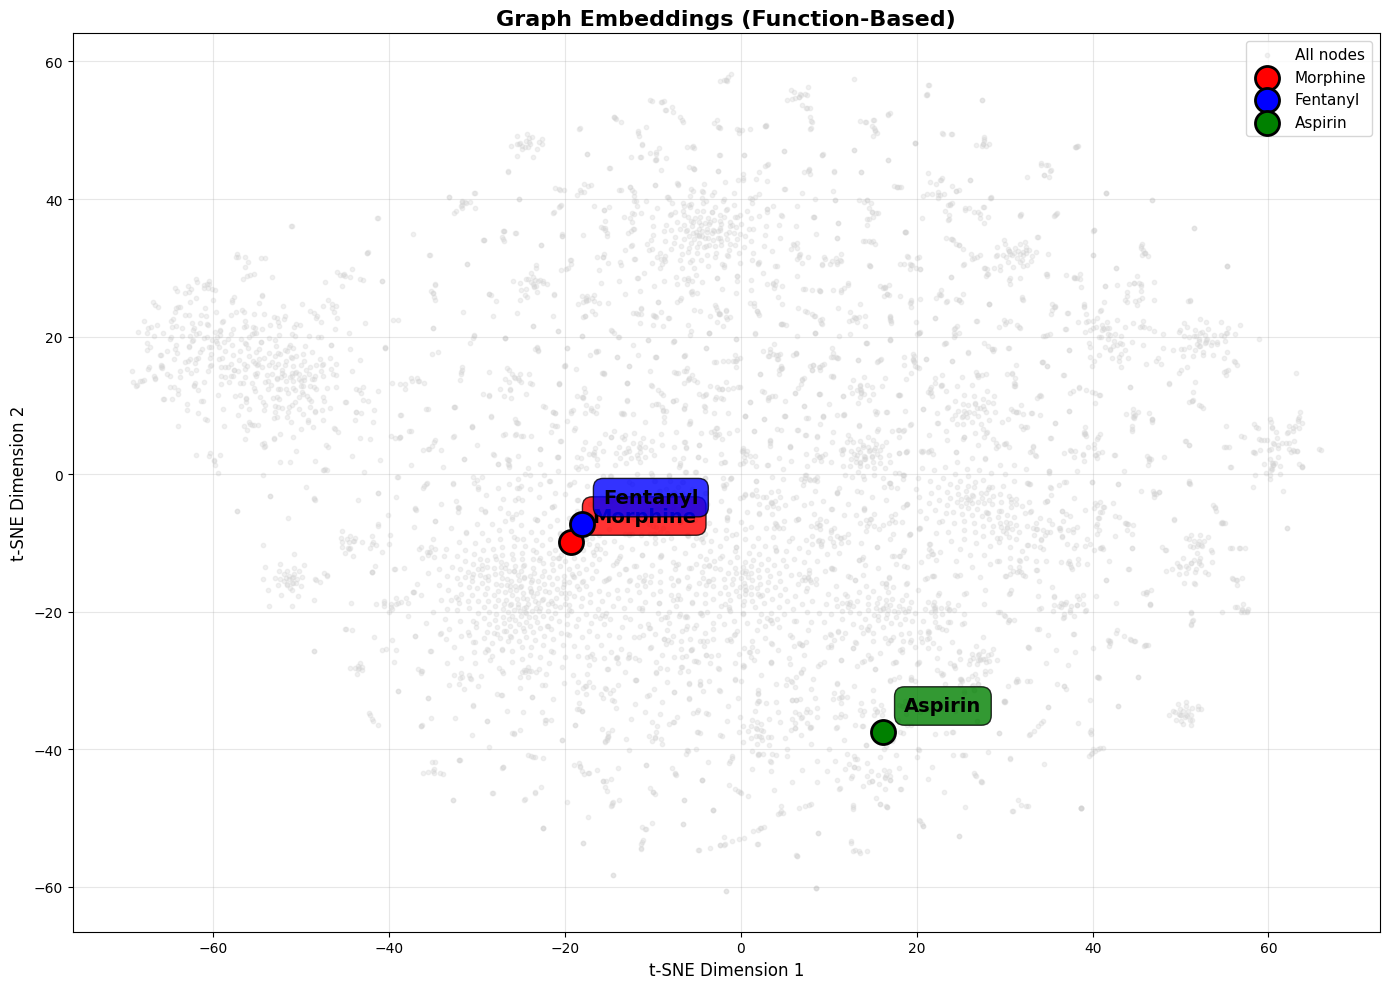


ANALYSIS

✅ Model learned that Morphine & Fentanyl are MORE similar than Aspirin
⚠️  BUT similarities are low (0.19 vs 0.16)

Why low similarities?
  - TransE uses L2 distance, not cosine similarity
  - Only 100 epochs of training
  - Could improve with more training or better model


In [127]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

print("="*80)
print("VISUALIZING EMBEDDINGS")
print("="*80)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ Done")

# Create visualization
fig, ax = plt.subplots(figsize=(14, 10))

# Plot all nodes
ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], 
          c='lightgray', s=10, alpha=0.3, label='All nodes')

# Highlight gold drugs
colors = {'Morphine': 'red', 'Fentanyl': 'blue', 'Aspirin': 'green'}
for drug_name, idx in gold_indices.items():
    x, y = embeddings_2d[idx]
    ax.scatter(x, y, c=colors[drug_name], s=300, 
              edgecolors='black', linewidths=2, label=drug_name, zorder=5)
    ax.annotate(drug_name, (x, y), 
               xytext=(15, 15), textcoords='offset points',
               fontsize=14, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.5', 
                        facecolor=colors[drug_name], alpha=0.8))

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Graph Embeddings (Function-Based)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('graph_visualization.png', dpi=300)
print("✓ Saved graph_visualization.png")
plt.show()

print("\n" + "="*80)
print("ANALYSIS")
print("="*80)
print("\n✅ Model learned that Morphine & Fentanyl are MORE similar than Aspirin")
print("⚠️  BUT similarities are low (0.19 vs 0.16)")
print("\nWhy low similarities?")
print("  - TransE uses L2 distance, not cosine similarity")
print("  - Only 100 epochs of training")
print("  - Could improve with more training or better model")

In [129]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("RANDOM DRUG NEAREST NEIGHBORS")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"Total drug nodes in graph: {len(drug_nodes)}")

# Randomly pick 5 drugs
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

# Create reverse mapping: internal_id -> drug info
# Use approved_drugs instead of drugs_df
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

print("\nFinding nearest neighbors for 5 random drugs...\n")

for i, drug_internal_id in enumerate(random_drugs, 1):
    # Get drug info
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Get embedding index
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    print(f"{i}. {drug_name} ({chembl_id})")
    print("   " + "-"*60)
    
    # Compute similarities to all other drugs
    similarities = []
    for other_internal_id in drug_nodes:
        if other_internal_id == drug_internal_id:
            continue
        if other_internal_id not in node_to_idx:
            continue
        
        other_idx = node_to_idx[other_internal_id]
        other_emb = embeddings[other_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl))
    
    # Get top 3
    similarities.sort(reverse=True)
    top_3 = similarities[:3]
    
    print("   Top 3 most similar drugs:")
    for rank, (sim, name, chembl) in enumerate(top_3, 1):
        print(f"      {rank}. {name} ({chembl}): similarity = {sim:.4f}")
    
    print()

print("="*80)

RANDOM DRUG NEAREST NEIGHBORS
Total drug nodes in graph: 2483

Finding nearest neighbors for 5 random drugs...

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027)
   ------------------------------------------------------------
   Top 3 most similar drugs:
      1. TIOTROPIUM BROMIDE (CHEMBL3545181): similarity = 0.4911
      2. TROPICAMIDE (CHEMBL1200604): similarity = 0.4624
      3. DIPHEMANIL (CHEMBL1201340): similarity = 0.4438

2. RIMONABANT (CHEMBL111)
   ------------------------------------------------------------
   Top 3 most similar drugs:
      1. ORLISTAT (CHEMBL175247): similarity = 0.4496
      2. GLIPIZIDE (CHEMBL1073): similarity = 0.4351
      3. DIETHYLPROPION (CHEMBL1194666): similarity = 0.4193

3. ACYCLOVIR (CHEMBL184)
   ------------------------------------------------------------
   Top 3 most similar drugs:
      1. FAMCICLOVIR (CHEMBL880): similarity = 0.4540
      2. TRIFLURIDINE (CHEMBL1129): similarity = 0.4124
      3. VALACYCLOVIR (CHEMBL1349): similarity = 0.3638


ENHANCED DRUG VISUALIZATION
Computing t-SNE...
✓ Done

Node counts:
  Drugs: 2483
  Proteins: 1145
  Effects: 983

✓ Saved graph_embeddings_visualization.png


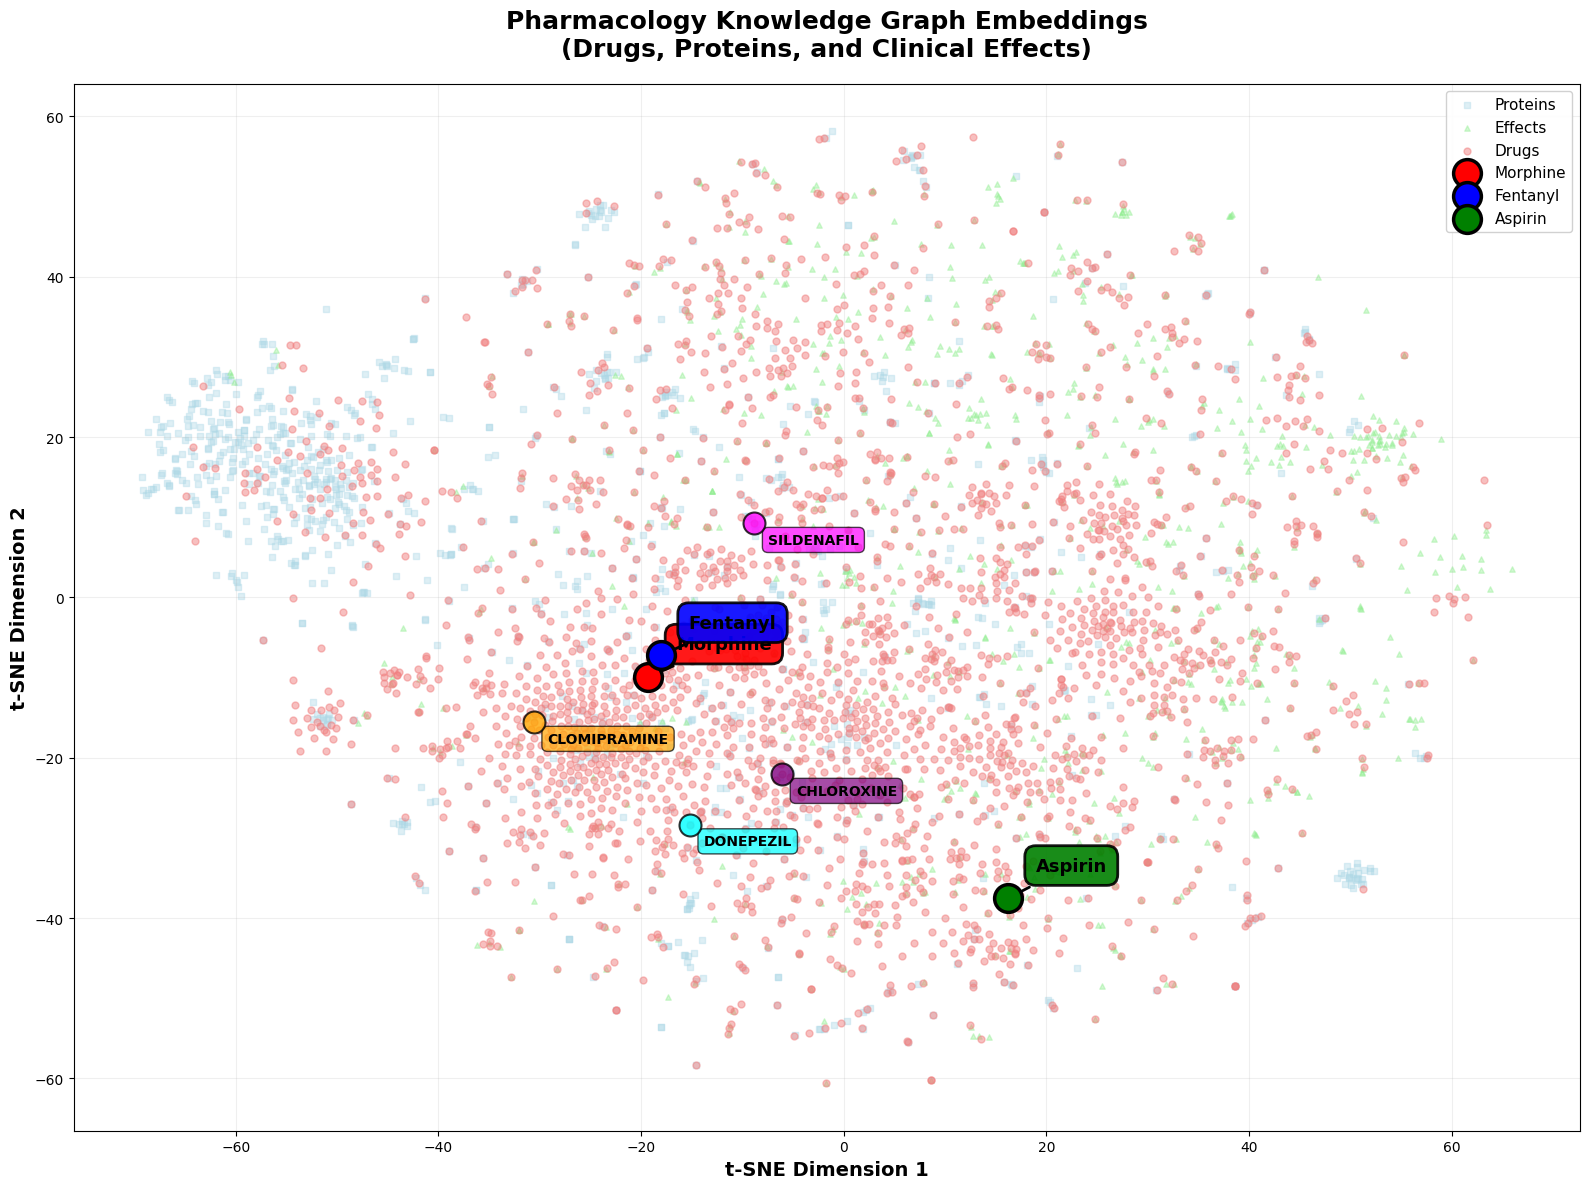


VISUALIZATION COMPLETE


In [130]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

print("="*80)
print("ENHANCED DRUG VISUALIZATION")
print("="*80)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ Done")

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']
effect_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'effect']

print(f"\nNode counts:")
print(f"  Drugs: {len(drug_nodes)}")
print(f"  Proteins: {len(protein_nodes_list)}")
print(f"  Effects: {len(effect_nodes)}")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Create visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Separate coordinates by node type
drug_coords = []
protein_coords = []
effect_coords = []

for node in G_main.nodes():
    idx = node_to_idx[node]
    node_type = G_main.nodes[node].get('node_type')
    
    if node_type == 'drug':
        drug_coords.append(embeddings_2d[idx])
    elif node_type == 'protein':
        protein_coords.append(embeddings_2d[idx])
    elif node_type == 'effect':
        effect_coords.append(embeddings_2d[idx])

# Convert to arrays
drug_coords = np.array(drug_coords)
protein_coords = np.array(protein_coords)
effect_coords = np.array(effect_coords)

# Plot by node type
ax.scatter(protein_coords[:, 0], protein_coords[:, 1], 
          c='lightblue', s=15, alpha=0.4, label='Proteins', marker='s')
ax.scatter(effect_coords[:, 0], effect_coords[:, 1], 
          c='lightgreen', s=15, alpha=0.4, label='Effects', marker='^')
ax.scatter(drug_coords[:, 0], drug_coords[:, 1], 
          c='lightcoral', s=25, alpha=0.5, label='Drugs', marker='o')

# Highlight gold standard drugs
gold_drugs = {
    'CHEMBL70': 'Morphine',
    'CHEMBL596': 'Fentanyl', 
    'CHEMBL25': 'Aspirin'
}

colors = {'Morphine': 'red', 'Fentanyl': 'blue', 'Aspirin': 'green'}
gold_indices = {}

for chembl_id, drug_name in gold_drugs.items():
    chembl_to_internal = dict(zip(approved_drugs['drug_id'], approved_drugs['drug_internal_id']))
    if chembl_id in chembl_to_internal:
        internal_id = chembl_to_internal[chembl_id]
        if internal_id in node_to_idx:
            idx = node_to_idx[internal_id]
            gold_indices[drug_name] = idx
            x, y = embeddings_2d[idx]
            ax.scatter(x, y, c=colors[drug_name], s=400, 
                      edgecolors='black', linewidths=2.5, label=drug_name, zorder=10)
            ax.annotate(drug_name, (x, y), 
                       xytext=(20, 20), textcoords='offset points',
                       fontsize=13, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.6', 
                                facecolor=colors[drug_name], alpha=0.9, edgecolor='black', linewidth=2),
                       arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Pick some interesting drugs to highlight
interesting_drugs = [
    'CHEMBL415', # Ibuprofen
    'CHEMBL1200596', # Paracetamol/Acetaminophen
    'CHEMBL1201055', # Penicillin V
    'CHEMBL192', # Metformin
    'CHEMBL502', # Warfarin
]

highlight_colors = ['orange', 'purple', 'brown', 'magenta', 'cyan']

for chembl_id, color in zip(interesting_drugs, highlight_colors):
    chembl_to_internal = dict(zip(approved_drugs['drug_id'], approved_drugs['drug_internal_id']))
    if chembl_id in chembl_to_internal:
        internal_id = chembl_to_internal[chembl_id]
        if internal_id in node_to_idx:
            idx = node_to_idx[internal_id]
            x, y = embeddings_2d[idx]
            chembl_id_val, drug_name = internal_to_info.get(internal_id, (chembl_id, 'Unknown'))
            ax.scatter(x, y, c=color, s=250, 
                      edgecolors='black', linewidths=1.5, alpha=0.8, zorder=9)
            ax.annotate(drug_name, (x, y), 
                       xytext=(10, -15), textcoords='offset points',
                       fontsize=10, fontweight='bold',
                       bbox=dict(boxstyle='round,pad=0.4', 
                                facecolor=color, alpha=0.7, edgecolor='black', linewidth=1))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Pharmacology Knowledge Graph Embeddings\n(Drugs, Proteins, and Clinical Effects)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=11, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('graph_embeddings_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved graph_embeddings_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

In [131]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("RANDOM DRUG NEAREST NEIGHBORS - TOP 5")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"Total drug nodes in graph: {len(drug_nodes)}")

# Randomly pick 5 drugs
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

print("\nFinding top 5 nearest neighbors for 5 random drugs...\n")

for i, drug_internal_id in enumerate(random_drugs, 1):
    # Get drug info
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Get embedding index
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    print(f"{i}. {drug_name} ({chembl_id})")
    print("   " + "-"*70)
    
    # Compute similarities to all other drugs
    similarities = []
    for other_internal_id in drug_nodes:
        if other_internal_id == drug_internal_id:
            continue
        if other_internal_id not in node_to_idx:
            continue
        
        other_idx = node_to_idx[other_internal_id]
        other_emb = embeddings[other_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl))
    
    # Get top 5
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    print("   Top 5 most similar drugs:")
    for rank, (sim, name, chembl) in enumerate(top_5, 1):
        print(f"      {rank}. {name:40s} ({chembl:15s}) similarity = {sim:.4f}")
    
    print()

print("="*80)

RANDOM DRUG NEAREST NEIGHBORS - TOP 5
Total drug nodes in graph: 2483

Finding top 5 nearest neighbors for 5 random drugs...

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027)
   ----------------------------------------------------------------------
   Top 5 most similar drugs:
      1. TIOTROPIUM BROMIDE                       (CHEMBL3545181  ) similarity = 0.4911
      2. TROPICAMIDE                              (CHEMBL1200604  ) similarity = 0.4624
      3. DIPHEMANIL                               (CHEMBL1201340  ) similarity = 0.4438
      4. UMECLIDINIUM BROMIDE                     (CHEMBL523299   ) similarity = 0.4434
      5. ACLIDINIUM BROMIDE                       (CHEMBL551466   ) similarity = 0.4383

2. RIMONABANT (CHEMBL111)
   ----------------------------------------------------------------------
   Top 5 most similar drugs:
      1. ORLISTAT                                 (CHEMBL175247   ) similarity = 0.4496
      2. GLIPIZIDE                                (CHEMBL1073     ) sim

ENHANCED DRUG VISUALIZATION WITH NEAREST NEIGHBORS
Computing t-SNE...
✓ Done

Node counts:
  Drugs: 2483
  Proteins: 1145
  Effects: 983

Finding random drugs and their neighbors...

✓ Saved drug_neighbors_visualization.png


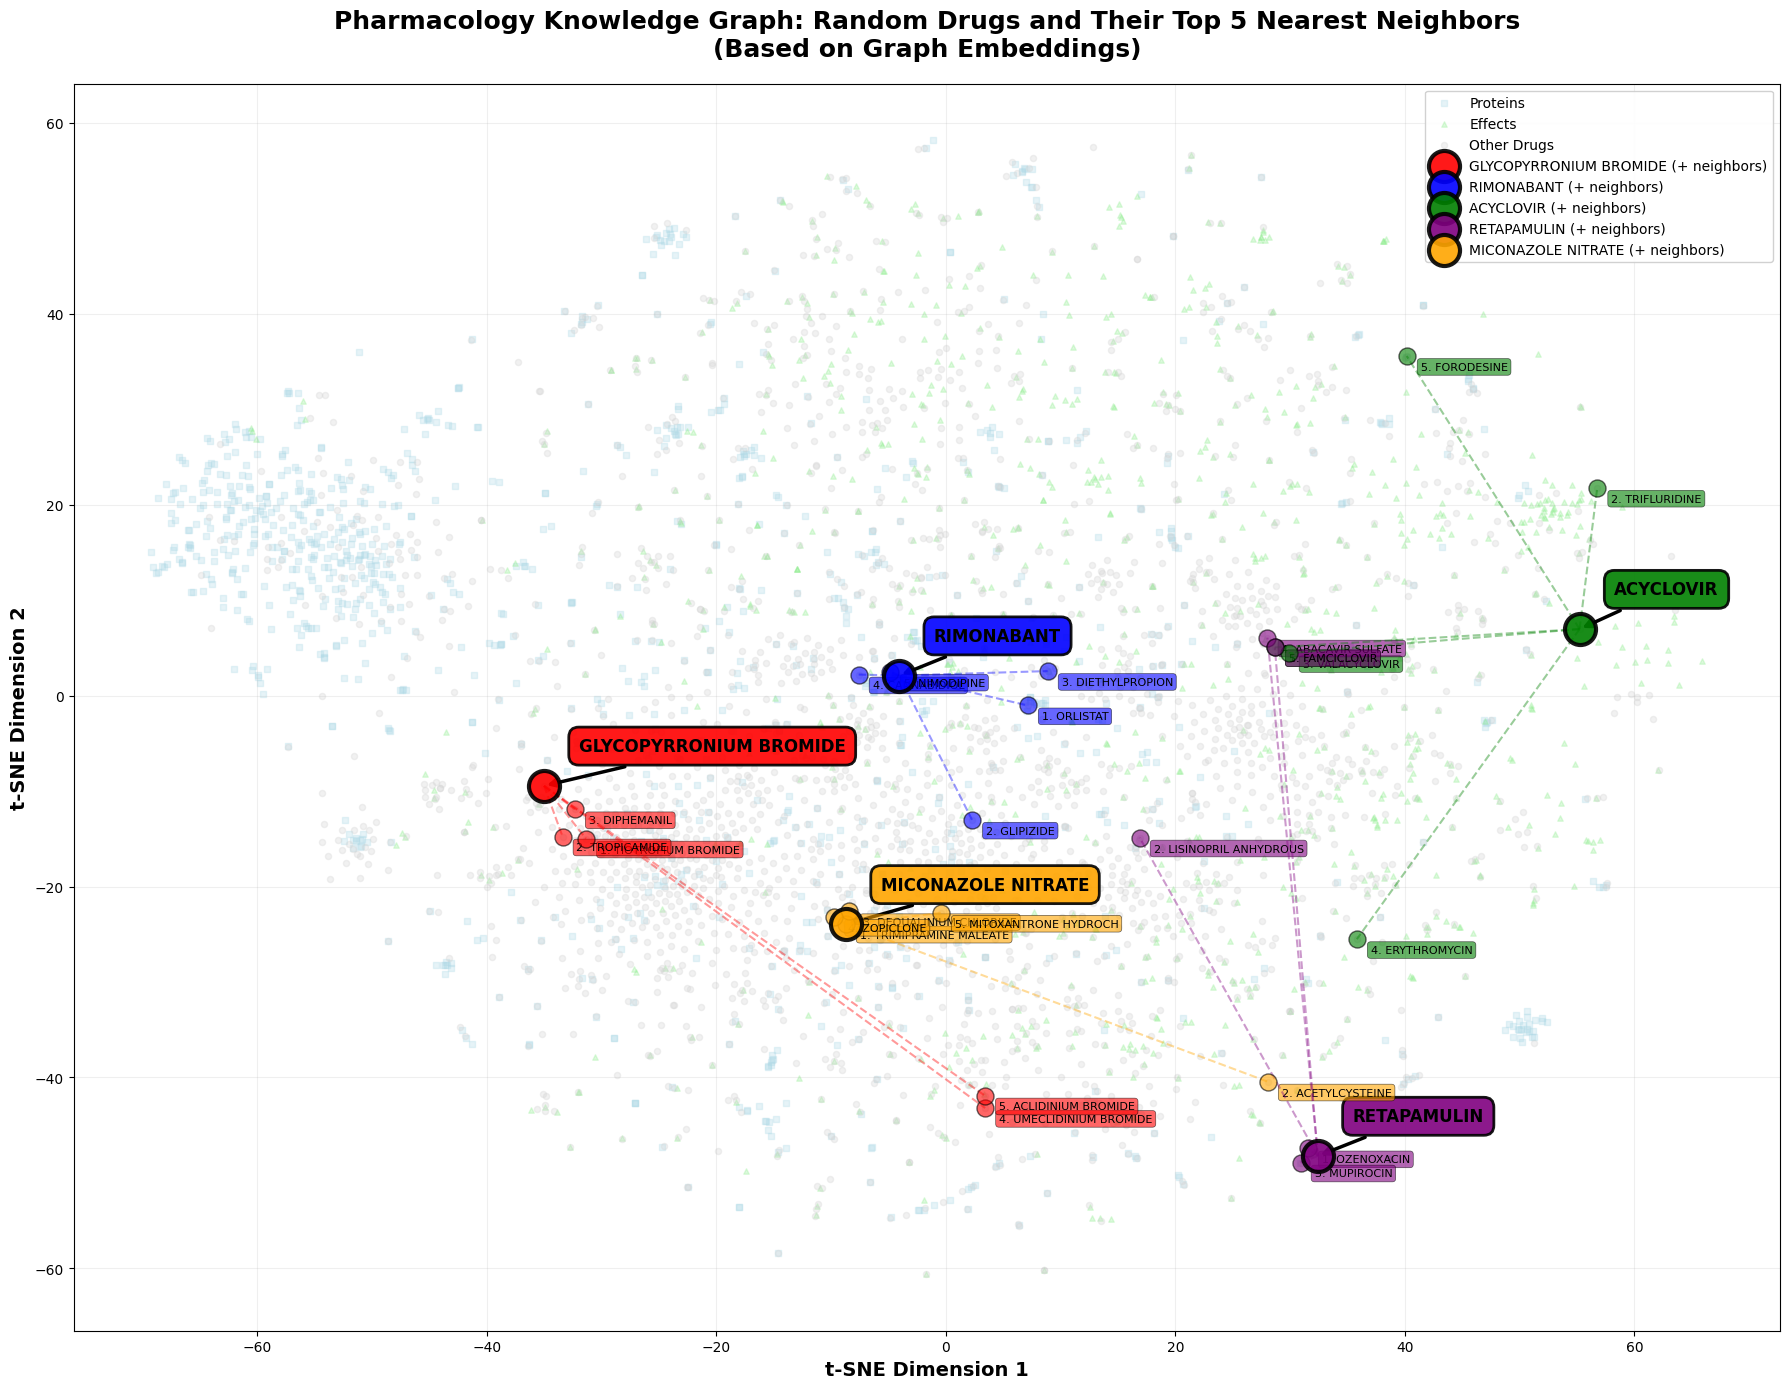


VISUALIZATION COMPLETE

Summary of visualized drug clusters:

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027):
   1. TIOTROPIUM BROMIDE                       (similarity: 0.4911)
   2. TROPICAMIDE                              (similarity: 0.4624)
   3. DIPHEMANIL                               (similarity: 0.4438)
   4. UMECLIDINIUM BROMIDE                     (similarity: 0.4434)
   5. ACLIDINIUM BROMIDE                       (similarity: 0.4383)

2. RIMONABANT (CHEMBL111):
   1. ORLISTAT                                 (similarity: 0.4496)
   2. GLIPIZIDE                                (similarity: 0.4351)
   3. DIETHYLPROPION                           (similarity: 0.4193)
   4. CANNABIDIOL                              (similarity: 0.3997)
   5. NIMODIPINE                               (similarity: 0.3668)

3. ACYCLOVIR (CHEMBL184):
   1. FAMCICLOVIR                              (similarity: 0.4540)
   2. TRIFLURIDINE                             (similarity: 0.4124)
   3. VALACYCLOVIR     

In [132]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("ENHANCED DRUG VISUALIZATION WITH NEAREST NEIGHBORS")
print("="*80)

# Compute t-SNE
print("Computing t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)
print("✓ Done")

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']
effect_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'effect']

print(f"\nNode counts:")
print(f"  Drugs: {len(drug_nodes)}")
print(f"  Proteins: {len(protein_nodes_list)}")
print(f"  Effects: {len(effect_nodes)}")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Randomly pick 5 drugs and find their top 5 neighbors
print("\nFinding random drugs and their neighbors...")
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

random_drug_data = []
for drug_internal_id in random_drugs:
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    # Find top 5 neighbors
    similarities = []
    for other_internal_id in drug_nodes:
        if other_internal_id == drug_internal_id:
            continue
        if other_internal_id not in node_to_idx:
            continue
        
        other_idx = node_to_idx[other_internal_id]
        other_emb = embeddings[other_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl, other_internal_id, other_idx))
    
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    random_drug_data.append({
        'name': drug_name,
        'chembl': chembl_id,
        'internal_id': drug_internal_id,
        'idx': drug_idx,
        'neighbors': top_5
    })

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Separate coordinates by node type
drug_coords = []
protein_coords = []
effect_coords = []

for node in G_main.nodes():
    idx = node_to_idx[node]
    node_type = G_main.nodes[node].get('node_type')
    
    if node_type == 'drug':
        drug_coords.append(embeddings_2d[idx])
    elif node_type == 'protein':
        protein_coords.append(embeddings_2d[idx])
    elif node_type == 'effect':
        effect_coords.append(embeddings_2d[idx])

# Convert to arrays
drug_coords = np.array(drug_coords)
protein_coords = np.array(protein_coords)
effect_coords = np.array(effect_coords)

# Plot by node type (background)
ax.scatter(protein_coords[:, 0], protein_coords[:, 1], 
          c='lightblue', s=15, alpha=0.3, label='Proteins', marker='s')
ax.scatter(effect_coords[:, 0], effect_coords[:, 1], 
          c='lightgreen', s=15, alpha=0.3, label='Effects', marker='^')
ax.scatter(drug_coords[:, 0], drug_coords[:, 1], 
          c='lightgray', s=20, alpha=0.3, label='Other Drugs', marker='o')

# Define colors for random drugs
main_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot random drugs and their neighbors
for i, drug_data in enumerate(random_drug_data):
    main_color = main_colors[i]
    
    # Plot main drug (larger)
    x_main, y_main = embeddings_2d[drug_data['idx']]
    ax.scatter(x_main, y_main, c=main_color, s=500, 
              edgecolors='black', linewidths=3, alpha=0.9, zorder=10,
              label=f"{drug_data['name']} (+ neighbors)")
    
    # Annotate main drug
    ax.annotate(drug_data['name'], (x_main, y_main), 
               xytext=(25, 25), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.6', 
                        facecolor=main_color, alpha=0.9, 
                        edgecolor='black', linewidth=2),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Plot top 5 neighbors (smaller, same color family)
    for rank, (sim, neighbor_name, neighbor_chembl, neighbor_internal_id, neighbor_idx) in enumerate(drug_data['neighbors'], 1):
        x_neighbor, y_neighbor = embeddings_2d[neighbor_idx]
        
        # Draw connecting line
        ax.plot([x_main, x_neighbor], [y_main, y_neighbor], 
               color=main_color, alpha=0.4, linewidth=1.5, linestyle='--', zorder=5)
        
        # Plot neighbor
        ax.scatter(x_neighbor, y_neighbor, c=main_color, s=150, 
                  edgecolors='black', linewidths=1, alpha=0.6, zorder=8)
        
        # Annotate neighbor with rank
        ax.annotate(f"{rank}. {neighbor_name[:20]}", (x_neighbor, y_neighbor), 
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=main_color, alpha=0.6, 
                            edgecolor='black', linewidth=0.5))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Pharmacology Knowledge Graph: Random Drugs and Their Top 5 Nearest Neighbors\n(Based on Graph Embeddings)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('drug_neighbors_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved drug_neighbors_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

# Print summary
print("\nSummary of visualized drug clusters:")
for i, drug_data in enumerate(random_drug_data, 1):
    print(f"\n{i}. {drug_data['name']} ({drug_data['chembl']}):")
    for rank, (sim, name, chembl, _, _) in enumerate(drug_data['neighbors'], 1):
        print(f"   {rank}. {name:40s} (similarity: {sim:.4f})")

DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS

Total drug nodes: 2483
Drug embeddings shape: (2483, 128)

Computing t-SNE for drugs only...
✓ Done

Finding random drugs and their neighbors...

✓ Saved drug_neighbors_visualization.png


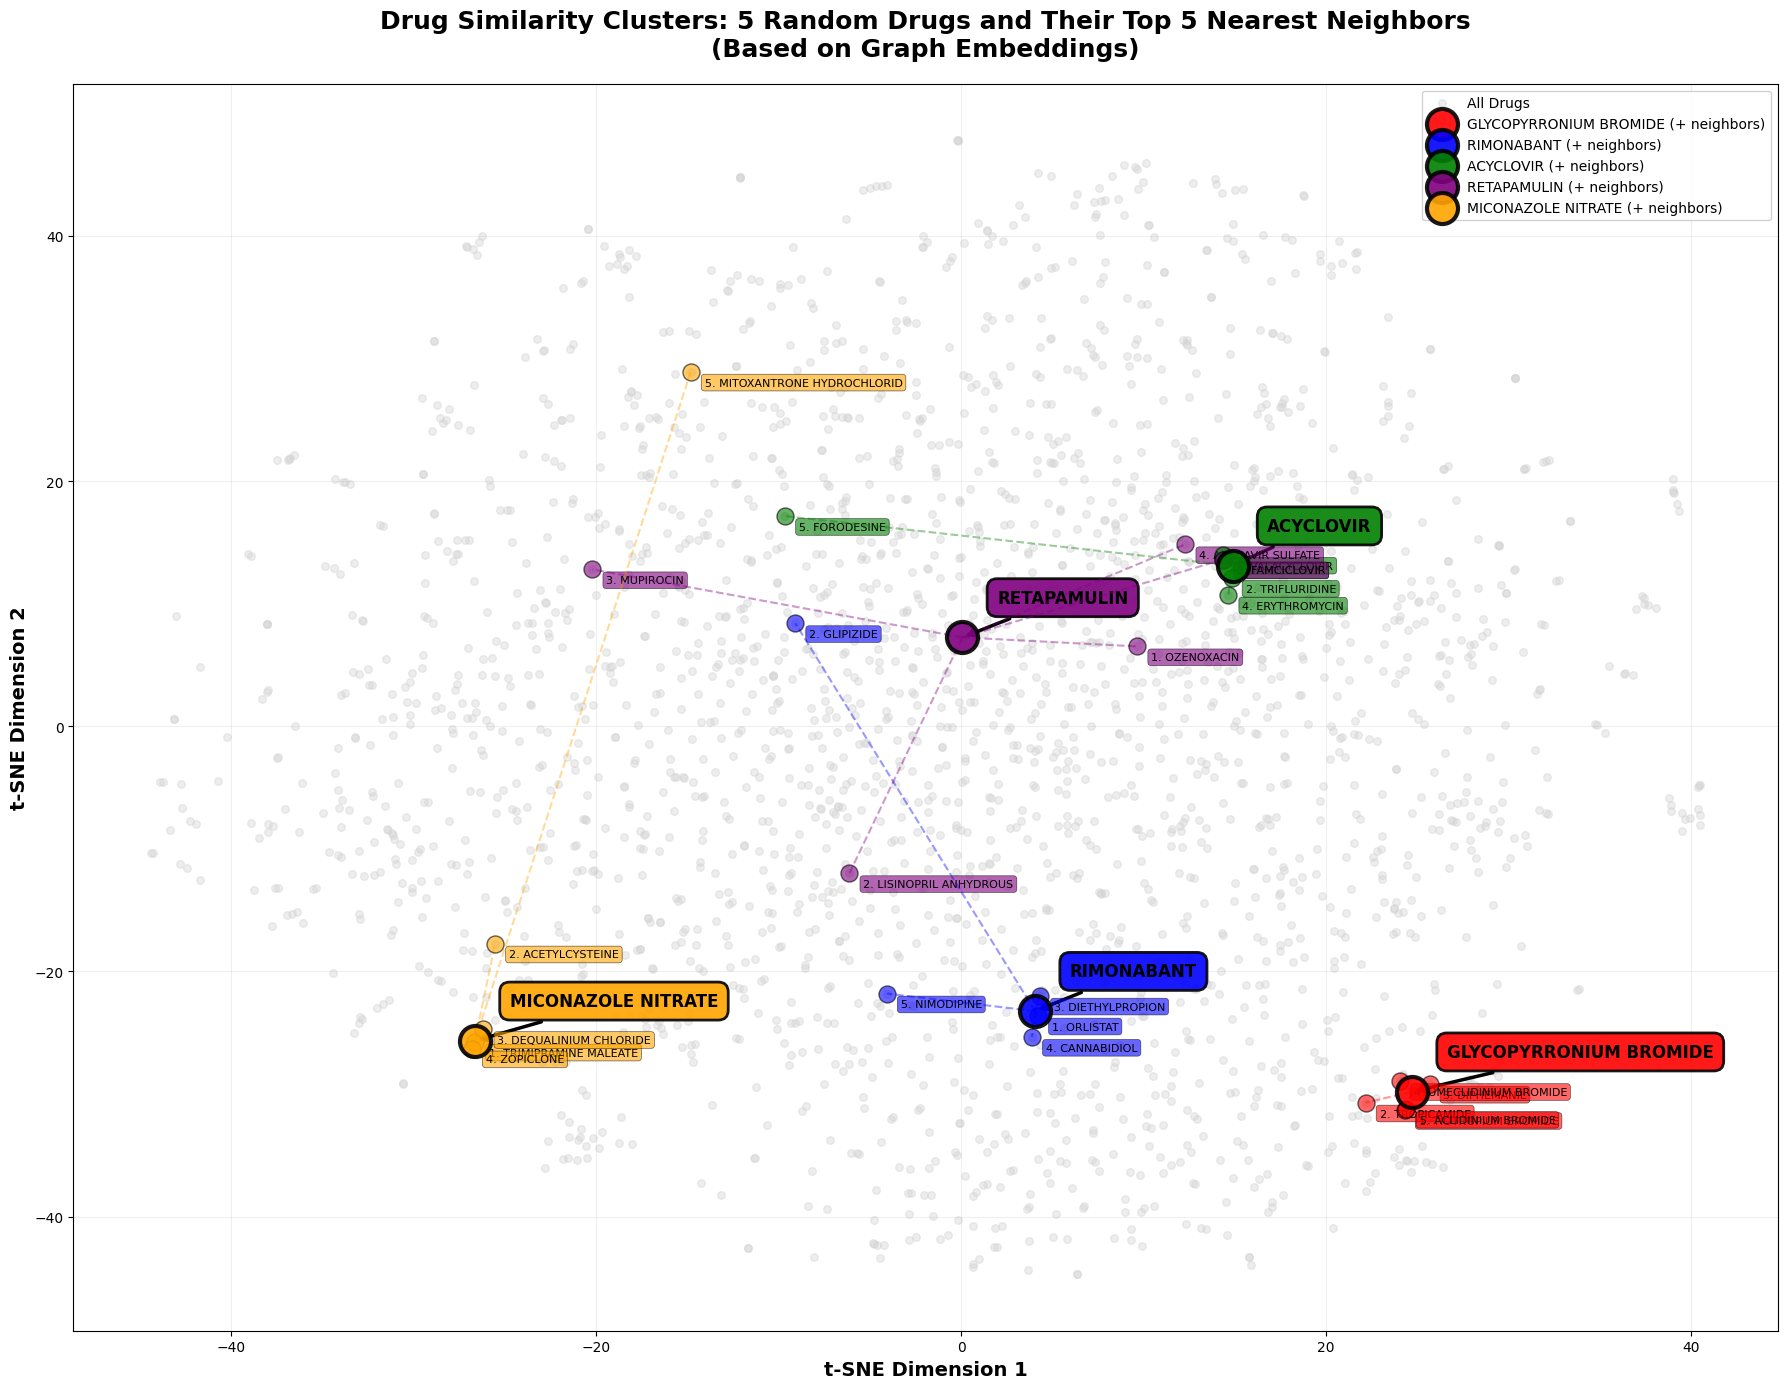


VISUALIZATION COMPLETE

Summary of visualized drug clusters:

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027):
   1. TIOTROPIUM BROMIDE                       (similarity: 0.4911)
   2. TROPICAMIDE                              (similarity: 0.4624)
   3. DIPHEMANIL                               (similarity: 0.4438)
   4. UMECLIDINIUM BROMIDE                     (similarity: 0.4434)
   5. ACLIDINIUM BROMIDE                       (similarity: 0.4383)

2. RIMONABANT (CHEMBL111):
   1. ORLISTAT                                 (similarity: 0.4496)
   2. GLIPIZIDE                                (similarity: 0.4351)
   3. DIETHYLPROPION                           (similarity: 0.4193)
   4. CANNABIDIOL                              (similarity: 0.3997)
   5. NIMODIPINE                               (similarity: 0.3668)

3. ACYCLOVIR (CHEMBL184):
   1. FAMCICLOVIR                              (similarity: 0.4540)
   2. TRIFLURIDINE                             (similarity: 0.4124)
   3. VALACYCLOVIR     

In [133]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"\nTotal drug nodes: {len(drug_nodes)}")

# Extract only drug embeddings
drug_indices = []
drug_internal_ids = []

for node in drug_nodes:
    idx = node_to_idx[node]
    drug_indices.append(idx)
    drug_internal_ids.append(node)

drug_embeddings = embeddings[drug_indices]
print(f"Drug embeddings shape: {drug_embeddings.shape}")

# Compute t-SNE only on drug embeddings
print("\nComputing t-SNE for drugs only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(drug_nodes)-1))
drug_embeddings_2d = tsne.fit_transform(drug_embeddings)
print("✓ Done")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Randomly pick 5 drugs and find their top 5 neighbors
print("\nFinding random drugs and their neighbors...")
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

random_drug_data = []
for drug_internal_id in random_drugs:
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Find the index in drug_nodes list
    drug_list_idx = drug_internal_ids.index(drug_internal_id)
    drug_emb = drug_embeddings[drug_list_idx].reshape(1, -1)
    
    # Find top 5 neighbors among all drugs
    similarities = []
    for other_list_idx, other_internal_id in enumerate(drug_internal_ids):
        if other_internal_id == drug_internal_id:
            continue
        
        other_emb = drug_embeddings[other_list_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl, other_internal_id, other_list_idx))
    
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    random_drug_data.append({
        'name': drug_name,
        'chembl': chembl_id,
        'internal_id': drug_internal_id,
        'idx': drug_list_idx,
        'neighbors': top_5
    })

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Plot all drugs as background
ax.scatter(drug_embeddings_2d[:, 0], drug_embeddings_2d[:, 1], 
          c='lightgray', s=30, alpha=0.4, label='All Drugs', marker='o')

# Define colors for random drugs
main_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot random drugs and their neighbors
for i, drug_data in enumerate(random_drug_data):
    main_color = main_colors[i]
    
    # Plot main drug (larger)
    x_main, y_main = drug_embeddings_2d[drug_data['idx']]
    ax.scatter(x_main, y_main, c=main_color, s=500, 
              edgecolors='black', linewidths=3, alpha=0.9, zorder=10,
              label=f"{drug_data['name']} (+ neighbors)")
    
    # Annotate main drug
    ax.annotate(drug_data['name'], (x_main, y_main), 
               xytext=(25, 25), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.6', 
                        facecolor=main_color, alpha=0.9, 
                        edgecolor='black', linewidth=2),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Plot top 5 neighbors (smaller, same color family)
    for rank, (sim, neighbor_name, neighbor_chembl, neighbor_internal_id, neighbor_list_idx) in enumerate(drug_data['neighbors'], 1):
        x_neighbor, y_neighbor = drug_embeddings_2d[neighbor_list_idx]
        
        # Draw connecting line
        ax.plot([x_main, x_neighbor], [y_main, y_neighbor], 
               color=main_color, alpha=0.4, linewidth=1.5, linestyle='--', zorder=5)
        
        # Plot neighbor
        ax.scatter(x_neighbor, y_neighbor, c=main_color, s=150, 
                  edgecolors='black', linewidths=1, alpha=0.6, zorder=8)
        
        # Annotate neighbor with rank
        ax.annotate(f"{rank}. {neighbor_name[:25]}", (x_neighbor, y_neighbor), 
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=main_color, alpha=0.6, 
                            edgecolor='black', linewidth=0.5))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Drug Similarity Clusters: 5 Random Drugs and Their Top 5 Nearest Neighbors\n(Based on Graph Embeddings)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('drug_neighbors_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved drug_neighbors_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

# Print summary
print("\nSummary of visualized drug clusters:")
for i, drug_data in enumerate(random_drug_data, 1):
    print(f"\n{i}. {drug_data['name']} ({drug_data['chembl']}):")
    for rank, (sim, name, chembl, _, _) in enumerate(drug_data['neighbors'], 1):
        print(f"   {rank}. {name:40s} (similarity: {sim:.4f})")

DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS

Total drug nodes: 2483
Drug embeddings shape: (2483, 128)

Computing t-SNE for drugs only...
✓ Done

Finding random drugs and their neighbors...

✓ Saved drug_neighbors_visualization.png


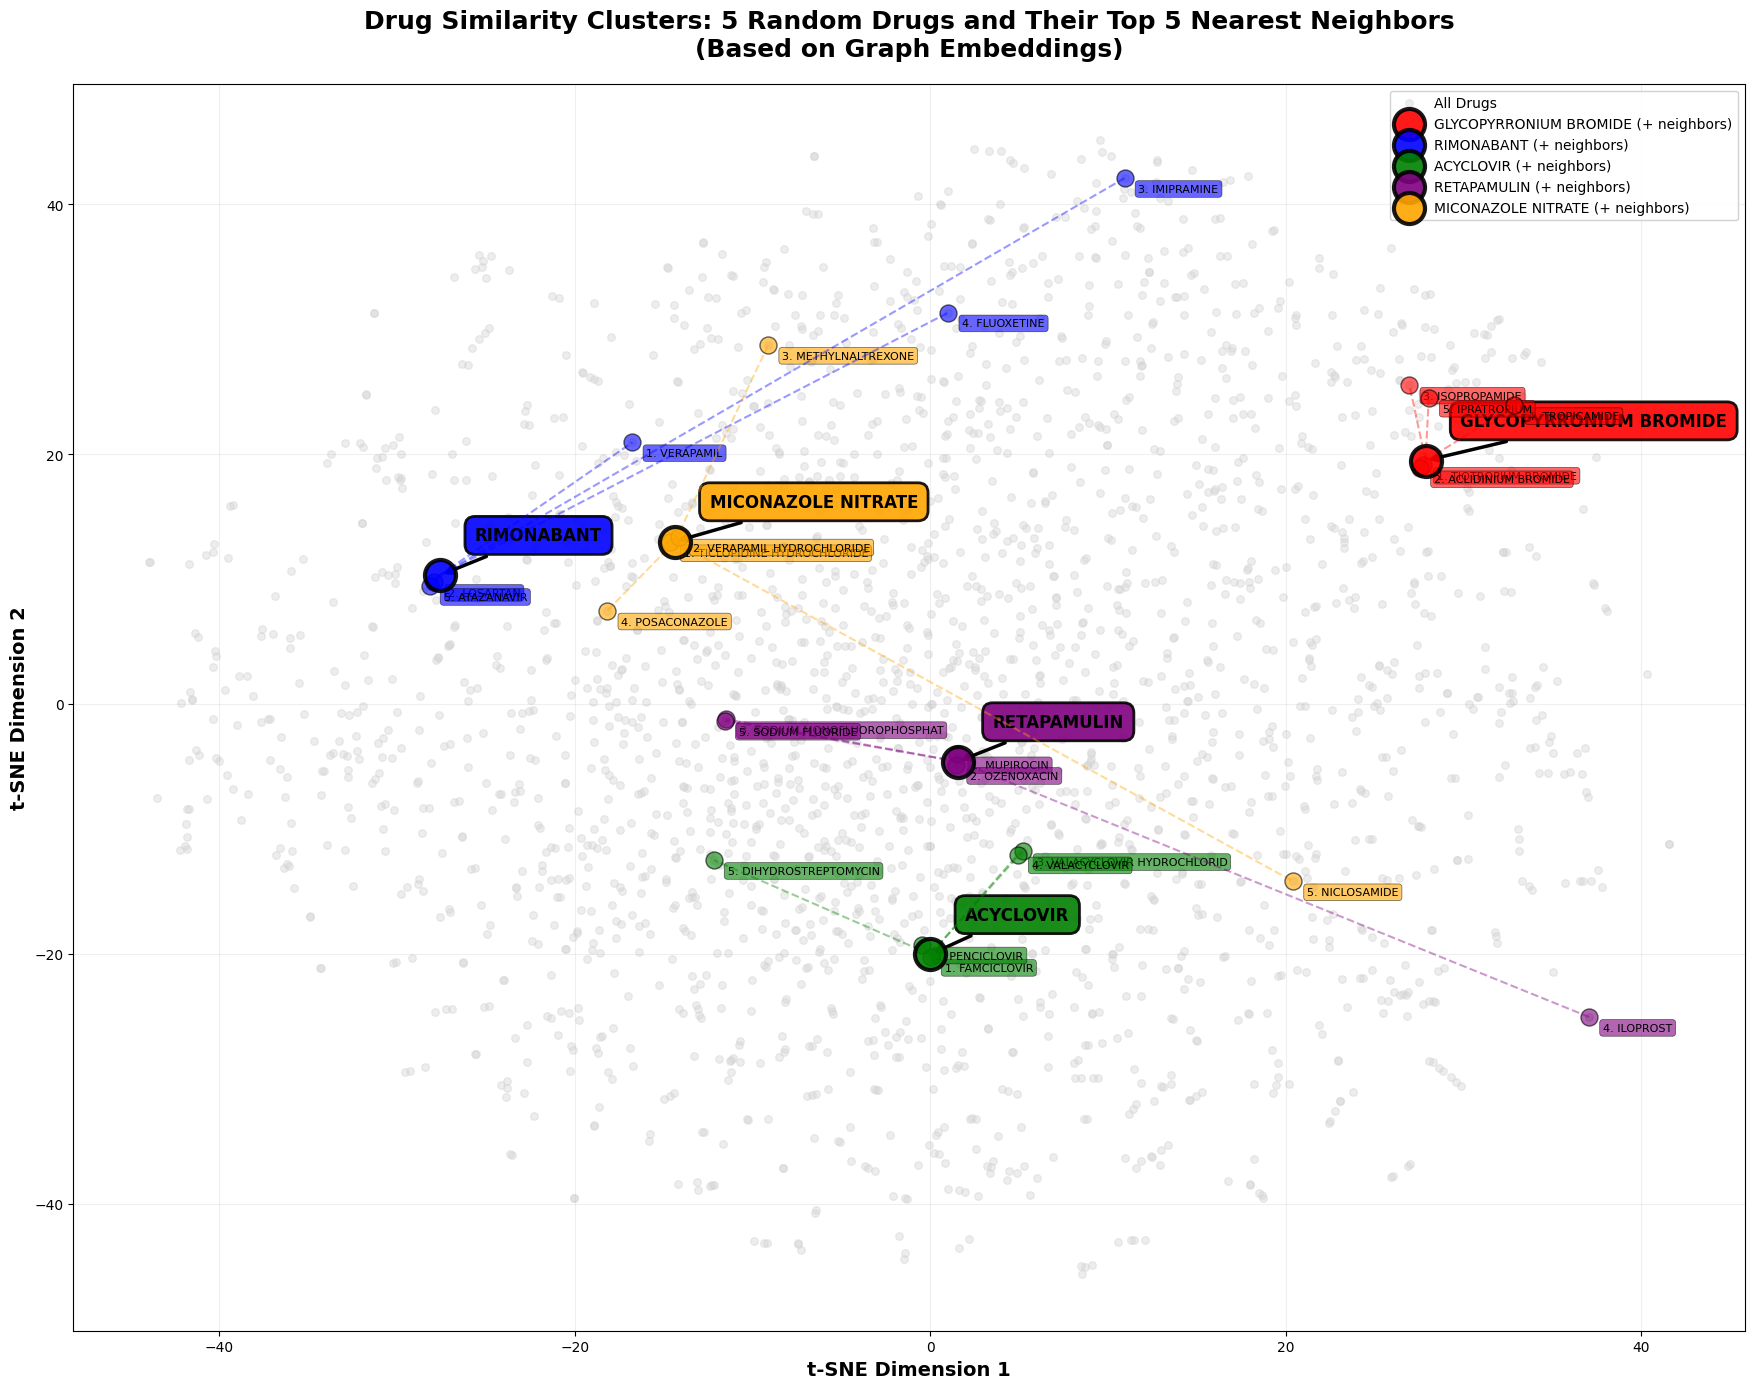


VISUALIZATION COMPLETE

Summary of visualized drug clusters:

1. GLYCOPYRRONIUM BROMIDE (CHEMBL1201027):
   1. TIOTROPIUM BROMIDE                       (similarity: 0.5107)
   2. ACLIDINIUM BROMIDE                       (similarity: 0.4198)
   3. ISOPROPAMIDE                             (similarity: 0.4124)
   4. TROPICAMIDE                              (similarity: 0.4067)
   5. IPRATROPIUM                              (similarity: 0.3930)

2. RIMONABANT (CHEMBL111):
   1. VERAPAMIL                                (similarity: 0.4125)
   2. LOSARTAN                                 (similarity: 0.3755)
   3. IMIPRAMINE                               (similarity: 0.3600)
   4. FLUOXETINE                               (similarity: 0.3320)
   5. ATAZANAVIR                               (similarity: 0.3258)

3. ACYCLOVIR (CHEMBL184):
   1. FAMCICLOVIR                              (similarity: 0.5186)
   2. PENCICLOVIR                              (similarity: 0.4172)
   3. VALACYCLOVIR HYDR

In [135]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import random
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("DRUG-ONLY VISUALIZATION WITH NEAREST NEIGHBORS")
print("="*80)

# Get all drug nodes from the graph
drug_nodes = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
print(f"\nTotal drug nodes: {len(drug_nodes)}")

# Extract only drug embeddings
drug_indices = []
drug_internal_ids = []

for node in drug_nodes:
    idx = node_to_idx[node]
    drug_indices.append(idx)
    drug_internal_ids.append(node)

drug_embeddings = embeddings[drug_indices]
print(f"Drug embeddings shape: {drug_embeddings.shape}")

# Compute t-SNE only on drug embeddings
print("\nComputing t-SNE for drugs only...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(drug_nodes)-1))
drug_embeddings_2d = tsne.fit_transform(drug_embeddings)
print("✓ Done")

# Create reverse mapping: internal_id -> drug info
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

# Randomly pick 5 drugs and find their top 5 neighbors
print("\nFinding random drugs and their neighbors...")
random.seed(42)
random_drugs = random.sample(drug_nodes, 5)

random_drug_data = []
for drug_internal_id in random_drugs:
    if drug_internal_id not in internal_to_info:
        continue
    
    chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Find the index in drug_nodes list
    drug_list_idx = drug_internal_ids.index(drug_internal_id)
    drug_emb = drug_embeddings[drug_list_idx].reshape(1, -1)
    
    # Find top 5 neighbors among all drugs
    similarities = []
    for other_list_idx, other_internal_id in enumerate(drug_internal_ids):
        if other_internal_id == drug_internal_id:
            continue
        
        other_emb = drug_embeddings[other_list_idx].reshape(1, -1)
        sim = cosine_similarity(drug_emb, other_emb)[0][0]
        
        if other_internal_id in internal_to_info:
            other_chembl, other_name = internal_to_info[other_internal_id]
            similarities.append((sim, other_name, other_chembl, other_internal_id, other_list_idx))
    
    similarities.sort(reverse=True)
    top_5 = similarities[:5]
    
    random_drug_data.append({
        'name': drug_name,
        'chembl': chembl_id,
        'internal_id': drug_internal_id,
        'idx': drug_list_idx,
        'neighbors': top_5
    })

# Create visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Plot all drugs as background
ax.scatter(drug_embeddings_2d[:, 0], drug_embeddings_2d[:, 1], 
          c='lightgray', s=30, alpha=0.4, label='All Drugs', marker='o')

# Define colors for random drugs
main_colors = ['red', 'blue', 'green', 'purple', 'orange']

# Plot random drugs and their neighbors
for i, drug_data in enumerate(random_drug_data):
    main_color = main_colors[i]
    
    # Plot main drug (larger)
    x_main, y_main = drug_embeddings_2d[drug_data['idx']]
    ax.scatter(x_main, y_main, c=main_color, s=500, 
              edgecolors='black', linewidths=3, alpha=0.9, zorder=10,
              label=f"{drug_data['name']} (+ neighbors)")
    
    # Annotate main drug
    ax.annotate(drug_data['name'], (x_main, y_main), 
               xytext=(25, 25), textcoords='offset points',
               fontsize=12, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.6', 
                        facecolor=main_color, alpha=0.9, 
                        edgecolor='black', linewidth=2),
               arrowprops=dict(arrowstyle='->', lw=2.5, color='black'))
    
    # Plot top 5 neighbors (smaller, same color family)
    for rank, (sim, neighbor_name, neighbor_chembl, neighbor_internal_id, neighbor_list_idx) in enumerate(drug_data['neighbors'], 1):
        x_neighbor, y_neighbor = drug_embeddings_2d[neighbor_list_idx]
        
        # Draw connecting line
        ax.plot([x_main, x_neighbor], [y_main, y_neighbor], 
               color=main_color, alpha=0.4, linewidth=1.5, linestyle='--', zorder=5)
        
        # Plot neighbor
        ax.scatter(x_neighbor, y_neighbor, c=main_color, s=150, 
                  edgecolors='black', linewidths=1, alpha=0.6, zorder=8)
        
        # Annotate neighbor with rank
        ax.annotate(f"{rank}. {neighbor_name[:25]}", (x_neighbor, y_neighbor), 
                   xytext=(10, -10), textcoords='offset points',
                   fontsize=8, 
                   bbox=dict(boxstyle='round,pad=0.3', 
                            facecolor=main_color, alpha=0.6, 
                            edgecolor='black', linewidth=0.5))

ax.set_xlabel('t-SNE Dimension 1', fontsize=14, fontweight='bold')
ax.set_ylabel('t-SNE Dimension 2', fontsize=14, fontweight='bold')
ax.set_title('Drug Similarity Clusters: 5 Random Drugs and Their Top 5 Nearest Neighbors\n(Based on Graph Embeddings)', 
            fontsize=18, fontweight='bold', pad=20)
ax.legend(fontsize=10, loc='upper right', framealpha=0.9)
ax.grid(True, alpha=0.2)

plt.tight_layout()
plt.savefig('drug_neighbors_visualization.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved drug_neighbors_visualization.png")
plt.show()

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)

# Print summary
print("\nSummary of visualized drug clusters:")
for i, drug_data in enumerate(random_drug_data, 1):
    print(f"\n{i}. {drug_data['name']} ({drug_data['chembl']}):")
    for rank, (sim, name, chembl, _, _) in enumerate(drug_data['neighbors'], 1):
        print(f"   {rank}. {name:40s} (similarity: {sim:.4f})")

In [137]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

print("="*80)
print("LINK PREDICTION: Predict Unknown Drug-Protein Edges")
print("="*80)

def predict_protein_targets(drug_chembl_id, top_k=10):
    """
    Given a drug, predict which proteins it might bind to
    based on embedding similarity.
    
    Args:
        drug_chembl_id: ChEMBL ID (e.g., 'CHEMBL70' for Morphine)
        top_k: Number of top predictions to return
    
    Returns:
        predictions: List of (protein_id, protein_name, similarity_score)
    """
    
    # Get drug's internal ID and embedding
    drug_row = approved_drugs[approved_drugs['drug_id'] == drug_chembl_id]
    if len(drug_row) == 0:
        print(f"❌ Drug {drug_chembl_id} not found")
        return None
    
    drug_internal_id = drug_row.iloc[0]['drug_internal_id']
    drug_name = drug_row.iloc[0]['drug_name']
    
    if drug_internal_id not in node_to_idx:
        print(f"❌ Drug not in graph")
        return None
    
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    print(f"\nPredicting targets for: {drug_name} ({drug_chembl_id})")
    
    # Get all KNOWN targets from the graph
    known_targets = set()
    drug_edges = drugs_interactions[drugs_interactions['drug_id'] == drug_chembl_id]
    known_targets = set(drug_edges['protein_id'].values)
    
    print(f"  Known targets: {len(known_targets)}")
    
    # Compute similarity to ALL proteins
    predictions = []
    
    for _, protein_row in protein_nodes.iterrows():
        protein_id = protein_row['protein_id']
        protein_name = protein_row['protein_name']
        protein_internal_id = protein_row['protein_internal_id']
        
        # Skip if already known target
        if protein_id in known_targets:
            continue
        
        # Get protein embedding
        if protein_id not in node_to_idx:
            continue
        
        protein_idx = node_to_idx[protein_id]
        protein_emb = embeddings[protein_idx].reshape(1, -1)
        
        # Compute similarity
        similarity = cosine_similarity(drug_emb, protein_emb)[0][0]
        
        predictions.append((protein_id, protein_name, similarity))
    
    # Sort by similarity
    predictions.sort(key=lambda x: x[2], reverse=True)
    
    return predictions[:top_k], known_targets


# Test: Predict unknown targets for Morphine
print("\n" + "="*80)
print("EXAMPLE: Predict Unknown Targets for MORPHINE")
print("="*80)

predictions, known_targets = predict_protein_targets('CHEMBL70', top_k=15)

if predictions:
    print(f"\n✅ KNOWN targets (ground truth):")
    for target_id in list(known_targets)[:5]:
        print(f"   - {target_id}")
    
    print(f"\n🔮 PREDICTED new targets (top 15):")
    for rank, (protein_id, protein_name, sim) in enumerate(predictions, 1):
        print(f"   {rank:2d}. {protein_id} | {protein_name[:45]:45s} | sim={sim:.4f}")
    
    print(f"\n💡 High similarity = likely interaction!")
    print(f"   You could validate these predictions experimentally")

print("\n" + "="*80)

LINK PREDICTION: Predict Unknown Drug-Protein Edges

EXAMPLE: Predict Unknown Targets for MORPHINE

Predicting targets for: MORPHINE (CHEMBL70)
  Known targets: 4

✅ KNOWN targets (ground truth):
   - CHEMBL237
   - CHEMBL236
   - CHEMBL233
   - CHEMBL1867

🔮 PREDICTED new targets (top 15):
    1. CHEMBL6136 | Lysine-specific histone demethylase 1A        | sim=0.3835
    2. CHEMBL219 | D(4) dopamine receptor                        | sim=0.3567
    3. CHEMBL223 | Alpha-1D adrenergic receptor                  | sim=0.3342
    4. CHEMBL4227 | N-formyl peptide receptor 2                   | sim=0.3258
    5. CHEMBL287 | Sigma non-opioid intracellular receptor 1     | sim=0.3118
    6. CHEMBL1916 | Alpha-2C adrenergic receptor                  | sim=0.3077
    7. CHEMBL3181 | 17-beta-hydroxysteroid dehydrogenase type 1   | sim=0.2989
    8. CHEMBL1882 | Neuronal acetylcholine receptor subunit alpha | sim=0.2968
    9. CHEMBL1784 | Glucagon-like peptide 1 receptor              | sim=0.2953


In [138]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from tqdm import tqdm

print("="*80)
print("GLOBAL LINK PREDICTION: All Drugs → Top 50 Novel Targets")
print("="*80)

# Get all drug and protein nodes
drug_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']

print(f"\nTotal drugs to analyze: {len(drug_nodes_list)}")
print(f"Total proteins in graph: {len(protein_nodes_list)}")

# Create mappings
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

protein_id_to_name = dict(zip(protein_nodes['protein_id'], protein_nodes['protein_name']))

# Get all known drug-protein interactions
known_edges = set()
for _, row in drugs_interactions.iterrows():
    known_edges.add((row['drug_id'], row['protein_id']))

print(f"Known drug-protein interactions: {len(known_edges):,}")

# Predict for all drugs
print("\nPredicting novel targets for all drugs...")
all_predictions = []

for drug_internal_id in tqdm(drug_nodes_list, desc="Processing drugs"):
    # Get drug info
    if drug_internal_id not in internal_to_info:
        continue
    
    drug_chembl_id, drug_name = internal_to_info[drug_internal_id]
    
    # Get drug embedding
    if drug_internal_id not in node_to_idx:
        continue
    
    drug_idx = node_to_idx[drug_internal_id]
    drug_emb = embeddings[drug_idx].reshape(1, -1)
    
    # Check all proteins
    for protein_id in protein_nodes_list:
        # Skip if known interaction
        if (drug_chembl_id, protein_id) in known_edges:
            continue
        
        # Get protein embedding
        if protein_id not in node_to_idx:
            continue
        
        protein_idx = node_to_idx[protein_id]
        protein_emb = embeddings[protein_idx].reshape(1, -1)
        
        # Compute similarity
        similarity = cosine_similarity(drug_emb, protein_emb)[0][0]
        
        # Get protein name
        protein_name = protein_id_to_name.get(protein_id, 'Unknown')
        
        # Store prediction
        all_predictions.append({
            'drug_chembl_id': drug_chembl_id,
            'drug_name': drug_name,
            'protein_id': protein_id,
            'protein_name': protein_name,
            'similarity': similarity
        })

print(f"\n✓ Generated {len(all_predictions):,} novel predictions")

# Convert to DataFrame and sort by similarity
predictions_df = pd.DataFrame(all_predictions)
predictions_df = predictions_df.sort_values('similarity', ascending=False).reset_index(drop=True)

# Get top 50
top_50 = predictions_df.head(50)

print("\n" + "="*80)
print("TOP 50 PREDICTED NOVEL DRUG-TARGET INTERACTIONS")
print("="*80)
print(f"\n{'Rank':<6} {'Drug':<40} {'Target Protein':<40} {'Similarity':<10}")
print("-" * 96)

for idx, row in top_50.iterrows():
    rank = idx + 1
    drug_display = f"{row['drug_name'][:30]} ({row['drug_chembl_id']})"
    protein_display = f"{row['protein_name'][:30]} ({row['protein_id']})"
    
    print(f"{rank:<6} {drug_display:<40} {protein_display:<40} {row['similarity']:.4f}")

# Save to CSV
output_file = 'top_50_predicted_drug_targets.csv'
top_50.to_csv(output_file, index=False)
print(f"\n✓ Saved top 50 predictions to: {output_file}")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\nSimilarity distribution (top 50):")
print(f"  Max:    {top_50['similarity'].max():.4f}")
print(f"  Min:    {top_50['similarity'].min():.4f}")
print(f"  Mean:   {top_50['similarity'].mean():.4f}")
print(f"  Median: {top_50['similarity'].median():.4f}")

print(f"\nMost predicted drugs (top 5):")
drug_counts = top_50['drug_name'].value_counts().head(5)
for drug, count in drug_counts.items():
    print(f"  {drug}: {count} predictions")

print(f"\nMost predicted targets (top 5):")
target_counts = top_50['protein_name'].value_counts().head(5)
for target, count in target_counts.items():
    print(f"  {target}: {count} predictions")

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)

GLOBAL LINK PREDICTION: All Drugs → Top 50 Novel Targets

Total drugs to analyze: 2483
Total proteins in graph: 1145
Known drug-protein interactions: 11,703

Predicting novel targets for all drugs...


Processing drugs: 100%|██████████| 2483/2483 [07:19<00:00,  5.65it/s]



✓ Generated 2,831,553 novel predictions

TOP 50 PREDICTED NOVEL DRUG-TARGET INTERACTIONS

Rank   Drug                                     Target Protein                           Similarity
------------------------------------------------------------------------------------------------
1      TALAZOPARIB (CHEMBL3137320)              Protein mono-ADP-ribosyltransf (CHEMBL2429709) 0.6001
2      TALAZOPARIB (CHEMBL3137320)              Protein mono-ADP-ribosyltransf (CHEMBL2429708) 0.5722
3      PIPAMAZINE (CHEMBL1909072)               Muscarinic acetylcholine recep (CHEMBL1821) 0.5399
4      MAFENIDE (CHEMBL419)                     Carbonic anhydrase 13 (CHEMBL3912)       0.5392
5      AMIODARONE (CHEMBL633)                   5-hydroxytryptamine receptor 6 (CHEMBL3371) 0.5309
6      IMIPRAMINE (CHEMBL11)                    Alpha-1D adrenergic receptor (CHEMBL223) 0.5216
7      LOFEXIDINE (CHEMBL17860)                 Alpha-1D adrenergic receptor (CHEMBL223) 0.5161
8      DASATINIB ANHYD

In [139]:
import numpy as np
import torch
from tqdm import tqdm
import pandas as pd

print("="*80)
print("GLOBAL LINK PREDICTION: Drug→Protein & Drug→Effect (CUDA Accelerated)")
print("="*80)

# Setup CUDA
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\nDevice: {DEVICE}")

if DEVICE == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Get all nodes by type
drug_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'drug']
protein_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'protein']
effect_nodes_list = [n for n in G_main.nodes() if G_main.nodes[n].get('node_type') == 'effect']

print(f"\nGraph Statistics:")
print(f"  Total drugs:    {len(drug_nodes_list):,}")
print(f"  Total proteins: {len(protein_nodes_list):,}")
print(f"  Total effects:  {len(effect_nodes_list):,}")

# Create mappings
internal_to_info = dict(zip(approved_drugs['drug_internal_id'], 
                            zip(approved_drugs['drug_id'], approved_drugs['drug_name'])))

protein_id_to_name = dict(zip(protein_nodes['protein_id'], protein_nodes['protein_name']))
effect_id_to_name = dict(zip(drug_effects['effect_id'], drug_effects['effect_name']))

# Get known edges
known_drug_protein = set()
for _, row in drugs_interactions.iterrows():
    known_drug_protein.add((row['drug_id'], row['protein_id']))

known_drug_effect = set()
for _, row in drug_effects.iterrows():
    drug_chembl_id = approved_drugs[approved_drugs['drug_internal_id'] == row['drug_internal_id']]['drug_id'].values
    if len(drug_chembl_id) > 0:
        known_drug_effect.add((drug_chembl_id[0], row['effect_id']))

print(f"\nKnown interactions:")
print(f"  Drug-Protein: {len(known_drug_protein):,}")
print(f"  Drug-Effect:  {len(known_drug_effect):,}")

# Convert embeddings to CUDA tensors
print("\nLoading embeddings to GPU...")
embeddings_tensor = torch.FloatTensor(embeddings).to(DEVICE)
print(f"✓ Embeddings loaded to {DEVICE}")

def predict_links_gpu(drug_ids, target_ids, known_edges, target_type_name):
    """
    GPU-accelerated link prediction.
    
    Args:
        drug_ids: List of drug node IDs
        target_ids: List of target node IDs (proteins or effects)
        known_edges: Set of known (drug_id, target_id) tuples
        target_type_name: 'protein' or 'effect'
    """
    print(f"\n{'='*80}")
    print(f"Predicting Drug → {target_type_name.upper()} interactions")
    print(f"{'='*80}")
    
    # Get drug embeddings
    drug_indices = []
    drug_info = []
    
    for drug_node_id in drug_ids:
        if drug_node_id not in internal_to_info:
            continue
        if drug_node_id not in node_to_idx:
            continue
        
        drug_chembl_id, drug_name = internal_to_info[drug_node_id]
        drug_idx = node_to_idx[drug_node_id]
        
        drug_indices.append(drug_idx)
        drug_info.append((drug_node_id, drug_chembl_id, drug_name))
    
    # Get target embeddings
    target_indices = []
    target_info = []
    
    if target_type_name == 'protein':
        name_map = protein_id_to_name
    else:
        name_map = effect_id_to_name
    
    for target_node_id in target_ids:
        if target_node_id not in node_to_idx:
            continue
        
        target_idx = node_to_idx[target_node_id]
        target_name = name_map.get(target_node_id, 'Unknown')
        
        target_indices.append(target_idx)
        target_info.append((target_node_id, target_name))
    
    print(f"\nProcessing {len(drug_info)} drugs × {len(target_info)} {target_type_name}s")
    print(f"Total possible pairs: {len(drug_info) * len(target_info):,}")
    
    # Get embeddings on GPU
    drug_embs = embeddings_tensor[drug_indices]  # (num_drugs, 128)
    target_embs = embeddings_tensor[target_indices]  # (num_targets, 128)
    
    # Compute cosine similarity matrix on GPU
    print(f"\nComputing similarity matrix on {DEVICE}...")
    
    # Normalize embeddings
    drug_embs_norm = drug_embs / drug_embs.norm(dim=1, keepdim=True)
    target_embs_norm = target_embs / target_embs.norm(dim=1, keepdim=True)
    
    # Matrix multiplication: (num_drugs, 128) @ (128, num_targets) = (num_drugs, num_targets)
    similarity_matrix = torch.mm(drug_embs_norm, target_embs_norm.t())
    
    print(f"✓ Similarity matrix computed: {similarity_matrix.shape}")
    
    # Move back to CPU for processing
    similarity_matrix = similarity_matrix.cpu().numpy()
    
    # Extract top predictions
    print(f"\nExtracting novel predictions...")
    predictions = []
    
    for i, (drug_node_id, drug_chembl_id, drug_name) in enumerate(tqdm(drug_info, desc=f"Processing {target_type_name} predictions")):
        for j, (target_id, target_name) in enumerate(target_info):
            # Skip known edges
            if (drug_chembl_id, target_id) in known_edges:
                continue
            
            similarity = similarity_matrix[i, j]
            
            predictions.append({
                'drug_chembl_id': drug_chembl_id,
                'drug_name': drug_name,
                f'{target_type_name}_id': target_id,
                f'{target_type_name}_name': target_name,
                'similarity': similarity
            })
    
    print(f"✓ Generated {len(predictions):,} novel {target_type_name} predictions")
    
    return predictions


# Predict Drug → Protein
protein_predictions = predict_links_gpu(
    drug_nodes_list, 
    protein_nodes_list, 
    known_drug_protein,
    'protein'
)

# Predict Drug → Effect
effect_predictions = predict_links_gpu(
    drug_nodes_list, 
    effect_nodes_list, 
    known_drug_effect,
    'effect'
)

# Create DataFrames
print("\n" + "="*80)
print("RANKING TOP PREDICTIONS")
print("="*80)

protein_df = pd.DataFrame(protein_predictions).sort_values('similarity', ascending=False).reset_index(drop=True)
effect_df = pd.DataFrame(effect_predictions).sort_values('similarity', ascending=False).reset_index(drop=True)

# Get top 50 for each
top_50_proteins = protein_df.head(50)
top_50_effects = effect_df.head(50)

# Display results
print("\n" + "="*80)
print("TOP 50 PREDICTED DRUG → PROTEIN INTERACTIONS")
print("="*80)
print(f"\n{'Rank':<6} {'Drug':<35} {'Target Protein':<35} {'Sim':<8}")
print("-" * 84)

for idx, row in top_50_proteins.iterrows():
    rank = idx + 1
    drug_display = f"{row['drug_name'][:25]} ({row['drug_chembl_id']})"
    protein_display = f"{row['protein_name'][:25]} ({row['protein_id']})"
    print(f"{rank:<6} {drug_display:<35} {protein_display:<35} {row['similarity']:.4f}")

print("\n" + "="*80)
print("TOP 50 PREDICTED DRUG → EFFECT INTERACTIONS")
print("="*80)
print(f"\n{'Rank':<6} {'Drug':<35} {'Clinical Effect':<35} {'Sim':<8}")
print("-" * 84)

for idx, row in top_50_effects.iterrows():
    rank = idx + 1
    drug_display = f"{row['drug_name'][:25]} ({row['drug_chembl_id']})"
    effect_display = f"{row['effect_name'][:25]} ({row['effect_id']})"
    print(f"{rank:<6} {drug_display:<35} {effect_display:<35} {row['similarity']:.4f}")

# Save results
print("\n" + "="*80)
print("SAVING RESULTS")
print("="*80)

top_50_proteins.to_csv('top_50_predicted_drug_protein.csv', index=False)
print(f"✓ Saved: top_50_predicted_drug_protein.csv")

top_50_effects.to_csv('top_50_predicted_drug_effects.csv', index=False)
print(f"✓ Saved: top_50_predicted_drug_effects.csv")

# Summary statistics
print("\n" + "="*80)
print("SUMMARY STATISTICS")
print("="*80)

print(f"\n📊 PROTEIN PREDICTIONS:")
print(f"  Similarity range: {top_50_proteins['similarity'].min():.4f} - {top_50_proteins['similarity'].max():.4f}")
print(f"  Mean similarity:  {top_50_proteins['similarity'].mean():.4f}")
print(f"  Median similarity: {top_50_proteins['similarity'].median():.4f}")

print(f"\n  Most predicted drugs (top 3):")
for drug, count in top_50_proteins['drug_name'].value_counts().head(3).items():
    print(f"    {drug}: {count} predictions")

print(f"\n  Most predicted targets (top 3):")
for target, count in top_50_proteins['protein_name'].value_counts().head(3).items():
    print(f"    {target}: {count} predictions")

print(f"\n📊 EFFECT PREDICTIONS:")
print(f"  Similarity range: {top_50_effects['similarity'].min():.4f} - {top_50_effects['similarity'].max():.4f}")
print(f"  Mean similarity:  {top_50_effects['similarity'].mean():.4f}")
print(f"  Median similarity: {top_50_effects['similarity'].median():.4f}")

print(f"\n  Most predicted drugs (top 3):")
for drug, count in top_50_effects['drug_name'].value_counts().head(3).items():
    print(f"    {drug}: {count} predictions")

print(f"\n  Most predicted effects (top 3):")
for effect, count in top_50_effects['effect_name'].value_counts().head(3).items():
    print(f"    {effect}: {count} predictions")

print("\n" + "="*80)
print("🎉 PREDICTION COMPLETE!")
print("="*80)

# Clean up GPU memory
if DEVICE == "cuda":
    torch.cuda.empty_cache()
    print(f"\n✓ GPU memory cleared")

GLOBAL LINK PREDICTION: Drug→Protein & Drug→Effect (CUDA Accelerated)

Device: cuda
GPU: NVIDIA RTX PRO 6000 Blackwell Workstation Edition
GPU Memory: 102.64 GB

Graph Statistics:
  Total drugs:    2,483
  Total proteins: 1,145
  Total effects:  983

Known interactions:
  Drug-Protein: 11,703
  Drug-Effect:  5,633

Loading embeddings to GPU...
✓ Embeddings loaded to cuda

Predicting Drug → PROTEIN interactions

Processing 2483 drugs × 1145 proteins
Total possible pairs: 2,843,035

Computing similarity matrix on cuda...
✓ Similarity matrix computed: torch.Size([2483, 1145])

Extracting novel predictions...


Processing protein predictions: 100%|██████████| 2483/2483 [00:01<00:00, 2271.90it/s]


✓ Generated 2,831,553 novel protein predictions

Predicting Drug → EFFECT interactions

Processing 2483 drugs × 983 effects
Total possible pairs: 2,440,789

Computing similarity matrix on cuda...
✓ Similarity matrix computed: torch.Size([2483, 983])

Extracting novel predictions...


Processing effect predictions: 100%|██████████| 2483/2483 [00:00<00:00, 2618.12it/s]


✓ Generated 2,435,198 novel effect predictions

RANKING TOP PREDICTIONS

TOP 50 PREDICTED DRUG → PROTEIN INTERACTIONS

Rank   Drug                                Target Protein                      Sim     
------------------------------------------------------------------------------------
1      TALAZOPARIB (CHEMBL3137320)         Protein mono-ADP-ribosylt (CHEMBL2429709) 0.6001
2      TALAZOPARIB (CHEMBL3137320)         Protein mono-ADP-ribosylt (CHEMBL2429708) 0.5722
3      PIPAMAZINE (CHEMBL1909072)          Muscarinic acetylcholine  (CHEMBL1821) 0.5399
4      MAFENIDE (CHEMBL419)                Carbonic anhydrase 13 (CHEMBL3912)  0.5392
5      AMIODARONE (CHEMBL633)              5-hydroxytryptamine recep (CHEMBL3371) 0.5309
6      IMIPRAMINE (CHEMBL11)               Alpha-1D adrenergic recep (CHEMBL223) 0.5216
7      LOFEXIDINE (CHEMBL17860)            Alpha-1D adrenergic recep (CHEMBL223) 0.5161
8      DASATINIB ANHYDROUS (CHEMBL1421)    Tyrosine-protein kinase B (CHEMBL2250) 0.